# iTransformer base

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import gc
import warnings
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import pywt
from sklearn.model_selection import KFold
from torch.nn import HuberLoss
from scipy.stats import pearsonr
from sklearn.preprocessing import PowerTransformer

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.transformer")

# Optimize CUDA settings
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.set_float32_matmul_precision('high')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

DATASET_PATH = "/kaggle/input/arrythimia/Dataset_Fourtype.csv"

# Signal processing functions
def bandpass_filter(data, lowcut=0.3, highcut=50.0, fs=360.0, order=5):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data, axis=0)
    return filtered

def mad(data):
    return np.median(np.abs(data - np.median(data)))

def wavelet_denoise(data, wavelet='db8', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = mad(coeffs[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=uthresh, mode='soft')
    return pywt.waverec(coeffs, wavelet)

def align_r_peaks(data, fs=360.0, window=250):
    aligned_data = []
    for i in range(0, len(data) - window, window):
        segment = data[i:i+window]
        peaks, _ = find_peaks(segment[:, 0], height=0.5, distance=int(fs/3))
        if len(peaks) > 0:
            r_peak = peaks[0]
            start = max(0, r_peak - window//2)
            end = start + window
            if end <= len(segment):
                aligned_data.append(segment[start:end])
            else:
                aligned_data.append(segment[-window:])
        else:
            aligned_data.append(segment)
    return np.array(aligned_data).reshape(-1, data.shape[1])

def add_baseline_wander(data, amplitude=0.1, frequency=0.5, fs=360.0):
    t = np.arange(len(data)) / fs
    wander = amplitude * np.sin(2 * np.pi * frequency * t)
    return data + wander[:, np.newaxis]

def add_muscle_artifact(data, amplitude=0.05, fs=360.0):
    t = np.arange(len(data)) / fs
    noise = amplitude * np.random.randn(len(data))
    return data + noise[:, np.newaxis]

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=1024, dropout=0.1, activation='gelu', batch_first=True, norm_first=True):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=batch_first)
        self.tim_block = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.norm_first = norm_first

    def forward(self, src):
        if self.norm_first:
            src2 = self.norm1(src)
            src2 = self.self_attn(src2, src2, src2)[0]
            src = src + self.dropout(src2)
            src2 = self.norm2(src)
            src2 = self.tim_block(src2)
            src = src + self.dropout(src2)
        else:
            src2 = self.self_attn(src, src, src)[0]
            src = src + self.dropout(src2)
            src = self.norm1(src)
            src2 = self.tim_block(src)
            src = src + self.dropout(src2)
            src = self.norm2(src)
        return src

class iTransformer(nn.Module):
    def __init__(self, num_variates=32, seq_len=256, pred_len=1, hidden_size=256, 
                 num_heads=4, num_layers=2, dropout=0.1, device='cuda:0'):
        super().__init__()
        self.num_variates = num_variates
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.hidden_size = hidden_size
        self.device = device
        self.input_norm = nn.LayerNorm(num_variates)
        self.variate_proj = nn.Linear(seq_len, hidden_size)
        self.variate_norm = nn.LayerNorm(hidden_size)
        self.temporal_proj = nn.Linear(num_variates, hidden_size)
        self.temporal_norm = nn.LayerNorm(hidden_size)
        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=4*hidden_size,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ) for _ in range(num_layers)
        ])
        self.output_proj = nn.Sequential(
            nn.Linear(hidden_size, hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_size * 2),
            nn.Linear(hidden_size * 2, pred_len)
        )

    def forward(self, x):
        x = self.input_norm(x)
        variate_tokens = self.variate_proj(x.transpose(1, 2))
        variate_tokens = self.variate_norm(variate_tokens)
        temporal_embed = self.temporal_proj(x)
        temporal_embed = self.temporal_norm(temporal_embed)
        embeddings = variate_tokens + temporal_embed.mean(dim=1, keepdim=True)
        for layer in self.encoder_layers:
            embeddings = layer(embeddings)
        output = self.output_proj(embeddings)
        return output.mean(dim=1)

    def get_attention_maps(self, x):
        self.eval()
        with torch.no_grad():
            x = self.input_norm(x)
            variate_tokens = self.variate_proj(x.transpose(1, 2))
            variate_tokens = self.variate_norm(variate_tokens)
            temporal_embed = self.temporal_proj(x)
            temporal_embed = self.temporal_norm(temporal_embed)
            embeddings = variate_tokens + temporal_embed.mean(dim=1, keepdim=True)
            attention_maps = []
            for layer in self.encoder_layers:
                _, attn_weights = layer.self_attn(
                    embeddings, embeddings, embeddings,
                    need_weights=True
                )
                attention_maps.append(attn_weights.detach().cpu())
            return torch.stack(attention_maps)

class ECG_loss(nn.Module):
    def __init__(self, quantum_weight=0.7):
        super().__init__()
        self.huber = HuberLoss()
        self.quantum_weight = quantum_weight

    def forward(self, pred_quantum, target_quantum):
        if pred_quantum.shape != target_quantum.shape:
            target_quantum = target_quantum.unsqueeze(-1)
        quantum_loss = self.huber(pred_quantum, target_quantum)
        return self.quantum_weight * quantum_loss

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len, labels=None):
        self.features = data.values.astype(np.float32)
        self.labels = labels

        if labels is not None:

            self.labels = labels.astype(np.int64)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_samples = len(data) - seq_len - pred_len + 1
        if self.num_samples <= 0:
            raise ValueError(f"Insufficient data: num_samples = {self.num_samples}")
        rng = np.random.default_rng()
        noise1 = rng.normal(0, 0.1, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        scale = rng.uniform(0.8, 1.2, (self.num_samples, 1, 1)).astype(np.float32)
        noise2 = rng.normal(0, 0.05, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        self.augmented = []
        time_orig = np.linspace(0, 1, seq_len)
        for idx in range(self.num_samples):
            x = self.features[idx:idx + seq_len]
            x = add_baseline_wander(x)
            x = add_muscle_artifact(x)
            warp_factor = rng.uniform(0.9, 1.1)
            time_warped = np.linspace(0, 1, seq_len) * warp_factor
            time_warped = time_warped / time_warped[-1] * time_orig[-1]
            x_warped = np.zeros_like(x)
            for v in range(x.shape[1]):
                interp = interp1d(time_orig, x[:, v], kind='linear', fill_value="extrapolate")
                x_warped[:, v] = interp(time_warped)
            t = np.linspace(0, 1, seq_len)
            wander = 0.05 * np.sin(2 * np.pi * 0.5 * t)
            x = x_warped + wander[:, None] + noise1[idx]
            x = x * scale[idx] + noise2[idx]
            if rng.random() > 0.5:
                crop_start = rng.integers(0, seq_len // 10)
                x = x[crop_start:crop_start + seq_len] if crop_start + seq_len <= len(x) else x
            x = np.clip(x, -5, 5)
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Warning: NaN or Inf in augmented data at index {idx}")
                x = np.nan_to_num(x, nan=0.0, posinf=5.0, neginf=-5.0)
            self.augmented.append(x)
        all_data = self.features[self.seq_len:self.seq_len + self.num_samples, :]
        self.quantum_targets = np.mean(all_data, axis=1).astype(np.float32)
        if self.labels is not None:
            self.labels = self.labels[self.seq_len:self.seq_len + self.num_samples]

    def __len__(self):
        return max(0, self.num_samples)
    
    def __getitem__(self, idx):
        idx = idx % self.num_samples
        x = self.augmented[idx]
        y_quantum = self.quantum_targets[idx]
        y_label = self.labels[idx] if self.labels is not None else -1
        return (
            torch.tensor(x, dtype=torch.float32), 
            torch.tensor(y_quantum, dtype=torch.float32), 
            torch.tensor(y_label, dtype=torch.int64)
        )

def calculate_metrics(true_quantum, pred_quantum):
    rmse = torch.sqrt(torch.mean((true_quantum - pred_quantum)**2))
    mae = torch.mean(torch.abs(true_quantum - pred_quantum))
    std_error = torch.std(true_quantum - pred_quantum)
    z_score = 1.96
    conf_interval = z_score * std_error / np.sqrt(true_quantum.size(0))
    corr_coef, _ = pearsonr(true_quantum.cpu().numpy(), pred_quantum.cpu().numpy())
    return {
        'Quantum_RMSE': rmse.item(),
        'Quantum_MAE': mae.item(),
        'Quantum_Conf_Interval': conf_interval.item(),
        'Quantum_Correlation': corr_coef
    }

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    device_ids = [0]
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device: {device}, GPUs: {device_ids}")
    model_test = iTransformer(num_variates=32, seq_len=256).to(device)
    x_test = torch.randn(16, 256, 32).to(device)
    out = model_test(x_test)
    print(f"Test output shape: {out.shape}")
    attn_maps = model_test.get_attention_maps(x_test)
    print(f"Attention maps shape: {attn_maps.shape}")
    del model_test, x_test, out, attn_maps
    torch.cuda.empty_cache()
    try:
        raw_data = pd.read_csv(DATASET_PATH)
        raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        raw_data.dropna(inplace=True)
        print(f"Raw data shape after dropping NaN: {raw_data.shape}")
    except Exception as e:
        raise ValueError(f"Error loading dataset: {e}")
    original_n_rows = raw_data.shape[0]
    lead0_columns = [col for col in raw_data.columns if col.startswith('0_') or col == 'type']
    raw_data = raw_data[lead0_columns]
    print(f"Data shape after selecting Lead 0: {raw_data.shape}")
    if 'type' in raw_data.columns:
        labels = raw_data['type'].values
        filtered_data = raw_data.drop(columns=['type']).values
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_classes = len(unique_labels)
        print("\n=== Class Label Distribution ===")
        for label, count in zip(unique_labels, counts):
            print(f"Label {int(label)}: {count} samples")
        class_weights = {}
        n_samples = len(labels)
        for label, count in zip(unique_labels, counts):
            weight = n_samples / (n_classes * count)
            class_weights[int(label)] = weight
        print(f"Class weights: {class_weights}")
    else:
        filtered_data = raw_data.values
        labels = None
        n_classes = 0
        print("No 'type' column found, proceeding without labels.")
    print(f"Initial filtered_data shape: {filtered_data.shape}, Labels shape: {labels.shape if labels is not None else 'None'}")
    filtered_data = np.apply_along_axis(wavelet_denoise, 0, filtered_data)
    filtered_data = bandpass_filter(filtered_data)
    filtered_data = np.clip(filtered_data, np.percentile(filtered_data, 2), np.percentile(filtered_data, 98))
    filtered_df = pd.DataFrame(filtered_data, columns=[f"lead0_{i}" for i in range(filtered_data.shape[1])])
    filtered_df = filtered_df.rolling(window=3).mean().bfill()
    filtered_df = filtered_df.iloc[:original_n_rows]
    print(f"filtered_df shape after rolling: {filtered_df.shape}")
    data_ma = filtered_df.copy()
    data_ma.columns = [f"{col}_ma" for col in filtered_df.columns]
    data_ma = data_ma.iloc[:original_n_rows]
    enhanced_data = pd.concat([filtered_df, data_ma], axis=1)
    print(f"Enhanced data shape: {enhanced_data.shape}, num_variates: {enhanced_data.shape[1]}")
    
    # Apply PowerTransformer to all columns
    scaler_yeo = PowerTransformer(method='yeo-johnson', standardize=True)
    norm_data = scaler_yeo.fit_transform(enhanced_data)
    norm_data = np.nan_to_num(norm_data, nan=0.0, posinf=5.0, neginf=-5.0)
    norm_data = np.clip(norm_data, -10.0, 10.0)
    norm_data = pd.DataFrame(norm_data, columns=enhanced_data.columns)
    print(f"norm_data shape after PowerTransformer: {norm_data.shape}, Labels shape: {labels.shape if labels is not None else 'None'}")
    
    all_data = enhanced_data.values
    quantum_targets = np.mean(all_data, axis=1)
    quantum_scaler = StandardScaler()
    quantum_targets = quantum_scaler.fit_transform(quantum_targets.reshape(-1, 1)).flatten()
    quantum_targets = np.nan_to_num(quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
    quantum_targets = np.clip(quantum_targets, -10.0, 10.0)
    quantum_targets_min = quantum_targets.min()
    quantum_targets_max = quantum_targets.max()
    quantum_targets_range = quantum_targets_max - quantum_targets_min if quantum_targets_max != quantum_targets_min else 1
    quantum_targets = 2 * (quantum_targets - quantum_targets_min) / quantum_targets_range - 1
    print(f"Quantum targets range: [{quantum_targets.min():.4f}, {quantum_targets.max():.4f}]")
    print(f"Number of Target Values: {len(quantum_targets)}")
    print(f"Target Value Name: Quantum Target (Mean of Lead 0 Attributes)")
    if labels is not None and norm_data.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: norm_data has {norm_data.shape[0]} rows, but labels has {labels.shape[0]} rows.")
    config = {
        'num_variates': norm_data.shape[1],
        'seq_len': 256,
        'pred_len': 1,
        'hidden_size': 256,
        'num_heads': 4,
        'num_layers': 2,
        'dropout': 0.1,
        'lr': 1e-3,
        'batch_size': 64,
        'epochs': 80,
        'patience': 2,
        'grad_clip': 1.0,
        'warmup_epochs': 5,
        'grad_accum_steps': 1,
        'n_splits': 3,
        'min_samples': 299,
        'num_workers': 4
    }
    kf = KFold(n_splits=config['n_splits'], shuffle=True)
    fold_results = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(enhanced_data)):
        print(f"\n=== Fold {fold+1}/{config['n_splits']} ===")
        train_data = enhanced_data.iloc[train_idx]
        val_data = enhanced_data.iloc[val_idx]
        train_labels = labels[train_idx] if labels is not None else None
        val_labels = labels[val_idx] if labels is not None else None
        print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape if train_labels is not None else 'None'}")
        print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape if val_labels is not None else 'None'}")
        
        # Apply PowerTransformer to all columns for fold
        scaler_yeo = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_train = scaler_yeo.fit_transform(train_data)
        norm_val = scaler_yeo.transform(val_data)
        norm_train = np.nan_to_num(norm_train, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_train = np.clip(norm_train, -10.0, 10.0)
        norm_val = np.nan_to_num(norm_val, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_val = np.clip(norm_val, -10.0, 10.0)
        norm_train = pd.DataFrame(norm_train, columns=enhanced_data.columns)
        norm_val = pd.DataFrame(norm_val, columns=enhanced_data.columns)
        
        quantum_scaler = StandardScaler()
        train_quantum_targets = quantum_scaler.fit_transform(quantum_targets[train_idx].reshape(-1, 1)).flatten()
        train_quantum_targets = np.nan_to_num(train_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        train_quantum_targets = np.clip(train_quantum_targets, -10.0, 10.0)
        train_quantum_targets_min = train_quantum_targets.min()
        train_quantum_targets_max = train_quantum_targets.max()
        train_quantum_targets_range = train_quantum_targets_max - train_quantum_targets_min if train_quantum_targets_max != train_quantum_targets_min else 1
        train_quantum_targets = 2 * (train_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1
        val_quantum_targets = quantum_scaler.transform(quantum_targets[val_idx].reshape(-1, 1)).flatten()
        val_quantum_targets = np.nan_to_num(val_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        val_quantum_targets = np.clip(val_quantum_targets, -10.0, 10.0)
        val_quantum_targets = 2 * (val_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1
        try:
            train_dataset = TimeSeriesDataset(norm_train, config['seq_len'], config['pred_len'], train_labels)
            val_dataset = TimeSeriesDataset(norm_val, config['seq_len'], config['pred_len'], val_labels)
            print(f"Fold {fold+1} - Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        except Exception as e:
            print(f"Error creating datasets for fold {fold+1}: {e}. Skipping fold.")
            continue
        if train_labels is not None:
            train_class_dist = {}
            unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
            for label, count in zip(unique_train_labels, train_counts):
                train_class_dist[int(label)] = count
            print(f"Train class distribution: {train_class_dist}")
        if val_labels is not None:
            val_class_dist = {}
            unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
            for label, count in zip(unique_val_labels, val_counts):
                val_class_dist[int(label)] = count
            print(f"Val class distribution: {val_class_dist}")
        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )
        if len(train_loader) == 0:
            print(f"Train loader empty for fold {fold+1}. Skipping fold.")
            continue
        try:
            model = iTransformer(
                num_variates=config['num_variates'],
                seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                hidden_size=config['hidden_size'],
                num_heads=config['num_heads'],
                num_layers=config['num_layers'],
                dropout=config['dropout'],
                device=device
            ).to(device)
            print(f"Model initialized on {device}")
        except Exception as e:
            print(f"Error initializing model for fold {fold+1}: {e}. Skipping fold.")
            continue
        optimizer = optim.AdamW(model.parameters(), lr=config['lr'], weight_decay=1e-2)
        def lr_lambda(epoch):
            if epoch < config['warmup_epochs']:
                return (epoch + 1) / config['warmup_epochs']
            return 0.5 * (1 + np.cos(np.pi * (epoch - config['warmup_epochs']) / (config['epochs'] - config['warmup_epochs'])))
        scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
        criterion = ECG_loss(quantum_weight=0.7)
        grad_scaler = GradScaler('cuda')
        best_val_loss = float('inf')
        patience_counter = 0
        best_epoch = 0
        train_losses, val_losses, quantum_rmses, quantum_maes = [], [], [], []
        for epoch in range(config['epochs']):
            model.train()
            train_loss = 0
            optimizer.zero_grad(set_to_none=True)
            for batch_idx, (x, y_quantum, _) in enumerate(tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}")):
                x, y_quantum = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True)
                y_quantum = y_quantum.unsqueeze(-1)
                with autocast('cuda', dtype=torch.float16):
                    pred_quantum = model(x)
                    loss = criterion(pred_quantum, y_quantum)
                grad_scaler.scale(loss).backward()
                if (batch_idx + 1) % config['grad_accum_steps'] == 0 or (batch_idx + 1) == len(train_loader):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
                    grad_scaler.step(optimizer)
                    grad_scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                train_loss += loss.item()
                del x, y_quantum, pred_quantum, loss
            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            model.eval()
            val_loss = 0
            pred_quantums, true_quantums, true_labels_list = [], [], []
            with torch.no_grad():
                for x, y_quantum, y_label in val_loader:
                    x, y_quantum = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True)
                    y_quantum = y_quantum.unsqueeze(-1)
                    with autocast('cuda', dtype=torch.float16):
                        pred_quantum = model(x)
                        loss = criterion(pred_quantum, y_quantum)
                    val_loss += loss.item()
                    pred_quantums.append(pred_quantum.cpu())
                    true_quantums.append(y_quantum.cpu())
                    true_labels_list.append(y_label.cpu())
                    del x, y_quantum, pred_quantum, loss
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            pred_quantums = torch.cat(pred_quantums)
            true_quantums = torch.cat(true_quantums)
            pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            quantum_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
            quantum_rmse = quantum_metrics['Quantum_RMSE']
            quantum_mae = quantum_metrics['Quantum_MAE']
            quantum_conf_interval = quantum_metrics['Quantum_Conf_Interval']
            quantum_corr = quantum_metrics['Quantum_Correlation']
            quantum_rmses.append(quantum_rmse)
            quantum_maes.append(quantum_mae)
            scheduler.step()
            print(f"Fold {fold+1} Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}, "
                  f"Quantum RMSE={quantum_rmse:.6f}, Quantum MAE={quantum_mae:.6f}, "
                  f"Quantum Conf Interval={quantum_conf_interval:.6f}, Quantum Correlation={quantum_corr:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_quantum_model_fold{fold+1}_baseline.pth")
                print(f"Saved best model at fold {fold+1} epoch {epoch+1} with Val Loss={best_val_loss:.6f}")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config['patience']:
                    print(f"Early stopping at fold {fold+1} epoch {epoch+1}")
                    break
        print(f"\nLoading best model from fold {fold+1} epoch {best_epoch} for testing...")
        state_dict = torch.load(f"best_quantum_model_fold{fold+1}_baseline.pth", weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        val_loss = 0
        pred_quantums, true_quantums, true_labels_list = [], [], []
        with torch.no_grad():
            for batch_idx, (x, y_quantum, y_label) in enumerate(val_loader):
                x, y_quantum = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True)
                y_quantum = y_quantum.unsqueeze(-1)
                with autocast('cuda', dtype=torch.float16):
                    pred_quantum = model(x)
                    loss = criterion(pred_quantum, y_quantum)
                val_loss += loss.item()
                pred_quantums.append(pred_quantum.cpu())
                true_quantums.append(y_quantum.cpu())
                true_labels_list.append(y_label.cpu())
                del x, y_quantum, pred_quantum, loss
        val_loss /= len(val_loader)
        pred_quantums = torch.cat(pred_quantums)
        true_quantums = torch.cat(true_quantums)
        pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        test_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
        quantum_test_rmse = test_metrics['Quantum_RMSE']
        quantum_test_mae = test_metrics['Quantum_MAE']
        quantum_conf_interval = test_metrics['Quantum_Conf_Interval']
        quantum_corr = test_metrics['Quantum_Correlation']
        print(f"\n=== FOLD {fold+1} QUANTUM TEST RESULTS ===")
        print(f"Test Loss: {val_loss:.6f}")
        print(f"Quantum Test RMSE: {quantum_test_rmse:.6f}")
        print(f"Quantum Test MAE: {quantum_test_mae:.6f}")
        print(f"Quantum Confidence Interval: {quantum_conf_interval:.6f}")
        print(f"Quantum Correlation Coefficient: {quantum_corr:.4f}")
        if val_loss < 0.05:
            print("Quantum test loss goal achieved!")
        else:
            print("Quantum test loss still high, consider further tuning.")
        fold_results.append({
            'fold': fold+1,
            'test_loss': val_loss,
            'quantum_rmse': quantum_test_rmse,
            'quantum_mae': quantum_test_mae,
            'quantum_conf_interval': quantum_conf_interval,
            'quantum_correlation': quantum_corr
        })
        del train_dataset, val_dataset, train_loader, val_loader, model
        torch.cuda.empty_cache()
        gc.collect()
    if fold_results:
        print("\n=== CROSS-VALIDATION SUMMARY ===")
        avg_test_loss = np.mean([r['test_loss'] for r in fold_results])
        avg_quantum_correlation = np.mean([r['quantum_correlation'] for r in fold_results])
        print(f"Average Test Loss: {avg_test_loss:.6f}")
        print(f"Average Quantum Correlation: {avg_quantum_correlation:.4f}")
        for r in fold_results:
            print(f"Fold {r['fold']}: Test Loss={r['test_loss']:.6f}, Quantum Correlation={r['quantum_correlation']:.4f}")
        best_fold = min(fold_results, key=lambda x: x['test_loss'])
        print(f"\n=== BEST FOLD SELECTED ===")
        print(f"Best Fold: {best_fold['fold']}")
        print(f"Test Loss: {best_fold['test_loss']:.6f}")
        print(f"Test RMSE: {best_fold['quantum_rmse']:.6f}")
        print(f"Test MAE: {best_fold['quantum_mae']:.6f}")
        print(f"Correlation Coefficient: {best_fold['quantum_correlation']:.4f}")
        print(f"Best model weights saved at: best_quantum_model_fold{best_fold['fold']}_baseline.pth")
    else:
        print("No valid folds processed. Check dataset size or split configuration.")

if __name__ == "__main__":
    main()

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device: cuda:0, GPUs: [0]
Test output shape: torch.Size([16, 1])
Attention maps shape: torch.Size([2, 16, 32, 32])
Raw data shape after dropping NaN: (93516, 17)
Data shape after selecting Lead 0: (93516, 17)

=== Class Label Distribution ===
Label 0: 24424 samples
Label 1: 24702 samples
Label 2: 24311 samples
Label 3: 20079 samples
Class weights: {0: 0.9572142155257124, 1: 0.946441583677435, 2: 0.9616634445312822, 3: 1.16435081428358}
Initial filtered_data shape: (93516, 16), Labels shape: (93516,)
filtered_df shape after rolling: (93516, 16)
Enhanced data shape: (93516, 32), num_variates: 32
norm_data shape after PowerTransformer: (93516, 32), Labels shape: (93516,)
Quantum targets range: [-1.0000, 1.0000]
Number of Target Values: 93516
Target Value Name: Quantum Target (Mean of Lead 0 Attributes)

=== Fold 1/3 ===
Train data shape: (62344, 32), Train labels shape: (62344,)
Val data shape: (31172, 32), Val labels sh

Fold 1 Epoch 1: 100%|██████████| 971/971 [00:23<00:00, 41.43it/s]


Fold 1 Epoch 1: Train Loss=0.043245, Val Loss=0.070363, Quantum RMSE=0.034847, Quantum MAE=0.024737, Quantum Conf Interval=0.000387, Quantum Correlation=0.2304
Saved best model at fold 1 epoch 1 with Val Loss=0.070363


Fold 1 Epoch 2: 100%|██████████| 971/971 [00:22<00:00, 43.07it/s]


Fold 1 Epoch 2: Train Loss=0.022386, Val Loss=0.082432, Quantum RMSE=0.037621, Quantum MAE=0.027680, Quantum Conf Interval=0.000410, Quantum Correlation=0.2053


Fold 1 Epoch 3: 100%|██████████| 971/971 [00:22<00:00, 43.28it/s]


Fold 1 Epoch 3: Train Loss=0.012242, Val Loss=0.075088, Quantum RMSE=0.036050, Quantum MAE=0.025649, Quantum Conf Interval=0.000402, Quantum Correlation=0.2020
Early stopping at fold 1 epoch 3

Loading best model from fold 1 epoch 1 for testing...

=== FOLD 1 QUANTUM TEST RESULTS ===
Test Loss: 0.070363
Quantum Test RMSE: 0.034847
Quantum Test MAE: 0.024737
Quantum Confidence Interval: 0.000387
Quantum Correlation Coefficient: 0.2304
Quantum test loss still high, consider further tuning.

=== Fold 2/3 ===
Train data shape: (62344, 32), Train labels shape: (62344,)
Val data shape: (31172, 32), Val labels shape: (31172,)
Fold 2 - Train samples: 62088, Val samples: 30916
Train class distribution: {0: 16289, 1: 16480, 2: 16213, 3: 13362}
Val class distribution: {0: 8135, 1: 8222, 2: 8098, 3: 6717}
Model initialized on cuda:0


Fold 2 Epoch 1: 100%|██████████| 971/971 [00:23<00:00, 41.73it/s]


Fold 2 Epoch 1: Train Loss=0.041819, Val Loss=0.079712, Quantum RMSE=0.037296, Quantum MAE=0.026418, Quantum Conf Interval=0.000412, Quantum Correlation=0.1266
Saved best model at fold 2 epoch 1 with Val Loss=0.079712


Fold 2 Epoch 2: 100%|██████████| 971/971 [00:22<00:00, 43.32it/s]


Fold 2 Epoch 2: Train Loss=0.022121, Val Loss=0.083279, Quantum RMSE=0.038162, Quantum MAE=0.027197, Quantum Conf Interval=0.000420, Quantum Correlation=0.1174


Fold 2 Epoch 3: 100%|██████████| 971/971 [00:22<00:00, 43.64it/s]


Fold 2 Epoch 3: Train Loss=0.012271, Val Loss=0.081996, Quantum RMSE=0.037729, Quantum MAE=0.026868, Quantum Conf Interval=0.000415, Quantum Correlation=0.1526
Early stopping at fold 2 epoch 3

Loading best model from fold 2 epoch 1 for testing...

=== FOLD 2 QUANTUM TEST RESULTS ===
Test Loss: 0.079712
Quantum Test RMSE: 0.037296
Quantum Test MAE: 0.026418
Quantum Confidence Interval: 0.000412
Quantum Correlation Coefficient: 0.1266
Quantum test loss still high, consider further tuning.

=== Fold 3/3 ===
Train data shape: (62344, 32), Train labels shape: (62344,)
Val data shape: (31172, 32), Val labels shape: (31172,)
Fold 3 - Train samples: 62088, Val samples: 30916
Train class distribution: {0: 16233, 1: 16412, 2: 16243, 3: 13456}
Val class distribution: {0: 8191, 1: 8290, 2: 8068, 3: 6623}
Model initialized on cuda:0


Fold 3 Epoch 1: 100%|██████████| 971/971 [00:23<00:00, 41.27it/s]


Fold 3 Epoch 1: Train Loss=0.042958, Val Loss=0.077930, Quantum RMSE=0.036680, Quantum MAE=0.026208, Quantum Conf Interval=0.000408, Quantum Correlation=0.1607
Saved best model at fold 3 epoch 1 with Val Loss=0.077930


Fold 3 Epoch 2: 100%|██████████| 971/971 [00:22<00:00, 42.40it/s]


Fold 3 Epoch 2: Train Loss=0.022531, Val Loss=0.082386, Quantum RMSE=0.037813, Quantum MAE=0.026865, Quantum Conf Interval=0.000420, Quantum Correlation=0.1788


Fold 3 Epoch 3: 100%|██████████| 971/971 [00:22<00:00, 42.64it/s]


Fold 3 Epoch 3: Train Loss=0.012379, Val Loss=0.079370, Quantum RMSE=0.036929, Quantum MAE=0.026552, Quantum Conf Interval=0.000410, Quantum Correlation=0.2033
Early stopping at fold 3 epoch 3

Loading best model from fold 3 epoch 1 for testing...

=== FOLD 3 QUANTUM TEST RESULTS ===
Test Loss: 0.077930
Quantum Test RMSE: 0.036680
Quantum Test MAE: 0.026208
Quantum Confidence Interval: 0.000408
Quantum Correlation Coefficient: 0.1607
Quantum test loss still high, consider further tuning.

=== CROSS-VALIDATION SUMMARY ===
Average Test Loss: 0.076002
Average Quantum Correlation: 0.1726
Fold 1: Test Loss=0.070363, Quantum Correlation=0.2304
Fold 2: Test Loss=0.079712, Quantum Correlation=0.1266
Fold 3: Test Loss=0.077930, Quantum Correlation=0.1607

=== BEST FOLD SELECTED ===
Best Fold: 1
Test Loss: 0.070363
Test RMSE: 0.034847
Test MAE: 0.024737
Correlation Coefficient: 0.2304
Best model weights saved at: best_quantum_model_fold1_baseline.pth


# iTransformer with randomsearchCV

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device: cuda:0
Raw data shape after dropping NaN: (93516, 17)
Data shape after selecting Lead 0: (93516, 17)

=== Class Label Distribution ===
Label 0: 24424 samples
Label 1: 24702 samples
Label 2: 24311 samples
Label 3: 20079 samples
Class weights: {0: 0.9572142155257124, 1: 0.946441583677435, 2: 0.9616634445312822, 3: 1.16435081428358}
Initial filtered_data shape: (93516, 16), labels shape: (93516,)
filtered_df shape after rolling: (93516, 16)
Enhanced data shape: (93516, 32), num_variates: 32
norm_data shape: (93516, 32), labels shape: (93516,)
Quantum targets range: [-1.0000, 1.0000]
Number of Target Values: 93516
Target Value Name: Quantum Target (Mean of Lead 0 Attributes)

=== Fold 1/2 ===
Train data shape: (46758, 32), Train labels shape: (46758,)
Val data shape: (46758, 32), Val labels shape: (46758,)
Fold 1 - Train samples: 46502, Val samples: 46502
Train class distribution: {0: 12196, 1: 12502, 2: 12026, 3:

Fold 1 Epoch 1: 100%|██████████| 727/727 [02:49<00:00,  4.29it/s]


Sample pred_probs (first 5 samples):
[[0.05223622 0.5104157  0.4293088  0.00803931]
 [0.0342279  0.40270582 0.55223376 0.01083254]
 [0.03409978 0.41814727 0.5373666  0.01038629]
 [0.05204359 0.5418975  0.3985654  0.00749359]
 [0.05606127 0.5703357  0.36724085 0.0063622 ]]

=== Per-Class Metrics ===
Class 0: Precision=0.9443, Recall=0.8992, F1=0.9212
Class 1: Precision=0.6987, Recall=0.8933, F1=0.7841
Class 2: Precision=0.9306, Recall=0.7051, F1=0.8023
Class 3: Precision=0.9900, Recall=1.0000, F1=0.9950
Classifier weight norm: 24.0570
Fold 1 Epoch 1: Train Loss=0.466865, Val Loss=0.228533, Quantum RMSE=0.019699, Quantum MAE=0.016276, Quantum Conf Interval=0.000126, Quantum Correlation=0.9190, ROC AUC=0.9769
Saved best model at fold 1 epoch 1 with Val Loss=0.228533


Fold 1 Epoch 2: 100%|██████████| 727/727 [02:46<00:00,  4.36it/s]


Sample pred_probs (first 5 samples):
[[1.8126128e-03 1.3098866e-01 8.6696386e-01 2.3489578e-04]
 [8.5941085e-04 7.5990438e-02 9.2291105e-01 2.3912365e-04]
 [8.0047041e-04 8.7937728e-02 9.1104281e-01 2.1900867e-04]
 [1.6939753e-03 1.6267228e-01 8.3543158e-01 2.0217973e-04]
 [1.8508172e-03 1.9755651e-01 8.0041182e-01 1.8083252e-04]]

=== Per-Class Metrics ===
Class 0: Precision=0.9749, Recall=0.9912, F1=0.9830
Class 1: Precision=0.8772, Recall=0.8939, F1=0.8855
Class 2: Precision=0.9129, Recall=0.8758, F1=0.8940
Class 3: Precision=0.9950, Recall=1.0000, F1=0.9975
Classifier weight norm: 24.1235
Fold 1 Epoch 2: Train Loss=0.195905, Val Loss=0.147606, Quantum RMSE=0.036854, Quantum MAE=0.032785, Quantum Conf Interval=0.000166, Quantum Correlation=0.8816, ROC AUC=0.9918
Saved best model at fold 1 epoch 2 with Val Loss=0.147606


Fold 1 Epoch 3: 100%|██████████| 727/727 [02:46<00:00,  4.36it/s]


Sample pred_probs (first 5 samples):
[[6.8195353e-05 3.1249344e-02 9.6867210e-01 1.0383482e-05]
 [4.1026891e-05 2.3278622e-02 9.7667032e-01 1.0079859e-05]
 [3.6099966e-05 2.8258553e-02 9.7169590e-01 9.4560273e-06]
 [6.0519935e-05 4.2564835e-02 9.5736593e-01 8.7512617e-06]
 [6.2496627e-05 5.3014535e-02 9.4691545e-01 7.4917989e-06]]

=== Per-Class Metrics ===
Class 0: Precision=0.9982, Recall=0.9949, F1=0.9966
Class 1: Precision=0.9087, Recall=0.8987, F1=0.9037
Class 2: Precision=0.8975, Recall=0.9087, F1=0.9030
Class 3: Precision=0.9977, Recall=1.0000, F1=0.9989
Classifier weight norm: 24.1901
Fold 1 Epoch 3: Train Loss=0.135135, Val Loss=0.081871, Quantum RMSE=0.015002, Quantum MAE=0.011451, Quantum Conf Interval=0.000117, Quantum Correlation=0.9304, ROC AUC=0.9946
Saved best model at fold 1 epoch 3 with Val Loss=0.081871


Fold 1 Epoch 4: 100%|██████████| 727/727 [02:46<00:00,  4.36it/s]


Sample pred_probs (first 5 samples):
[[2.3590675e-07 1.8835486e-03 9.9811482e-01 1.3727075e-06]
 [1.2464760e-07 2.7388202e-03 9.9725950e-01 1.5901469e-06]
 [9.5185896e-08 3.6342384e-03 9.9636424e-01 1.4445163e-06]
 [1.5414543e-07 3.3385144e-03 9.9666023e-01 1.0464390e-06]
 [1.3714529e-07 4.2319372e-03 9.9576712e-01 8.4249956e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9904, Recall=0.9967, F1=0.9936
Class 1: Precision=0.9281, Recall=0.8695, F1=0.8978
Class 2: Precision=0.8816, Recall=0.9293, F1=0.9048
Class 3: Precision=0.9959, Recall=1.0000, F1=0.9980
Classifier weight norm: 24.2905
Fold 1 Epoch 4: Train Loss=0.087579, Val Loss=0.088602, Quantum RMSE=0.014379, Quantum MAE=0.010723, Quantum Conf Interval=0.000123, Quantum Correlation=0.9224, ROC AUC=0.9943


Fold 1 Epoch 5: 100%|██████████| 727/727 [02:46<00:00,  4.37it/s]


Sample pred_probs (first 5 samples):
[[2.0432487e-09 8.6864764e-03 9.9131316e-01 3.7716026e-07]
 [2.0440207e-09 8.3116069e-03 9.9168783e-01 5.4555647e-07]
 [2.0406330e-09 9.9553224e-03 9.9004424e-01 4.7258510e-07]
 [2.0348923e-09 1.2740830e-02 9.8725897e-01 2.4702757e-07]
 [2.0254938e-09 1.7300636e-02 9.8269916e-01 1.7038910e-07]]

=== Per-Class Metrics ===
Class 0: Precision=1.0000, Recall=0.9900, F1=0.9950
Class 1: Precision=0.9123, Recall=0.8994, F1=0.9058
Class 2: Precision=0.8976, Recall=0.9178, F1=0.9076
Class 3: Precision=0.9973, Recall=0.9997, F1=0.9985
Classifier weight norm: 24.4406
Fold 1 Epoch 5: Train Loss=0.076443, Val Loss=0.079048, Quantum RMSE=0.011646, Quantum MAE=0.008247, Quantum Conf Interval=0.000105, Quantum Correlation=0.9429, ROC AUC=0.9949
Saved best model at fold 1 epoch 5 with Val Loss=0.079048


Fold 1 Epoch 6: 100%|██████████| 727/727 [02:46<00:00,  4.37it/s]


Sample pred_probs (first 5 samples):
[[2.0375093e-09 1.1471262e-02 9.8852861e-01 1.4395059e-07]
 [2.0323576e-09 1.3970564e-02 9.8602921e-01 2.2011838e-07]
 [2.0258699e-09 1.7118130e-02 9.8288167e-01 1.9115691e-07]
 [2.0226747e-09 1.8668436e-02 9.8133147e-01 1.0679536e-07]
 [2.0073807e-09 2.6088532e-02 9.7391135e-01 7.0122134e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9989, Recall=0.9939, F1=0.9964
Class 1: Precision=0.9016, Recall=0.9169, F1=0.9092
Class 2: Precision=0.9140, Recall=0.8991, F1=0.9065
Class 3: Precision=0.9951, Recall=1.0000, F1=0.9976
Classifier weight norm: 24.6166
Fold 1 Epoch 6: Train Loss=0.067897, Val Loss=0.080970, Quantum RMSE=0.011081, Quantum MAE=0.007721, Quantum Conf Interval=0.000100, Quantum Correlation=0.9476, ROC AUC=0.9952


Fold 1 Epoch 7: 100%|██████████| 727/727 [02:46<00:00,  4.37it/s]


Sample pred_probs (first 5 samples):
[[2.0337541e-09 1.3293150e-02 9.8670679e-01 1.0098918e-08]
 [2.0305559e-09 1.4844838e-02 9.8515517e-01 2.5402670e-08]
 [2.0264990e-09 1.6813222e-02 9.8318678e-01 2.7607040e-08]
 [2.0245929e-09 1.7737878e-02 9.8226213e-01 1.0913286e-08]
 [2.0106541e-09 2.4500467e-02 9.7549951e-01 9.1746353e-09]]

=== Per-Class Metrics ===
Class 0: Precision=0.9961, Recall=0.9964, F1=0.9962
Class 1: Precision=0.8956, Recall=0.9219, F1=0.9085
Class 2: Precision=0.9190, Recall=0.8901, F1=0.9043
Class 3: Precision=0.9984, Recall=1.0000, F1=0.9992
Classifier weight norm: 24.8166
Fold 1 Epoch 7: Train Loss=0.062454, Val Loss=0.081566, Quantum RMSE=0.012062, Quantum MAE=0.009275, Quantum Conf Interval=0.000095, Quantum Correlation=0.9541, ROC AUC=0.9954
Early stopping at fold 1 epoch 7

Loading best model from fold 1 epoch 5 for testing...
Fold 1 Batch 0: quantum pred min: -1.3714336156845093, max: -0.0012489557266235352
Fold 1 Batch 1: quantum pred min: -0.692497193813324,

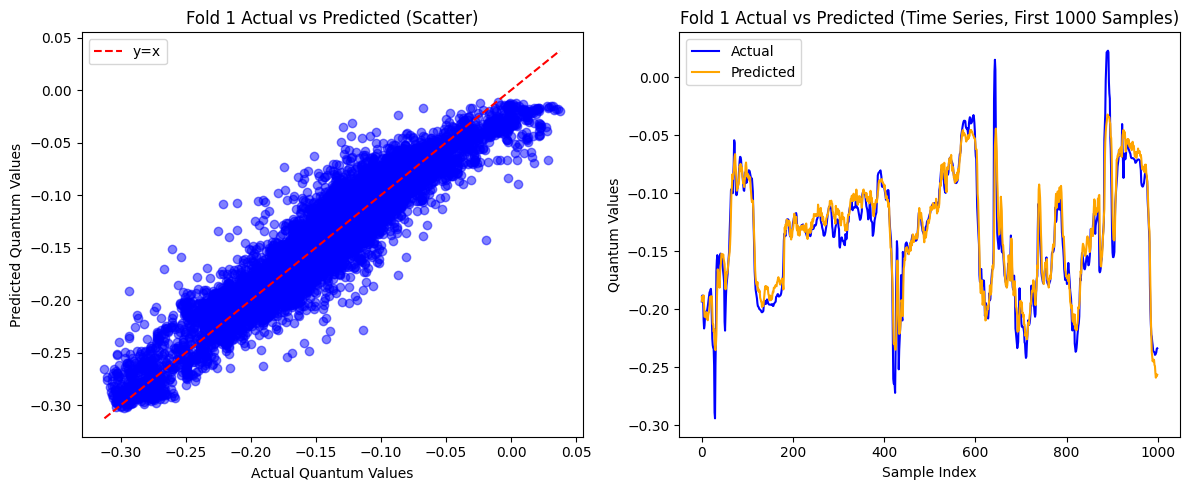

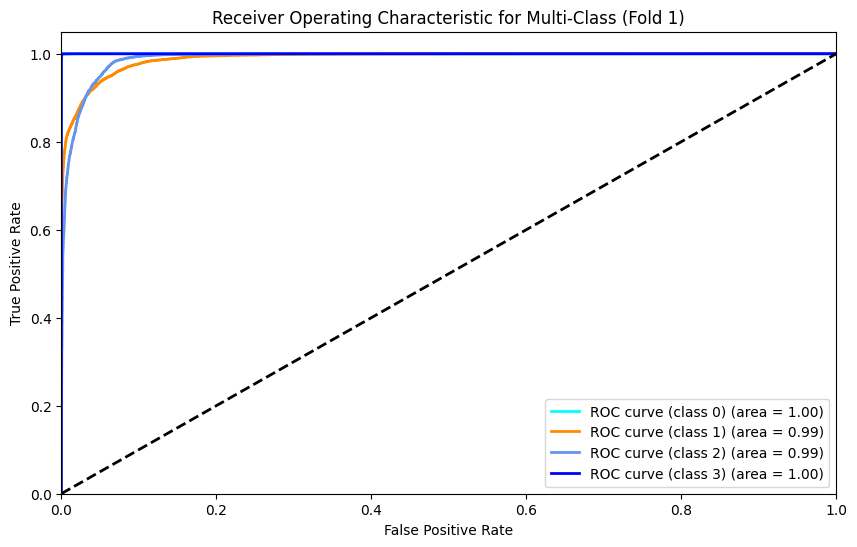


=== FOLD 1 TEST RESULTS ===
Test Loss: 0.079048
Quantum Test RMSE: 0.011646
Quantum Test MAE: 0.008247
Quantum Confidence Interval: 0.000105
Quantum Correlation Coefficient: 0.9429
ROC AUC: 0.9949
Test loss goal achieved!

=== Fold 2/2 ===
Train data shape: (46758, 32), Train labels shape: (46758,)
Val data shape: (46758, 32), Val labels shape: (46758,)
Fold 2 - Train samples: 46502, Val samples: 46502
Train class distribution: {0: 12228, 1: 12200, 2: 12285, 3: 10045}
Val class distribution: {0: 12196, 1: 12502, 2: 12026, 3: 10034}
Model initialized on cuda:0


Fold 2 Epoch 1: 100%|██████████| 727/727 [02:48<00:00,  4.33it/s]


Sample pred_probs (first 5 samples):
[[0.00565928 0.20964234 0.7827054  0.001993  ]
 [0.00784979 0.22651888 0.7637171  0.00191418]
 [0.00574837 0.18597607 0.8063128  0.00196277]
 [0.00586722 0.18488522 0.8071562  0.00209138]
 [0.00600189 0.20060049 0.7914603  0.00193724]]

=== Per-Class Metrics ===
Class 0: Precision=0.8474, Recall=0.9811, F1=0.9093
Class 1: Precision=0.8426, Recall=0.7340, F1=0.7846
Class 2: Precision=0.8857, Recall=0.8555, F1=0.8704
Class 3: Precision=0.9902, Recall=0.9988, F1=0.9945
Classifier weight norm: 24.0067
Fold 2 Epoch 1: Train Loss=0.438756, Val Loss=0.183048, Quantum RMSE=0.019887, Quantum MAE=0.015471, Quantum Conf Interval=0.000146, Quantum Correlation=0.8884, ROC AUC=0.9826
Saved best model at fold 2 epoch 1 with Val Loss=0.183048


Fold 2 Epoch 2: 100%|██████████| 727/727 [02:47<00:00,  4.35it/s]


Sample pred_probs (first 5 samples):
[[6.4737098e-05 4.0274434e-02 9.5950282e-01 1.5801462e-04]
 [9.3359748e-05 4.5835033e-02 9.5390695e-01 1.6466540e-04]
 [6.7360452e-05 3.5793029e-02 9.6398157e-01 1.5802775e-04]
 [7.0781120e-05 3.5802264e-02 9.6395719e-01 1.6981484e-04]
 [7.3534575e-05 4.1925333e-02 9.5784694e-01 1.5410988e-04]]

=== Per-Class Metrics ===
Class 0: Precision=0.9926, Recall=0.9731, F1=0.9828
Class 1: Precision=0.8529, Recall=0.9210, F1=0.8856
Class 2: Precision=0.9153, Recall=0.8569, F1=0.8851
Class 3: Precision=0.9998, Recall=0.9990, F1=0.9994
Classifier weight norm: 24.0764
Fold 2 Epoch 2: Train Loss=0.168887, Val Loss=0.133896, Quantum RMSE=0.028824, Quantum MAE=0.023347, Quantum Conf Interval=0.000190, Quantum Correlation=0.8572, ROC AUC=0.9921
Saved best model at fold 2 epoch 2 with Val Loss=0.133896


Fold 2 Epoch 3: 100%|██████████| 727/727 [02:46<00:00,  4.36it/s]


Sample pred_probs (first 5 samples):
[[7.44339786e-06 4.12182994e-02 9.58729744e-01 4.45189107e-05]
 [1.21221465e-05 4.82823290e-02 9.51654851e-01 5.07311561e-05]
 [7.87312911e-06 3.45012471e-02 9.65446472e-01 4.44566540e-05]
 [8.52203266e-06 3.40075754e-02 9.65935886e-01 4.80157978e-05]
 [8.45076192e-06 3.89983244e-02 9.60952938e-01 4.02907317e-05]]

=== Per-Class Metrics ===
Class 0: Precision=0.9976, Recall=0.9958, F1=0.9967
Class 1: Precision=0.8710, Recall=0.9453, F1=0.9066
Class 2: Precision=0.9373, Recall=0.8547, F1=0.8941
Class 3: Precision=0.9993, Recall=0.9987, F1=0.9990
Classifier weight norm: 24.1487
Fold 2 Epoch 3: Train Loss=0.128478, Val Loss=0.086157, Quantum RMSE=0.015125, Quantum MAE=0.012002, Quantum Conf Interval=0.000109, Quantum Correlation=0.9383, ROC AUC=0.9948
Saved best model at fold 2 epoch 3 with Val Loss=0.086157


Fold 2 Epoch 4: 100%|██████████| 727/727 [02:46<00:00,  4.36it/s]


Sample pred_probs (first 5 samples):
[[2.17688171e-06 5.66145545e-03 9.94326055e-01 1.03534485e-05]
 [5.15894817e-06 7.84338079e-03 9.92136717e-01 1.47772580e-05]
 [2.43421073e-06 4.80958773e-03 9.95177507e-01 1.04931842e-05]
 [2.81469011e-06 4.94851964e-03 9.95036423e-01 1.21960384e-05]
 [3.01086470e-06 6.69044722e-03 9.93295610e-01 1.09729845e-05]]

=== Per-Class Metrics ===
Class 0: Precision=0.9959, Recall=0.9986, F1=0.9973
Class 1: Precision=0.8977, Recall=0.9109, F1=0.9042
Class 2: Precision=0.9065, Recall=0.8897, F1=0.8980
Class 3: Precision=0.9979, Recall=0.9980, F1=0.9980
Classifier weight norm: 24.2085
Fold 2 Epoch 4: Train Loss=0.075757, Val Loss=0.090519, Quantum RMSE=0.012216, Quantum MAE=0.008863, Quantum Conf Interval=0.000111, Quantum Correlation=0.9395, ROC AUC=0.9936


Fold 2 Epoch 5: 100%|██████████| 727/727 [02:46<00:00,  4.36it/s]


Sample pred_probs (first 5 samples):
[[1.9023771e-07 3.4825734e-03 9.9651688e-01 3.4489278e-07]
 [6.1831832e-07 4.3426328e-03 9.9565625e-01 4.7786727e-07]
 [2.7972177e-07 3.1933442e-03 9.9680591e-01 4.0170519e-07]
 [3.1130634e-07 3.3389046e-03 9.9666035e-01 4.5432898e-07]
 [3.0399576e-07 4.2910445e-03 9.9570829e-01 3.3030068e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9963, Recall=0.9973, F1=0.9968
Class 1: Precision=0.8865, Recall=0.9186, F1=0.9023
Class 2: Precision=0.9094, Recall=0.8761, F1=0.8924
Class 3: Precision=1.0000, Recall=0.9966, F1=0.9983
Classifier weight norm: 24.3467
Fold 2 Epoch 5: Train Loss=0.080826, Val Loss=0.087383, Quantum RMSE=0.013904, Quantum MAE=0.010555, Quantum Conf Interval=0.000118, Quantum Correlation=0.9293, ROC AUC=0.9943
Early stopping at fold 2 epoch 5

Loading best model from fold 2 epoch 3 for testing...
Fold 2 Batch 0: quantum pred min: -1.4574942588806152, max: 0.1604005992412567
Fold 2 Batch 1: quantum pred min: -0.7468464970588684, ma

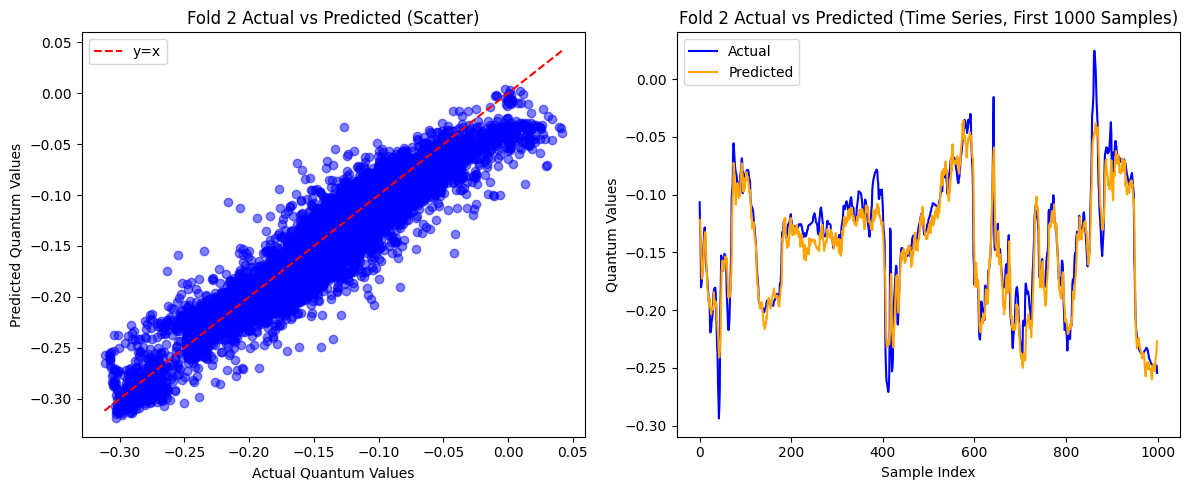

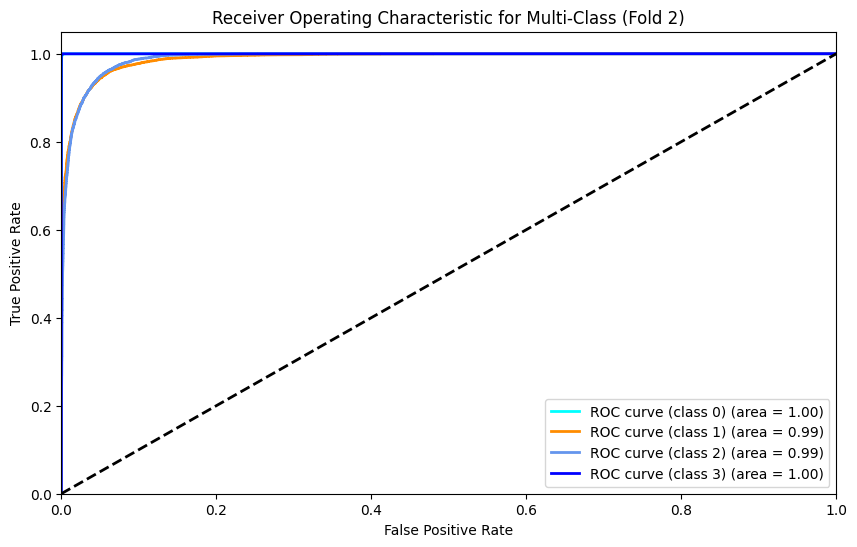


=== FOLD 2 TEST RESULTS ===
Test Loss: 0.086157
Quantum Test RMSE: 0.015125
Quantum Test MAE: 0.012002
Quantum Confidence Interval: 0.000109
Quantum Correlation Coefficient: 0.9383
ROC AUC: 0.9948
Test loss goal achieved!

=== CROSS-VALIDATION SUMMARY ===
Average Test Loss: 0.082602
Average Quantum Correlation: 0.9406
Average ROC AUC: 0.9948
Fold 1: Test Loss=0.079048, Quantum Correlation=0.9429, ROC AUC=0.9949
Fold 2: Test Loss=0.086157, Quantum Correlation=0.9383, ROC AUC=0.9948

=== BEST FOLD SELECTED ===
Best Fold: 1
Test Loss: 0.079048
Quantum Test RMSE: 0.011646
Quantum Test MAE: 0.008247
Quantum Confidence Interval: 0.000105
Quantum Correlation Coefficient: 0.9429
ROC AUC: 0.9949
Best model weights saved at: best_model_fold1.pth


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import gc
import warnings
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import pywt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import PowerTransformer, label_binarize
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import cycle
import torch.nn.functional as F

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.transformer")

# Optimize CUDA settings
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.set_float32_matmul_precision('high')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

DATASET_PATH = "/kaggle/input/arrythimia/Dataset_Fourtype.csv"

def bandpass_filter(data, lowcut=0.3, highcut=50.0, fs=360.0, order=5):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data, axis=0)
    return filtered

def mad(data):
    return np.median(np.abs(data - np.median(data)))

def wavelet_denoise(data, wavelet='db8', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = mad(coeffs[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=uthresh, mode='soft')
    return pywt.waverec(coeffs, wavelet)

def align_r_peaks(data, fs=360.0, window=250):
    aligned_data = []
    for i in range(0, len(data) - window, window):
        segment = data[i:i+window]
        peaks, _ = find_peaks(segment[:, 0], height=0.5, distance=int(fs/3))
        if len(peaks) > 0:
            r_peak = peaks[0]
            start = max(0, r_peak - window//2)
            end = start + window
            if end <= len(segment):
                aligned_data.append(segment[start:end])
            else:
                aligned_data.append(segment[-window:])
        else:
            aligned_data.append(segment)
    return np.array(aligned_data).reshape(-1, data.shape[1])

def add_baseline_wander(data, amplitude=0.1, frequency=0.5, fs=360.0):
    t = np.arange(len(data)) / fs
    wander = amplitude * np.sin(2 * np.pi * frequency * t)
    return data + wander[:, np.newaxis]

def add_muscle_artifact(data, amplitude=0.05, fs=360.0):
    t = np.arange(len(data)) / fs
    noise = amplitude * np.random.randn(len(data))
    return data + noise[:, np.newaxis]

class iTransformer(nn.Module):
    def __init__(self, num_variates, seq_len, pred_len, n_classes, hidden_size=512, num_heads=8, num_layers=4, dropout=0.3, ffn_multiplier=4, activation='gelu', device='cuda:0'):
        super().__init__()
        self.num_variates = num_variates
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.device = torch.device(device)
        
        self.proj_in = nn.Linear(num_variates, hidden_size)
        self.pos_enc = PositionalEncoding(hidden_size)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=ffn_multiplier*hidden_size,
                dropout=dropout,
                activation=activation,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        self.classifier_head = nn.Linear(hidden_size * seq_len, hidden_size)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 2, n_classes)
        )
        self.regression_head = nn.Linear(hidden_size * seq_len, hidden_size)
        self.regression_output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        if x.shape[-1] != self.num_variates:
            raise ValueError(f"Input variates {x.shape[-1]} do not match expected {self.num_variates}")
        
        with autocast('cuda', dtype=torch.float16):
            x_trans = self.proj_in(x)
            x_trans = self.pos_enc(x_trans)
            x_trans = self.encoder(x_trans)
            x_trans = x_trans.reshape(x_trans.size(0), -1)
        
        regression_out = self.regression_head(x_trans)
        pred_quantum = self.regression_output(regression_out)
        
        class_branch = self.classifier_head(x_trans.float())
        class_logits = self.classifier(class_branch)
        class_logits = torch.clamp(class_logits, min=-10.0, max=10.0)
        pred_probs = F.softmax(class_logits, dim=1)
        pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
        
        return pred_quantum.flatten(), pred_probs

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[..., 0::2] = torch.sin(position * div_term)
        pe[..., 1::2] = torch.cos(position * div_term)
        self.pe = nn.Parameter(pe, requires_grad=False)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class ECG_loss(nn.Module):
    def __init__(self, quantum_weight=0.4, class_weight=0.6):
        super().__init__()
        self.huber = nn.HuberLoss()
        # Adjusted class_weights to have length 4 to match the 4 classes
        self.class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
        self.cross_entropy = nn.CrossEntropyLoss(weight=self.class_weights)
        self.quantum_weight = quantum_weight
        self.class_weight = class_weight

    def forward(self, pred_quantum, target_quantum, pred_probs, target_class):
        quantum_loss = self.huber(pred_quantum, target_quantum)
        class_loss = self.cross_entropy(pred_probs.log(), target_class)
        return self.quantum_weight * quantum_loss + self.class_weight * class_loss

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len, labels=None):
        self.features = data.values.astype(np.float32)
        self.labels = labels.astype(np.int64) if labels is not None else None
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_samples = len(data) - seq_len - pred_len + 1
        if self.num_samples <= 0:
            raise ValueError(f"Insufficient data: num_samples = {self.num_samples}")
        rng = np.random.default_rng()
        noise1 = rng.normal(0, 0.1, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        scale = rng.uniform(0.8, 1.2, (self.num_samples, 1, 1)).astype(np.float32)
        noise2 = rng.normal(0, 0.05, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        warp_factor = rng.uniform(0.9, 1.1, self.num_samples).astype(np.float32)
        self.augmented = []
        time_orig = np.linspace(0, 1, seq_len)
        for idx in range(self.num_samples):
            x = self.features[idx:idx + seq_len]
            x = add_baseline_wander(x)
            x = add_muscle_artifact(x)
            time_warped = np.linspace(0, 1, seq_len) * warp_factor[idx]
            time_warped = time_warped / time_warped[-1] * time_orig[-1]
            x_warped = np.zeros_like(x)
            for v in range(x.shape[1]):
                interp = interp1d(time_orig, x[:, v], kind='linear', fill_value="extrapolate")
                x_warped[:, v] = interp(time_warped)
            t = np.linspace(0, 1, seq_len)
            wander = 0.05 * np.sin(2 * np.pi * 0.5 * t)
            x = x_warped + wander[:, None] + noise1[idx]
            x = x * scale[idx] + noise2[idx]
            if rng.random() > 0.5:
                crop_start = rng.integers(0, seq_len // 10)
                x = x[crop_start:crop_start + seq_len] if crop_start + seq_len <= len(x) else x
            x = np.clip(x, -5, 5)
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Warning: NaN or Inf in augmented data at index {idx}")
                x = np.nan_to_num(x, nan=0.0, posinf=5.0, neginf=-5.0)
            self.augmented.append(x)
        all_data = self.features[self.seq_len:self.seq_len + self.num_samples, :]
        self.quantum_targets = np.mean(all_data, axis=1).astype(np.float32)
        if self.labels is not None:
            self.labels = self.labels[self.seq_len:self.seq_len + self.num_samples]

    def __len__(self):
        return max(0, self.num_samples)
    
    def __getitem__(self, idx):
        idx = idx % self.num_samples
        x = self.augmented[idx]
        y_quantum = self.quantum_targets[idx]
        y_label = self.labels[idx] if self.labels is not None else -1
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_quantum, dtype=torch.float32), torch.tensor(y_label, dtype=torch.int64)

def calculate_metrics(true_quantum, pred_quantum):
    rmse = torch.sqrt(torch.mean((true_quantum - pred_quantum)**2))
    mae = torch.mean(torch.abs(true_quantum - pred_quantum))
    std_error = torch.std(true_quantum - pred_quantum)
    z_score = 1.96
    conf_interval = z_score * std_error / np.sqrt(true_quantum.size(0))
    true_range = torch.clamp(torch.max(true_quantum) - torch.min(true_quantum), min=1e-6)
    threshold = 0.3 * true_range
    abs_error = torch.abs(true_quantum - pred_quantum)
    accuracy_percentage = torch.mean((abs_error < threshold).float()) * 100
    corr_coef, _ = pearsonr(true_quantum.cpu().numpy(), pred_quantum.cpu().numpy())
    return {
        'Quantum_RMSE': rmse.item(),
        'Quantum_MAE': mae.item(),
        'Quantum_Conf_Interval': conf_interval.item(),
        'Quantum_Accuracy_Percentage': accuracy_percentage.item(),
        'Quantum_Correlation': corr_coef
    }

def get_optimizer(model, optimizer_name, lr, weight_decay):
    if optimizer_name == 'adam':
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'adamw':
        return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=0.9)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

def get_scheduler(optimizer, scheduler_type, warmup_epochs, total_epochs):
    if scheduler_type == 'cosine':
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    elif scheduler_type == 'step':
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    elif scheduler_type == 'reduce_on_plateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_type}")

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device: {device}")

    try:
        raw_data = pd.read_csv(DATASET_PATH)
        raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        raw_data.dropna(inplace=True)
        print(f"Raw data shape after dropping NaN: {raw_data.shape}")
    except Exception as e:
        raise ValueError(f"Error loading dataset: {e}")

    original_n_rows = raw_data.shape[0]
    lead0_columns = [col for col in raw_data.columns if col.startswith('0_') or col == 'type']
    raw_data = raw_data[lead0_columns]
    print(f"Data shape after selecting Lead 0: {raw_data.shape}")

    if 'type' in raw_data.columns:
        labels = raw_data['type'].values
        filtered_data = raw_data.drop(columns=['type']).values
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_classes = len(unique_labels)
        print("\n=== Class Label Distribution ===")
        for label, count in zip(unique_labels, counts):
            print(f"Label {int(label)}: {count} samples")
        class_weights = {}
        n_samples = len(labels)
        for label, count in zip(unique_labels, counts):
            weight = n_samples / (n_classes * count)
            class_weights[int(label)] = weight
        print(f"Class weights: {class_weights}")
    else:
        filtered_data = raw_data.values
        labels = None
        n_classes = 0
        print("No 'type' column found, proceeding without labels.")

    print(f"Initial filtered_data shape: {filtered_data.shape}, labels shape: {labels.shape if labels is not None else 'None'}")

    filtered_data = np.apply_along_axis(wavelet_denoise, 0, filtered_data)
    filtered_data = bandpass_filter(filtered_data)
    filtered_data = np.clip(filtered_data, np.percentile(filtered_data, 2), np.percentile(filtered_data, 98))
    filtered_df = pd.DataFrame(filtered_data, columns=[f"lead0_{i}" for i in range(filtered_data.shape[1])])
    filtered_df = filtered_df.rolling(window=3).mean().bfill()
    filtered_df = filtered_df.iloc[:original_n_rows]
    print(f"filtered_df shape after rolling: {filtered_df.shape}")

    data_ma = filtered_df.rolling(window=5).mean().bfill()
    data_ma.columns = [f"{col}_ma" for col in filtered_df.columns]
    data_ma = data_ma.iloc[:original_n_rows]
    enhanced_data = pd.concat([filtered_df, data_ma], axis=1)
    print(f"Enhanced data shape: {enhanced_data.shape}, num_variates: {enhanced_data.shape[1]}")

    scaler_yeo = PowerTransformer(method='yeo-johnson', standardize=True)
    norm_data = scaler_yeo.fit_transform(enhanced_data)
    norm_data = np.nan_to_num(norm_data, nan=0.0, posinf=5.0, neginf=-5.0)
    norm_data = np.clip(norm_data, -10.0, 10.0)
    norm_data = pd.DataFrame(norm_data, columns=enhanced_data.columns)
    print(f"norm_data shape: {norm_data.shape}, labels shape: {labels.shape if labels is not None else 'None'}")

    all_data = enhanced_data.values
    quantum_targets = np.mean(all_data, axis=1)
    quantum_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    quantum_targets = quantum_scaler.fit_transform(quantum_targets.reshape(-1, 1)).flatten()
    quantum_targets = np.nan_to_num(quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
    quantum_targets = np.clip(quantum_targets, -10.0, 10.0)
    quantum_targets_min = quantum_targets.min()
    quantum_targets_max = quantum_targets.max()
    quantum_targets_range = quantum_targets_max - quantum_targets_min if quantum_targets_max != quantum_targets_min else 1
    quantum_targets = 2 * (quantum_targets - quantum_targets_min) / quantum_targets_range - 1
    print(f"Quantum targets range: [{quantum_targets.min():.4f}, {quantum_targets.max():.4f}]")

    print(f"Number of Target Values: {len(quantum_targets)}")
    print(f"Target Value Name: Quantum Target (Mean of Lead 0 Attributes)")

    if labels is not None and norm_data.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: norm_data has {norm_data.shape[0]} rows, but labels has {labels.shape[0]} rows.")

    config = {
        'num_variates': norm_data.shape[1],
        'seq_len': 256,
        'pred_len': 1,
        'hidden_size': 512,
        'num_heads': 8,
        'num_layers': 4,
        'dropout': 0.3,
        'lr': 2e-4,
        'batch_size': 64,
        'epochs': 80,
        'patience': 2,
        'grad_clip': 1.0,
        'warmup_epochs': 10,
        'grad_accum_steps': 1,
        'n_splits': 2,
        'min_samples': 299,
        'num_workers': 4,
        'optimizer': 'adamw',
        'weight_decay': 5e-3,
        'scheduler_type': 'cosine',
        'activation': 'gelu',
        'ffn_multiplier': 4,
        'quantum_weight': 0.4,
        'class_weight': 0.6
    }

    kf = KFold(n_splits=config['n_splits'], shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(enhanced_data)):
        print(f"\n=== Fold {fold+1}/{config['n_splits']} ===")
        train_data = enhanced_data.iloc[train_idx]
        val_data = enhanced_data.iloc[val_idx]
        train_labels = labels[train_idx] if labels is not None else None
        val_labels = labels[val_idx] if labels is not None else None
        print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape if train_labels is not None else 'None'}")
        print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape if val_labels is not None else 'None'}")

        scaler_yeo_train = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_train = scaler_yeo_train.fit_transform(train_data)
        norm_train = np.nan_to_num(norm_train, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_train = np.clip(norm_train, -10.0, 10.0)
        norm_train = pd.DataFrame(norm_train, columns=enhanced_data.columns)

        scaler_yeo_val = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_val = scaler_yeo_val.fit_transform(val_data)
        norm_val = np.nan_to_num(norm_val, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_val = np.clip(norm_val, -10.0, 10.0)
        norm_val = pd.DataFrame(norm_val, columns=enhanced_data.columns)

        quantum_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        train_quantum_targets = quantum_scaler.fit_transform(quantum_targets[train_idx].reshape(-1, 1)).flatten()
        train_quantum_targets = np.nan_to_num(train_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        train_quantum_targets = np.clip(train_quantum_targets, -10.0, 10.0)
        train_quantum_targets_min = train_quantum_targets.min()
        train_quantum_targets_max = train_quantum_targets.max()
        train_quantum_targets_range = train_quantum_targets_max - train_quantum_targets_min if train_quantum_targets_max != train_quantum_targets_min else 1
        train_quantum_targets = 2 * (train_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1

        val_quantum_targets = quantum_scaler.transform(quantum_targets[val_idx].reshape(-1, 1)).flatten()
        val_quantum_targets = np.nan_to_num(val_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        val_quantum_targets = np.clip(val_quantum_targets, -10.0, 10.0)
        val_quantum_targets = 2 * (val_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1

        try:
            train_dataset = TimeSeriesDataset(norm_train, config['seq_len'], config['pred_len'], train_labels)
            val_dataset = TimeSeriesDataset(norm_val, config['seq_len'], config['pred_len'], val_labels)
            print(f"Fold {fold+1} - Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        except Exception as e:
            print(f"Error creating datasets for fold {fold+1}: {e}. Skipping fold.")
            continue

        if train_labels is not None:
            train_class_dist = {}
            unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
            for label, count in zip(unique_train_labels, train_counts):
                train_class_dist[int(label)] = count
            print(f"Train class distribution: {train_class_dist}")
        if val_labels is not None:
            val_class_dist = {}
            unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
            for label, count in zip(unique_val_labels, val_counts):
                val_class_dist[int(label)] = count
            print(f"Val class distribution: {val_class_dist}")

        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )

        if len(train_loader) == 0:
            print(f"Train loader empty for fold {fold+1}. Skipping fold.")
            continue

        try:
            model = iTransformer(
                num_variates=config['num_variates'],
                seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                n_classes=n_classes,
                hidden_size=config['hidden_size'],
                num_heads=config['num_heads'],
                num_layers=config['num_layers'],
                dropout=config['dropout'],
                ffn_multiplier=config['ffn_multiplier'],
                activation=config['activation'],
                device=device
            ).to(device)
            print(f"Model initialized on {device}")
        except Exception as e:
            print(f"Error initializing model for fold {fold+1}: {e}. Skipping fold.")
            continue

        param_groups = [
            {'params': [p for n, p in model.named_parameters() if 'classifier' in n], 'lr': 1e-4, 'weight_decay': 1e-3},
            {'params': [p for n, p in model.named_parameters() if 'classifier' not in n], 'lr': config['lr'], 'weight_decay': config['weight_decay']}
        ]
        optimizer = get_optimizer(model, config['optimizer'], config['lr'], config['weight_decay'])
        scheduler = get_scheduler(optimizer, config['scheduler_type'], config['warmup_epochs'], config['epochs'])
        criterion = ECG_loss(quantum_weight=config['quantum_weight'], class_weight=config['class_weight']).to(device)
        grad_scaler = GradScaler('cuda')

        best_val_loss = float('inf')
        best_val_accuracy = 0.0
        patience_counter = 0
        best_epoch = 0
        train_losses, val_losses, quantum_rmses, quantum_maes = [], [], [], []

        for epoch in range(config['epochs']):
            model.train()
            train_loss = 0
            for batch_idx, (x, y_quantum, y_label) in enumerate(tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}")):
                x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with autocast('cuda', dtype=torch.float16):
                    pred_quantum, pred_probs = model(x)
                    loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                grad_scaler.scale(loss).backward()
                if (batch_idx + 1) % config['grad_accum_steps'] == 0 or (batch_idx + 1) == len(train_loader):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config['grad_clip'])
                    grad_scaler.step(optimizer)
                    grad_scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                train_loss += loss.item()
                del x, y_quantum, y_label, pred_quantum, pred_probs, loss
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0
            pred_quantums, true_quantums, pred_probs_list, true_labels_list = [], [], [], []
            with torch.no_grad():
                for x, y_quantum, y_label in val_loader:
                    x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                    pred_quantum, pred_probs = model(x)
                    with autocast('cuda', dtype=torch.float16):
                        loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                    val_loss += loss.item()
                    pred_quantums.append(pred_quantum.cpu())
                    true_quantums.append(y_quantum.cpu())
                    prob_sums = pred_probs.sum(dim=1)
                    if not torch.allclose(prob_sums, torch.ones_like(prob_sums), rtol=1e-6, atol=1e-6):
                        max_deviation = (prob_sums - 1.0).abs().max().item()
                        print(f"Warning: Probabilities do not sum to 1 in batch, max deviation: {max_deviation}")
                        pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
                    if len(pred_probs_list) == 0:
                        print(f"Sample pred_probs (first 5 samples):\n{pred_probs[:5].cpu().numpy()}")
                    pred_probs_list.append(pred_probs.cpu())
                    true_labels_list.append(y_label.cpu())
                    del x, y_quantum, y_label, pred_quantum, pred_probs, loss
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            pred_quantums = torch.cat(pred_quantums)
            true_quantums = torch.cat(true_quantums)
            pred_probs = torch.cat(pred_probs_list)
            true_labels = torch.cat(true_labels_list)
            pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            quantum_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
            quantum_rmse = quantum_metrics['Quantum_RMSE']
            quantum_mae = quantum_metrics['Quantum_MAE']
            quantum_conf_interval = quantum_metrics['Quantum_Conf_Interval']
            quantum_corr = quantum_metrics['Quantum_Correlation']
            pred_probs_np = pred_probs.cpu().numpy()
            true_labels_np = true_labels.cpu().numpy()
            prob_sums_np = pred_probs_np.sum(axis=1)
            if not np.allclose(prob_sums_np, 1.0, rtol=1e-6, atol=1e-6):
                print(f"Warning: Final probabilities do not sum to 1, max deviation: {np.abs(prob_sums_np - 1.0).max()}")
                pred_probs_np = pred_probs_np / (pred_probs_np.sum(axis=1, keepdims=True) + 1e-10)
            try:
                roc_auc = roc_auc_score(true_labels_np, pred_probs_np, multi_class='ovr')
            except ValueError as e:
                print(f"Error computing ROC AUC: {e}. Skipping ROC AUC for this fold.")
                roc_auc = float('nan')
            pred_labels = np.argmax(pred_probs_np, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels_np, pred_labels, average=None, labels=range(n_classes))
            print("\n=== Per-Class Metrics ===")
            for i in range(n_classes):
                print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")
            classifier_weight_norm = sum(p.norm().item() for n, p in model.named_parameters() if 'classifier' in n)
            print(f"Classifier weight norm: {classifier_weight_norm:.4f}")
            quantum_rmses.append(quantum_rmse)
            quantum_maes.append(quantum_mae)

            if config['scheduler_type'] == 'reduce_on_plateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()

            print(f"Fold {fold+1} Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}, "
                  f"Quantum RMSE={quantum_rmse:.6f}, Quantum MAE={quantum_mae:.6f}, "
                  f"Quantum Conf Interval={quantum_conf_interval:.6f}, "
                  f"Quantum Correlation={quantum_corr:.4f}, ROC AUC={roc_auc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model_fold{fold+1}.pth")
                print(f"Saved best model at fold {fold+1} epoch {epoch+1} with Val Loss={best_val_loss:.6f}")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config['patience']:
                    print(f"Early stopping at fold {fold+1} epoch {epoch+1}")
                    break

        print(f"\nLoading best model from fold {fold+1} epoch {best_epoch} for testing...")
        state_dict = torch.load(f"best_model_fold{fold+1}.pth", weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        val_loss = 0
        pred_quantums, true_quantums, pred_probs_list, true_labels_list = [], [], [], []
        with torch.no_grad():
            for batch_idx, (x, y_quantum, y_label) in enumerate(val_loader):
                x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                pred_quantum, pred_probs = model(x)
                with autocast('cuda', dtype=torch.float16):
                    loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                val_loss += loss.item()
                pred_quantums.append(pred_quantum.cpu())
                true_quantums.append(y_quantum.cpu())
                prob_sums = pred_probs.sum(dim=1)
                if not torch.allclose(prob_sums, torch.ones_like(prob_sums), rtol=1e-6, atol=1e-6):
                    max_deviation = (prob_sums - 1.0).abs().max().item()
                    print(f"Warning: Probabilities do not sum to 1 in test batch {batch_idx}, max deviation: {max_deviation}")
                    pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
                pred_probs_list.append(pred_probs.cpu())
                true_labels_list.append(y_label.cpu())
                print(f"Fold {fold+1} Batch {batch_idx}: quantum pred min: {pred_quantum.min().item()}, max: {pred_quantum.max().item()}")
                del x, y_quantum, y_label, pred_quantum, pred_probs, loss
        val_loss /= len(val_loader)
        pred_quantums = torch.cat(pred_quantums)
        true_quantums = torch.cat(true_quantums)
        pred_probs = torch.cat(pred_probs_list)
        true_labels = torch.cat(true_labels_list)
        pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        test_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
        quantum_test_rmse = test_metrics['Quantum_RMSE']
        quantum_test_mae = test_metrics['Quantum_MAE']
        quantum_conf_interval = test_metrics['Quantum_Conf_Interval']
        quantum_corr = test_metrics['Quantum_Correlation']
        pred_probs_np = pred_probs.cpu().numpy()
        true_labels_np = true_labels.cpu().numpy()
        prob_sums_np = pred_probs_np.sum(axis=1)
        if not np.allclose(prob_sums_np, 1.0, rtol=1e-6, atol=1e-6):
            print(f"Warning: Final test probabilities do not sum to 1, max deviation: {np.abs(prob_sums_np - 1.0).max()}")
            pred_probs_np = pred_probs_np / (pred_probs_np.sum(axis=1, keepdims=True) + 1e-10)
        try:
            roc_auc = roc_auc_score(true_labels_np, pred_probs_np, multi_class='ovr')
        except ValueError as e:
            print(f"Error computing ROC AUC in test: {e}. Setting ROC AUC to NaN.")
            roc_auc = float('nan')

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(true_quantums_denorm, pred_quantums_denorm, alpha=0.5, color='blue')
        plt.plot([min(true_quantums_denorm), max(true_quantums_denorm)], 
                 [min(true_quantums_denorm), max(true_quantums_denorm)], 'r--', label='y=x')
        plt.xlabel('Actual Quantum Values')
        plt.ylabel('Predicted Quantum Values')
        plt.title(f'Fold {fold+1} Actual vs Predicted (Scatter)')
        plt.legend()

        time_series_length = min(1000, len(true_quantums_denorm))
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(time_series_length), true_quantums_denorm[:time_series_length], label='Actual', color='blue')
        plt.plot(np.arange(time_series_length), pred_quantums_denorm[:time_series_length], label='Predicted', color='orange')
        plt.xlabel('Sample Index')
        plt.ylabel('Quantum Values')
        plt.title(f'Fold {fold+1} Actual vs Predicted (Time Series, First {time_series_length} Samples)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        true_labels_bin = label_binarize(true_labels_np, classes=range(n_classes))
        fpr = dict()
        tpr = dict()
        roc_auc_dict = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_probs_np[:, i])
            roc_auc_dict[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(10, 6))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                     label=f'ROC curve (class {i}) (area = {roc_auc_dict[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for Multi-Class (Fold {fold+1})')
        plt.legend(loc="lower right")
        plt.show()

        print(f"\n=== FOLD {fold+1} TEST RESULTS ===")
        print(f"Test Loss: {val_loss:.6f}")
        print(f"Quantum Test RMSE: {quantum_test_rmse:.6f}")
        print(f"Quantum Test MAE: {quantum_test_mae:.6f}")
        print(f"Quantum Confidence Interval: {quantum_conf_interval:.6f}")
        print(f"Quantum Correlation Coefficient: {quantum_corr:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        if val_loss < 0.5:
            print("Test loss goal achieved!")
        else:
            print("Test loss still high, consider further tuning.")

        fold_results.append({
            'fold': fold+1,
            'test_loss': val_loss,
            'quantum_rmse': quantum_test_rmse,
            'quantum_mae': quantum_test_mae,
            'quantum_conf_interval': quantum_conf_interval,
            'quantum_correlation': quantum_corr,
            'roc_auc': roc_auc
        })

        del train_dataset, val_dataset, train_loader, val_loader, model
        torch.cuda.empty_cache()
        gc.collect()

    if fold_results:
        print("\n=== CROSS-VALIDATION SUMMARY ===")
        avg_test_loss = np.mean([r['test_loss'] for r in fold_results])
        avg_quantum_correlation = np.mean([r['quantum_correlation'] for r in fold_results])
        avg_roc_auc = np.nanmean([r['roc_auc'] for r in fold_results])
        print(f"Average Test Loss: {avg_test_loss:.6f}")
        print(f"Average Quantum Correlation: {avg_quantum_correlation:.4f}")
        print(f"Average ROC AUC: {avg_roc_auc:.4f}")
        for r in fold_results:
            print(f"Fold {r['fold']}: Test Loss={r['test_loss']:.6f}, "
                  f"Quantum Correlation={r['quantum_correlation']:.4f}, ROC AUC={r['roc_auc']:.4f}")

        best_fold = min(fold_results, key=lambda x: x['test_loss'])
        print(f"\n=== BEST FOLD SELECTED ===")
        print(f"Best Fold: {best_fold['fold']}")
        print(f"Test Loss: {best_fold['test_loss']:.6f}")
        print(f"Quantum Test RMSE: {best_fold['quantum_rmse']:.6f}")
        print(f"Quantum Test MAE: {best_fold['quantum_mae']:.6f}")
        print(f"Quantum Confidence Interval: {best_fold['quantum_conf_interval']:.6f}")
        print(f"Quantum Correlation Coefficient: {best_fold['quantum_correlation']:.4f}")
        print(f"ROC AUC: {best_fold['roc_auc']:.4f}")
        print(f"Best model weights saved at: best_model_fold{best_fold['fold']}.pth")
    else:
        print("No valid folds processed. Check dataset size or split configuration.")

if __name__ == "__main__":
    main()

# Quntum-iTransformer with RandomsearchCV

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device: cuda:0
Raw data shape after dropping NaN: (93516, 17)
Data shape after selecting Lead 0: (93516, 17)

=== Class Label Distribution ===
Label 0: 24424 samples
Label 1: 24702 samples
Label 2: 24311 samples
Label 3: 20079 samples
Class weights: {0: 0.9572142155257124, 1: 0.946441583677435, 2: 0.9616634445312822, 3: 1.16435081428358}
Initial filtered_data shape: (93516, 16), labels shape: (93516,)
filtered_df shape after rolling: (93516, 16)
Enhanced data shape: (93516, 32), num_variates: 32
norm_data shape: (93516, 32), labels shape: (93516,)
Quantum targets range: [-1.0000, 1.0000]
Number of Target Values: 93516
Target Value Name: Quantum Target (Mean of Lead 0 Attributes)

=== Fold 1/2 ===
Train data shape: (46758, 32), Train labels shape: (46758,)
Val data shape: (46758, 32), Val labels shape: (46758,)
Fold 1 - Train samples: 46502, Val samples: 46502
Train class distribution: {0: 12217, 1: 12470, 2: 12053, 3:

Fold 1 Epoch 1: 100%|██████████| 727/727 [02:48<00:00,  4.32it/s]


Sample pred_probs (first 5 samples):
[[0.11299512 0.24165322 0.6258585  0.01949324]
 [0.18918547 0.26804116 0.5256883  0.01708507]
 [0.05888334 0.20437512 0.71269286 0.02404876]
 [0.11597113 0.24644734 0.6178032  0.01977835]
 [0.1434711  0.25520253 0.58285415 0.01847225]]

=== Per-Class Metrics ===
Class 0: Precision=0.8985, Recall=0.9924, F1=0.9431
Class 1: Precision=0.9000, Recall=0.7442, F1=0.8147
Class 2: Precision=0.8590, Recall=0.9119, F1=0.8847
Class 3: Precision=0.9899, Recall=1.0000, F1=0.9949
Classifier weight norm: 23.9978
Fold 1 Epoch 1: Train Loss=0.527755, Val Loss=0.250436, Quantum RMSE=0.056449, Quantum MAE=0.048361, Quantum Conf Interval=0.000328, Quantum Correlation=0.6416, ROC AUC=0.9881
Saved best model at fold 1 epoch 1 with Val Loss=0.250436


Fold 1 Epoch 2: 100%|██████████| 727/727 [02:47<00:00,  4.33it/s]


Sample pred_probs (first 5 samples):
[[3.5711513e-03 1.0464626e-01 8.9105302e-01 7.2956708e-04]
 [1.1185222e-02 1.9387013e-01 7.9400170e-01 9.4294647e-04]
 [1.4260149e-03 4.9599495e-02 9.4809401e-01 8.8046730e-04]
 [4.0944535e-03 1.0498500e-01 8.9005071e-01 8.6985895e-04]
 [5.4771709e-03 1.3340546e-01 8.6024600e-01 8.7139825e-04]]

=== Per-Class Metrics ===
Class 0: Precision=0.9907, Recall=0.9993, F1=0.9950
Class 1: Precision=0.8945, Recall=0.9015, F1=0.8980
Class 2: Precision=0.9085, Recall=0.8895, F1=0.8989
Class 3: Precision=0.9950, Recall=0.9999, F1=0.9974
Classifier weight norm: 24.0633
Fold 1 Epoch 2: Train Loss=0.266459, Val Loss=0.118524, Quantum RMSE=0.031960, Quantum MAE=0.025317, Quantum Conf Interval=0.000256, Quantum Correlation=0.7619, ROC AUC=0.9939
Saved best model at fold 1 epoch 2 with Val Loss=0.118524


Fold 1 Epoch 3: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[1.00828933e-04 9.37555358e-03 9.90456045e-01 6.75677074e-05]
 [9.15423676e-04 1.87425092e-02 9.80227888e-01 1.14190036e-04]
 [2.77762283e-05 3.20952805e-03 9.96691525e-01 7.11428875e-05]
 [1.18849050e-04 5.21141617e-03 9.94597197e-01 7.25485661e-05]
 [1.84243429e-04 6.57980749e-03 9.93161798e-01 7.42022894e-05]]

=== Per-Class Metrics ===
Class 0: Precision=0.9984, Recall=0.9986, F1=0.9985
Class 1: Precision=0.9009, Recall=0.9226, F1=0.9116
Class 2: Precision=0.9222, Recall=0.8956, F1=0.9087
Class 3: Precision=0.9950, Recall=1.0000, F1=0.9975
Classifier weight norm: 24.1855
Fold 1 Epoch 3: Train Loss=0.118796, Val Loss=0.075432, Quantum RMSE=0.010518, Quantum MAE=0.007760, Quantum Conf Interval=0.000095, Quantum Correlation=0.9528, ROC AUC=0.9953
Saved best model at fold 1 epoch 3 with Val Loss=0.075432


Fold 1 Epoch 4: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[1.33971174e-04 1.67718343e-03 9.98166680e-01 2.21441223e-05]
 [1.72404095e-03 4.54833265e-03 9.93679464e-01 4.81742100e-05]
 [1.30574954e-05 2.96686019e-04 9.99670923e-01 1.93212254e-05]
 [1.15628645e-04 7.35503912e-04 9.99122679e-01 2.61698242e-05]
 [1.81875163e-04 9.13319993e-04 9.98878419e-01 2.63970105e-05]]

=== Per-Class Metrics ===
Class 0: Precision=1.0000, Recall=0.9977, F1=0.9989
Class 1: Precision=0.9159, Recall=0.8884, F1=0.9019
Class 2: Precision=0.8921, Recall=0.9174, F1=0.9046
Class 3: Precision=0.9946, Recall=1.0000, F1=0.9973
Classifier weight norm: 24.2589
Fold 1 Epoch 4: Train Loss=0.073305, Val Loss=0.078524, Quantum RMSE=0.009472, Quantum MAE=0.006843, Quantum Conf Interval=0.000086, Quantum Correlation=0.9610, ROC AUC=0.9950


Fold 1 Epoch 5: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[3.6510366e-06 3.4240208e-04 9.9965370e-01 2.5056272e-07]
 [2.2832541e-05 5.2446721e-04 9.9945241e-01 2.9055639e-07]
 [1.1638085e-06 1.2915117e-04 9.9986935e-01 3.7486907e-07]
 [3.8348294e-06 1.6716136e-04 9.9982870e-01 3.1936332e-07]
 [4.9395294e-06 1.8522670e-04 9.9980956e-01 3.0661388e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9990, Recall=0.9983, F1=0.9986
Class 1: Precision=0.9377, Recall=0.8741, F1=0.9048
Class 2: Precision=0.8824, Recall=0.9408, F1=0.9106
Class 3: Precision=0.9957, Recall=1.0000, F1=0.9979
Classifier weight norm: 24.3678
Fold 1 Epoch 5: Train Loss=0.064731, Val Loss=0.071606, Quantum RMSE=0.008953, Quantum MAE=0.006413, Quantum Conf Interval=0.000078, Quantum Correlation=0.9675, ROC AUC=0.9958
Saved best model at fold 1 epoch 5 with Val Loss=0.071606


Fold 1 Epoch 6: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[5.3129429e-07 2.9115981e-04 9.9970299e-01 5.2806668e-06]
 [3.7526286e-06 5.1363528e-04 9.9947315e-01 9.4605784e-06]
 [9.8336550e-08 5.1770458e-05 9.9994326e-01 4.8901193e-06]
 [3.5894169e-07 8.0331651e-05 9.9991339e-01 5.9140134e-06]
 [4.5784310e-07 8.9055269e-05 9.9990416e-01 6.3428151e-06]]

=== Per-Class Metrics ===
Class 0: Precision=0.9998, Recall=0.9987, F1=0.9993
Class 1: Precision=0.9290, Recall=0.9037, F1=0.9162
Class 2: Precision=0.9063, Recall=0.9295, F1=0.9178
Class 3: Precision=0.9962, Recall=1.0000, F1=0.9981
Classifier weight norm: 24.4656
Fold 1 Epoch 6: Train Loss=0.058039, Val Loss=0.064628, Quantum RMSE=0.009015, Quantum MAE=0.006464, Quantum Conf Interval=0.000077, Quantum Correlation=0.9689, ROC AUC=0.9964
Saved best model at fold 1 epoch 6 with Val Loss=0.064628


Fold 1 Epoch 7: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[1.6210420e-06 8.5214699e-05 9.9991024e-01 2.9224286e-06]
 [2.0287744e-05 1.3824677e-04 9.9983275e-01 8.6868586e-06]
 [5.5178623e-07 1.9818683e-05 9.9997485e-01 4.7531962e-06]
 [2.6209600e-06 2.7805429e-05 9.9996269e-01 6.9183948e-06]
 [3.4819484e-06 2.7623832e-05 9.9996209e-01 6.7774054e-06]]

=== Per-Class Metrics ===
Class 0: Precision=0.9979, Recall=0.9985, F1=0.9982
Class 1: Precision=0.9289, Recall=0.8981, F1=0.9132
Class 2: Precision=0.9033, Recall=0.9294, F1=0.9162
Class 3: Precision=0.9950, Recall=1.0000, F1=0.9975
Classifier weight norm: 24.5229
Fold 1 Epoch 7: Train Loss=0.052088, Val Loss=0.072052, Quantum RMSE=0.011368, Quantum MAE=0.009053, Quantum Conf Interval=0.000075, Quantum Correlation=0.9698, ROC AUC=0.9960


Fold 1 Epoch 8: 100%|██████████| 727/727 [02:47<00:00,  4.35it/s]


Sample pred_probs (first 5 samples):
[[1.3652830e-04 2.7523127e-05 9.9982697e-01 9.0068379e-06]
 [2.6248612e-03 3.9202754e-05 9.9731076e-01 2.5190533e-05]
 [3.3561730e-05 4.5128977e-06 9.9995214e-01 9.7925840e-06]
 [1.8086957e-04 5.5683008e-06 9.9980026e-01 1.3292545e-05]
 [2.1353841e-04 5.5225873e-06 9.9976987e-01 1.1082131e-05]]

=== Per-Class Metrics ===
Class 0: Precision=0.9998, Recall=0.9993, F1=0.9995
Class 1: Precision=0.8965, Recall=0.9297, F1=0.9128
Class 2: Precision=0.9276, Recall=0.8906, F1=0.9087
Class 3: Precision=0.9966, Recall=1.0000, F1=0.9983
Classifier weight norm: 24.6072
Fold 1 Epoch 8: Train Loss=0.051120, Val Loss=0.067665, Quantum RMSE=0.008899, Quantum MAE=0.006209, Quantum Conf Interval=0.000079, Quantum Correlation=0.9683, ROC AUC=0.9961
Early stopping at fold 1 epoch 8

Loading best model from fold 1 epoch 6 for testing...
Fold 1 Batch 0: quantum pred min: -2.01953125, max: 0.29833984375
Fold 1 Batch 1: quantum pred min: -1.0322265625, max: 1.255859375
Fold

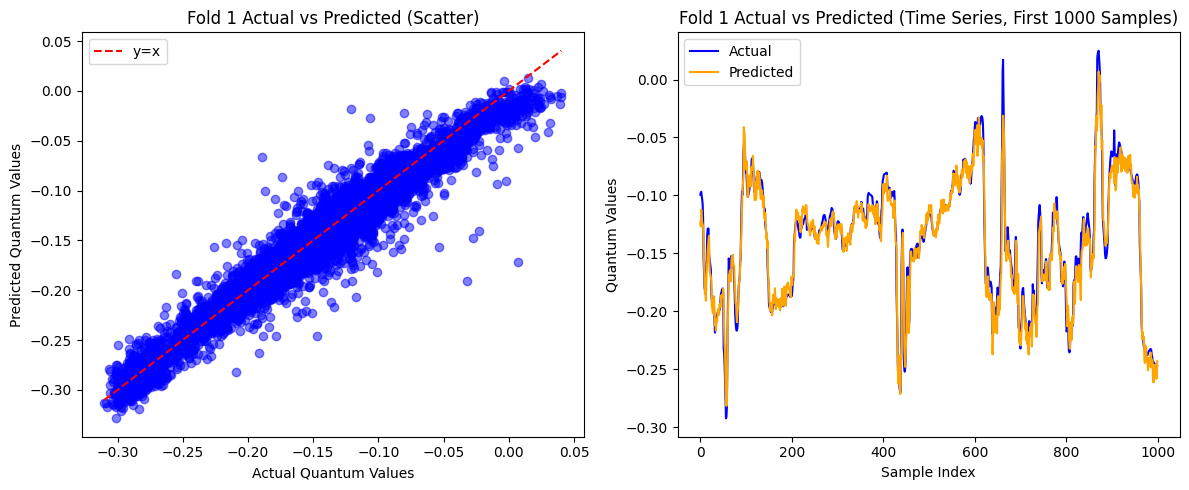

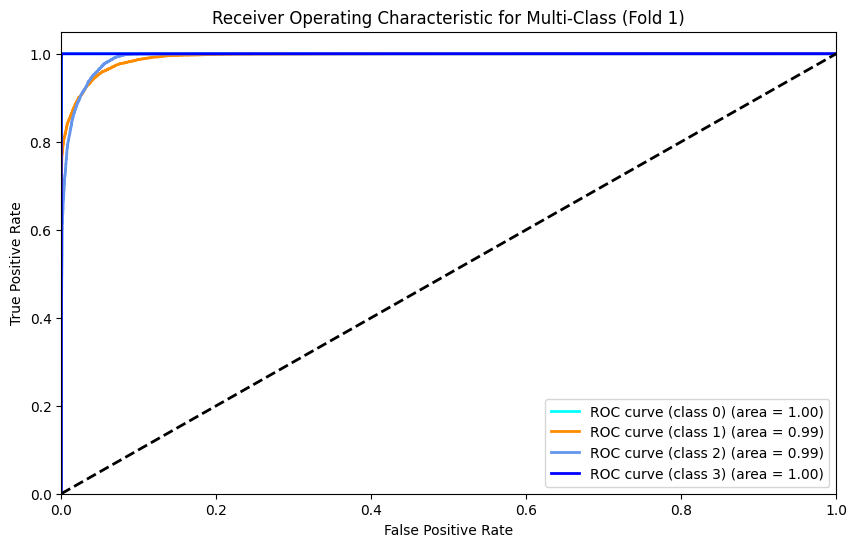


=== FOLD 1 TEST RESULTS ===
Test Loss: 0.064628
Quantum Test RMSE: 0.009015
Quantum Test MAE: 0.006464
Quantum Confidence Interval: 0.000077
Quantum Correlation Coefficient: 0.9689
ROC AUC: 0.9964
Test loss goal achieved!

=== Fold 2/2 ===
Train data shape: (46758, 32), Train labels shape: (46758,)
Val data shape: (46758, 32), Val labels shape: (46758,)
Fold 2 - Train samples: 46502, Val samples: 46502
Train class distribution: {0: 12207, 1: 12232, 2: 12258, 3: 10061}
Val class distribution: {0: 12217, 1: 12470, 2: 12053, 3: 10018}
Using lightning.gpu device for quantum circuit
Model initialized on cuda:0


Fold 2 Epoch 1: 100%|██████████| 727/727 [02:47<00:00,  4.33it/s]


Sample pred_probs (first 5 samples):
[[3.2487190e-03 8.5783118e-01 1.3873273e-01 1.8741579e-04]
 [1.9166638e-03 7.8391826e-01 2.1396457e-01 2.0058641e-04]
 [2.2833850e-03 7.7632689e-01 2.2116318e-01 2.2657485e-04]
 [6.2279678e-03 8.6846846e-01 1.2506446e-01 2.3911585e-04]
 [5.4887766e-03 8.5321295e-01 1.4106487e-01 2.3342062e-04]]

=== Per-Class Metrics ===
Class 0: Precision=0.9763, Recall=0.9669, F1=0.9716
Class 1: Precision=0.8090, Recall=0.9037, F1=0.8537
Class 2: Precision=0.9134, Recall=0.8040, F1=0.8552
Class 3: Precision=0.9920, Recall=0.9992, F1=0.9956
Classifier weight norm: 24.0041
Fold 2 Epoch 1: Train Loss=0.564488, Val Loss=0.215495, Quantum RMSE=0.046955, Quantum MAE=0.038165, Quantum Conf Interval=0.000338, Quantum Correlation=0.6929, ROC AUC=0.9871
Saved best model at fold 2 epoch 1 with Val Loss=0.215495


Fold 2 Epoch 2: 100%|██████████| 727/727 [02:47<00:00,  4.33it/s]


Sample pred_probs (first 5 samples):
[[1.5675847e-05 1.8892841e-01 8.1105232e-01 3.5714284e-06]
 [4.8985230e-06 1.1799166e-01 8.8200128e-01 2.2251184e-06]
 [6.4895526e-06 1.0251088e-01 8.9748001e-01 2.6312850e-06]
 [4.3814165e-05 1.6733855e-01 8.3261251e-01 5.0969315e-06]
 [2.8554887e-05 1.3547599e-01 8.6449134e-01 4.1026256e-06]]

=== Per-Class Metrics ===
Class 0: Precision=0.9935, Recall=0.9977, F1=0.9956
Class 1: Precision=0.9043, Recall=0.8871, F1=0.8956
Class 2: Precision=0.8853, Recall=0.9007, F1=0.8929
Class 3: Precision=1.0000, Recall=0.9979, F1=0.9990
Classifier weight norm: 24.0731
Fold 2 Epoch 2: Train Loss=0.276179, Val Loss=0.112020, Quantum RMSE=0.028713, Quantum MAE=0.022595, Quantum Conf Interval=0.000240, Quantum Correlation=0.7735, ROC AUC=0.9930
Saved best model at fold 2 epoch 2 with Val Loss=0.112020


Fold 2 Epoch 3: 100%|██████████| 727/727 [02:47<00:00,  4.33it/s]


Sample pred_probs (first 5 samples):
[[8.1291631e-07 5.7099216e-02 9.4289982e-01 1.7136551e-07]
 [4.3960316e-07 5.2495260e-02 9.4750410e-01 2.3187208e-07]
 [5.3687472e-07 4.4602644e-02 9.5539659e-01 2.5714391e-07]
 [1.3651616e-06 4.0487889e-02 9.5951062e-01 1.6876129e-07]
 [9.4007521e-07 3.6346298e-02 9.6365255e-01 1.5471848e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9985, Recall=0.9995, F1=0.9990
Class 1: Precision=0.9152, Recall=0.9091, F1=0.9121
Class 2: Precision=0.9048, Recall=0.9136, F1=0.9092
Class 3: Precision=1.0000, Recall=0.9957, F1=0.9978
Classifier weight norm: 24.2102
Fold 2 Epoch 3: Train Loss=0.111586, Val Loss=0.069808, Quantum RMSE=0.010145, Quantum MAE=0.007321, Quantum Conf Interval=0.000092, Quantum Correlation=0.9559, ROC AUC=0.9955
Saved best model at fold 2 epoch 3 with Val Loss=0.069808


Fold 2 Epoch 4: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[1.6444648e-07 1.7337054e-02 9.8266268e-01 3.5502978e-08]
 [1.1586136e-07 1.6764946e-02 9.8323488e-01 5.9499655e-08]
 [1.5048562e-07 1.2954764e-02 9.8704499e-01 7.4291528e-08]
 [3.5919936e-07 1.0218518e-02 9.8978108e-01 4.9015117e-08]
 [2.2495207e-07 8.6686658e-03 9.9133110e-01 3.9537721e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9982, Recall=0.9997, F1=0.9989
Class 1: Precision=0.8830, Recall=0.9355, F1=0.9085
Class 2: Precision=0.9277, Recall=0.8707, F1=0.8983
Class 3: Precision=1.0000, Recall=0.9966, F1=0.9983
Classifier weight norm: 24.2919
Fold 2 Epoch 4: Train Loss=0.071393, Val Loss=0.082428, Quantum RMSE=0.009001, Quantum MAE=0.006385, Quantum Conf Interval=0.000082, Quantum Correlation=0.9654, ROC AUC=0.9953


Fold 2 Epoch 5: 100%|██████████| 727/727 [02:47<00:00,  4.34it/s]


Sample pred_probs (first 5 samples):
[[2.8825854e-08 3.3431999e-02 9.6656799e-01 6.5124035e-09]
 [2.2924125e-08 1.0145024e-02 9.8985493e-01 6.0076211e-09]
 [3.1174228e-08 6.4467373e-03 9.9355328e-01 7.4913249e-09]
 [6.5712960e-08 8.8923387e-03 9.9110758e-01 9.0457100e-09]
 [4.1487937e-08 5.9818486e-03 9.9401808e-01 6.1505849e-09]]

=== Per-Class Metrics ===
Class 0: Precision=0.9990, Recall=0.9980, F1=0.9985
Class 1: Precision=0.8883, Recall=0.9376, F1=0.9123
Class 2: Precision=0.9292, Recall=0.8787, F1=0.9033
Class 3: Precision=1.0000, Recall=0.9963, F1=0.9981
Classifier weight norm: 24.4094
Fold 2 Epoch 5: Train Loss=0.064741, Val Loss=0.076351, Quantum RMSE=0.009082, Quantum MAE=0.006541, Quantum Conf Interval=0.000079, Quantum Correlation=0.9681, ROC AUC=0.9957
Early stopping at fold 2 epoch 5

Loading best model from fold 2 epoch 3 for testing...
Fold 2 Batch 0: quantum pred min: -2.376953125, max: 1.0576171875
Fold 2 Batch 1: quantum pred min: -1.3056640625, max: 0.7861328125
Fol

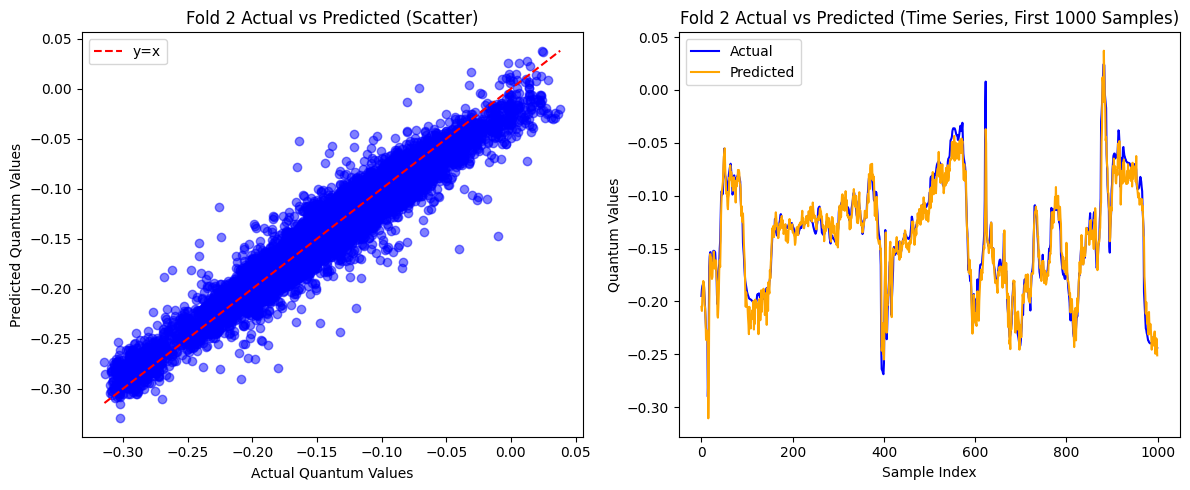

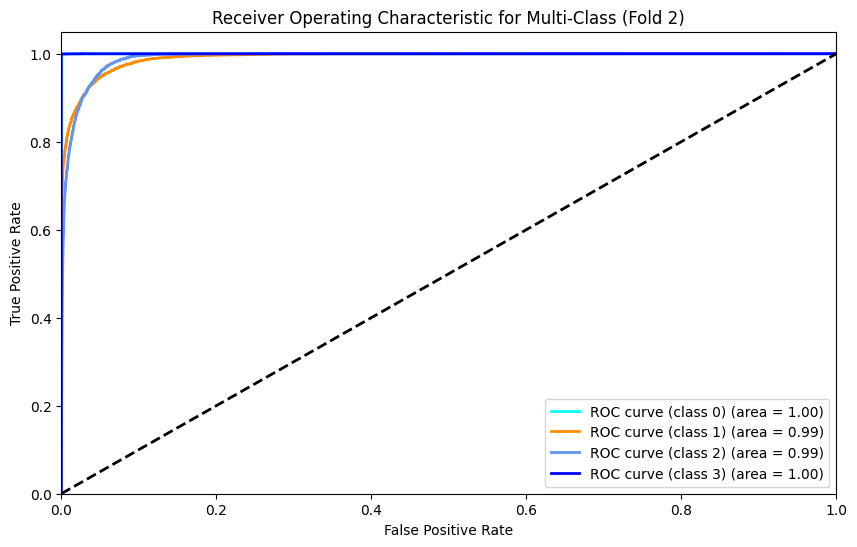


=== FOLD 2 TEST RESULTS ===
Test Loss: 0.069808
Quantum Test RMSE: 0.010145
Quantum Test MAE: 0.007321
Quantum Confidence Interval: 0.000092
Quantum Correlation Coefficient: 0.9559
ROC AUC: 0.9955
Test loss goal achieved!

=== CROSS-VALIDATION SUMMARY ===
Average Test Loss: 0.067218
Average Quantum Correlation: 0.9624
Average ROC AUC: 0.9960
Fold 1: Test Loss=0.064628, Quantum Correlation=0.9689, ROC AUC=0.9964
Fold 2: Test Loss=0.069808, Quantum Correlation=0.9559, ROC AUC=0.9955

=== BEST FOLD SELECTED ===
Best Fold: 1
Test Loss: 0.064628
Quantum Test RMSE: 0.009015
Quantum Test MAE: 0.006464
Quantum Confidence Interval: 0.000077
Quantum Correlation Coefficient: 0.9689
ROC AUC: 0.9964
Best model weights saved at: best_model_fold1.pth


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import gc
import warnings
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import pywt
import pennylane as qml
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import PowerTransformer, label_binarize
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import cycle
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.transformer")

# Optimize CUDA settings
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.set_float32_matmul_precision('high')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

DATASET_PATH = "/kaggle/input/arrythimia/Dataset_Fourtype.csv"

def bandpass_filter(data, lowcut=0.3, highcut=50.0, fs=360.0, order=5):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data, axis=0)
    return filtered

def mad(data):
    return np.median(np.abs(data - np.median(data)))

def wavelet_denoise(data, wavelet='db8', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = mad(coeffs[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=uthresh, mode='soft')
    return pywt.waverec(coeffs, wavelet)

def align_r_peaks(data, fs=360.0, window=250):
    aligned_data = []
    for i in range(0, len(data) - window, window):
        segment = data[i:i+window]
        peaks, _ = find_peaks(segment[:, 0], height=0.5, distance=int(fs/3))
        if len(peaks) > 0:
            r_peak = peaks[0]
            start = max(0, r_peak - window//2)
            end = start + window
            if end <= len(segment):
                aligned_data.append(segment[start:end])
            else:
                aligned_data.append(segment[-window:])
        else:
            aligned_data.append(segment)
    return np.array(aligned_data).reshape(-1, data.shape[1])

def add_baseline_wander(data, amplitude=0.1, frequency=0.5, fs=360.0):
    t = np.arange(len(data)) / fs
    wander = amplitude * np.sin(2 * np.pi * frequency * t)
    return data + wander[:, np.newaxis]

def add_muscle_artifact(data, amplitude=0.05, fs=360.0):
    t = np.arange(len(data)) / fs
    noise = amplitude * np.random.randn(len(data))
    return data + noise[:, np.newaxis]

class iTransformer(nn.Module):
    def __init__(self, num_variates, seq_len, pred_len, n_classes, hidden_size=512, num_heads=8, num_layers=4, dropout=0.3, ffn_multiplier=4, activation='gelu', device='cuda:0'):
        super().__init__()
        self.num_variates = num_variates
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.device = torch.device(device)
        
        self.proj_in = nn.Linear(num_variates, hidden_size)
        self.pos_enc = PositionalEncoding(hidden_size)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=ffn_multiplier * hidden_size,
                dropout=dropout,
                activation=activation,
                batch_first=True
            ),
            num_layers=num_layers
        )
        
        self.quantum_head = nn.Linear(hidden_size * seq_len, hidden_size)
        self.classifier_head = nn.Linear(hidden_size * seq_len, hidden_size)
        self.quantum_output = nn.Linear(hidden_size, 1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 2, n_classes)
        )
        
        self.num_qubits = 16
        self.quantum_proj = nn.Linear(self.num_qubits, self.num_qubits)
        self.num_layers = 5
        try:
            self.dev = qml.device("lightning.gpu", wires=self.num_qubits)
            print("Using lightning.gpu device for quantum circuit")
        except Exception as e:
            print(f"Failed to initialize lightning.gpu: {e}")
            self.dev = qml.device("default.qubit", wires=self.num_qubits)
            print("Falling back to default.qubit device for quantum circuit")
        self.fallback_layer = nn.Linear(self.num_qubits, self.num_qubits)
        
        @qml.qnode(self.dev, interface='torch', diff_method='parameter-shift')
        def quantum_circuit(inputs, weights):
            inputs = inputs / (torch.max(torch.abs(inputs), dim=-1, keepdim=True)[0] + 1e-8)
            if torch.any(torch.isnan(inputs)) or torch.any(torch.isinf(inputs)):
                inputs = torch.clamp(inputs, -1.0, 1.0)
            for layer in range(self.num_layers):
                for i in range(self.num_qubits):
                    qml.RX(inputs[:, i], wires=i)
                    qml.RY(weights[layer, i, 0], wires=i)
                    qml.RZ(weights[layer, i, 1], wires=i)
                for i in range(self.num_qubits - 1):
                    qml.CNOT(wires=[i, i+1])
            measurements = [qml.expval(qml.PauliZ(i)) for i in range(self.num_qubits)]
            return torch.stack(measurements).T

        self.quantum_circuit = quantum_circuit
        weight_shapes = (self.num_layers, self.num_qubits, 2)
        self.weights = nn.Parameter(torch.randn(weight_shapes) * 0.1, requires_grad=True).to(self.device)
        self.quantum_dropout = nn.Dropout(dropout)
        self.quantum_post = nn.Linear(self.num_qubits, 1).to(self.device)
        self.quantum_scale = nn.Parameter(torch.tensor(5.0)).to(self.device)

    def forward(self, x):
        if x.shape[-1] != self.num_variates:
            raise ValueError(f"Input variates {x.shape[-1]} do not match expected {self.num_variates}")
        
        with autocast('cuda', dtype=torch.float16):
            x_trans = self.proj_in(x)
            x_trans = self.pos_enc(x_trans)
            x_trans = self.encoder(x_trans)
            x_trans = x_trans.reshape(x_trans.size(0), -1)
        
        quantum_branch = self.quantum_head(x_trans)
        with autocast('cuda', dtype=torch.float16):
            quantum_out = self.quantum_output(quantum_branch)
            inputs_quantum = x[:, :, :min(x.shape[-1], self.num_qubits)]
            inputs_quantum = self.quantum_proj(inputs_quantum[:, -1, :]).to(device=self.device, dtype=torch.float32)
            try:
                quantum_outputs = self.quantum_circuit(inputs_quantum, self.weights)
            except Exception as e:
                quantum_outputs = self.fallback_layer(inputs_quantum)
            quantum_outputs = self.quantum_dropout(quantum_outputs)
            pred_quantum = quantum_out + self.quantum_post(quantum_outputs) * self.quantum_scale
        
        class_branch = self.classifier_head(x_trans.float())
        class_logits = self.classifier(class_branch)
        class_logits = torch.clamp(class_logits, min=-10.0, max=10.0)
        pred_probs = F.softmax(class_logits, dim=1)
        pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
        
        return pred_quantum.flatten(), pred_probs

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[..., 0::2] = torch.sin(position * div_term)
        pe[..., 1::2] = torch.cos(position * div_term)
        self.pe = nn.Parameter(pe, requires_grad=False)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class ECG_loss(nn.Module):
    def __init__(self, quantum_weight=0.4, class_weight=0.6):
        super().__init__()
        self.huber = nn.HuberLoss()
        self.class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
        self.cross_entropy = nn.CrossEntropyLoss(weight=self.class_weights)
        self.quantum_weight = quantum_weight
        self.class_weight = class_weight

    def forward(self, pred_quantum, target_quantum, pred_probs, target_class):
        quantum_loss = self.huber(pred_quantum, target_quantum)
        class_loss = self.cross_entropy(pred_probs.log(), target_class)
        return self.quantum_weight * quantum_loss + self.class_weight * class_loss

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len, labels=None):
        self.features = data.values.astype(np.float32)
        self.labels = labels.astype(np.int64) if labels is not None else None
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_samples = len(data) - seq_len - pred_len + 1
        if self.num_samples <= 0:
            raise ValueError(f"Insufficient data: num_samples = {self.num_samples}")
        rng = np.random.default_rng()
        noise1 = rng.normal(0, 0.1, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        scale = rng.uniform(0.8, 1.2, (self.num_samples, 1, 1)).astype(np.float32)
        noise2 = rng.normal(0, 0.05, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        warp_factor = rng.uniform(0.9, 1.1, self.num_samples).astype(np.float32)
        self.augmented = []
        time_orig = np.linspace(0, 1, seq_len)
        for idx in range(self.num_samples):
            x = self.features[idx:idx + seq_len]
            x = add_baseline_wander(x)
            x = add_muscle_artifact(x)
            time_warped = np.linspace(0, 1, seq_len) * warp_factor[idx]
            time_warped = time_warped / time_warped[-1] * time_orig[-1]
            x_warped = np.zeros_like(x)
            for v in range(x.shape[1]):
                interp = interp1d(time_orig, x[:, v], kind='linear', fill_value="extrapolate")
                x_warped[:, v] = interp(time_warped)
            t = np.linspace(0, 1, seq_len)
            wander = 0.05 * np.sin(2 * np.pi * 0.5 * t)
            x = x_warped + wander[:, None] + noise1[idx]
            x = x * scale[idx] + noise2[idx]
            if rng.random() > 0.5:
                crop_start = rng.integers(0, seq_len // 10)
                x = x[crop_start:crop_start + seq_len] if crop_start + seq_len <= len(x) else x
            x = np.clip(x, -5, 5)
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Warning: NaN or Inf in augmented data at index {idx}")
                x = np.nan_to_num(x, nan=0.0, posinf=5.0, neginf=-5.0)
            self.augmented.append(x)
        all_data = self.features[self.seq_len:self.seq_len + self.num_samples, :]
        self.quantum_targets = np.mean(all_data, axis=1).astype(np.float32)
        if self.labels is not None:
            self.labels = self.labels[self.seq_len:self.seq_len + self.num_samples]

    def __len__(self):
        return max(0, self.num_samples)
    
    def __getitem__(self, idx):
        idx = idx % self.num_samples
        x = self.augmented[idx]
        y_quantum = self.quantum_targets[idx]
        y_label = self.labels[idx] if self.labels is not None else -1
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_quantum, dtype=torch.float32), torch.tensor(y_label, dtype=torch.int64)

def calculate_metrics(true_quantum, pred_quantum):
    rmse = torch.sqrt(torch.mean((true_quantum - pred_quantum)**2))
    mae = torch.mean(torch.abs(true_quantum - pred_quantum))
    std_error = torch.std(true_quantum - pred_quantum)
    z_score = 1.96
    conf_interval = z_score * std_error / np.sqrt(true_quantum.size(0))
    true_range = torch.clamp(torch.max(true_quantum) - torch.min(true_quantum), min=1e-6)
    threshold = 0.3 * true_range
    abs_error = torch.abs(true_quantum - pred_quantum)
    accuracy_percentage = torch.mean((abs_error < threshold).float()) * 100
    corr_coef, _ = pearsonr(true_quantum.cpu().numpy(), pred_quantum.cpu().numpy())
    return {
        'Quantum_RMSE': rmse.item(),
        'Quantum_MAE': mae.item(),
        'Quantum_Conf_Interval': conf_interval.item(),
        'Quantum_Accuracy_Percentage': accuracy_percentage.item(),
        'Quantum_Correlation': corr_coef
    }

def get_optimizer(model, optimizer_type, lr, weight_decay):
    if optimizer_type.lower() == 'adamw':
        return optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            amsgrad=False,
            betas=(0.9, 0.999),
            eps=1e-8,
            maximize=False,
            foreach=False,
            fused=False,
            capturable=False,
            differentiable=False
        )
    elif optimizer_type.lower() == 'adam':
        return optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            amsgrad=False,
            betas=(0.9, 0.999),
            eps=1e-8,
            maximize=False,
            foreach=False,
            fused=False,
            capturable=False,
            differentiable=False
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_type}")

def get_scheduler(optimizer, scheduler_type, warmup_epochs, total_epochs):
    if scheduler_type.lower() == 'cosine':
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        return LambdaLR(optimizer, lr_lambda)
    elif scheduler_type.lower() == 'reduce_on_plateau':
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_type}")

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device: {device}")

    try:
        raw_data = pd.read_csv(DATASET_PATH)
        raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        raw_data.dropna(inplace=True)
        print(f"Raw data shape after dropping NaN: {raw_data.shape}")
    except Exception as e:
        raise ValueError(f"Error loading dataset: {e}")

    original_n_rows = raw_data.shape[0]
    lead0_columns = [col for col in raw_data.columns if col.startswith('0_') or col == 'type']
    raw_data = raw_data[lead0_columns]
    print(f"Data shape after selecting Lead 0: {raw_data.shape}")

    if 'type' in raw_data.columns:
        labels = raw_data['type'].values
        filtered_data = raw_data.drop(columns=['type']).values
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_classes = len(unique_labels)
        print("\n=== Class Label Distribution ===")
        for label, count in zip(unique_labels, counts):
            print(f"Label {int(label)}: {count} samples")
        class_weights = {}
        n_samples = len(labels)
        for label, count in zip(unique_labels, counts):
            weight = n_samples / (n_classes * count)
            class_weights[int(label)] = weight
        print(f"Class weights: {class_weights}")
    else:
        filtered_data = raw_data.values
        labels = None
        n_classes = 0
        print("No 'type' column found, proceeding without labels.")

    print(f"Initial filtered_data shape: {filtered_data.shape}, labels shape: {labels.shape if labels is not None else 'None'}")

    filtered_data = np.apply_along_axis(wavelet_denoise, 0, filtered_data)
    filtered_data = bandpass_filter(filtered_data)
    filtered_data = np.clip(filtered_data, np.percentile(filtered_data, 2), np.percentile(filtered_data, 98))
    filtered_df = pd.DataFrame(filtered_data, columns=[f"lead0_{i}" for i in range(filtered_data.shape[1])])
    filtered_df = filtered_df.rolling(window=3).mean().bfill()
    filtered_df = filtered_df.iloc[:original_n_rows]
    print(f"filtered_df shape after rolling: {filtered_df.shape}")

    data_ma = filtered_df.rolling(window=5).mean().bfill()
    data_ma.columns = [f"{col}_ma" for col in filtered_df.columns]
    data_ma = data_ma.iloc[:original_n_rows]
    enhanced_data = pd.concat([filtered_df, data_ma], axis=1)
    print(f"Enhanced data shape: {enhanced_data.shape}, num_variates: {enhanced_data.shape[1]}")

    scaler_yeo = PowerTransformer(method='yeo-johnson', standardize=True)
    norm_data = scaler_yeo.fit_transform(enhanced_data)
    norm_data = np.nan_to_num(norm_data, nan=0.0, posinf=5.0, neginf=-5.0)
    norm_data = np.clip(norm_data, -10.0, 10.0)
    norm_data = pd.DataFrame(norm_data, columns=enhanced_data.columns)
    print(f"norm_data shape: {norm_data.shape}, labels shape: {labels.shape if labels is not None else 'None'}")

    all_data = enhanced_data.values
    quantum_targets = np.mean(all_data, axis=1)
    quantum_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    quantum_targets = quantum_scaler.fit_transform(quantum_targets.reshape(-1, 1)).flatten()
    quantum_targets = np.nan_to_num(quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
    quantum_targets = np.clip(quantum_targets, -10.0, 10.0)
    quantum_targets_min = quantum_targets.min()
    quantum_targets_max = quantum_targets.max()
    quantum_targets_range = quantum_targets_max - quantum_targets_min if quantum_targets_max != quantum_targets_min else 1
    quantum_targets = 2 * (quantum_targets - quantum_targets_min) / quantum_targets_range - 1
    print(f"Quantum targets range: [{quantum_targets.min():.4f}, {quantum_targets.max():.4f}]")

    print(f"Number of Target Values: {len(quantum_targets)}")
    print(f"Target Value Name: Quantum Target (Mean of Lead 0 Attributes)")

    if labels is not None and norm_data.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: norm_data has {norm_data.shape[0]} rows, but labels has {labels.shape[0]} rows.")

    config = {
        'num_variates': norm_data.shape[1],
        'seq_len': 256,
        'pred_len': 1,
        'hidden_size': 512,
        'num_heads': 8,
        'num_layers': 4,
        'dropout': 0.3,
        'lr': 2e-4,
        'batch_size': 64,
        'epochs': 80,
        'patience': 2,
        'grad_clip': 1.0,
        'warmup_epochs': 10,
        'grad_accum_steps': 1,
        'n_splits': 2,
        'min_samples': 299,
        'num_workers': 4,
        'optimizer': 'adamw',
        'weight_decay': 5e-3,
        'scheduler_type': 'cosine',
        'activation': 'gelu',
        'ffn_multiplier': 4,
        'quantum_weight': 0.4,
        'class_weight': 0.6
    }

    kf = KFold(n_splits=config['n_splits'], shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(enhanced_data)):
        print(f"\n=== Fold {fold+1}/{config['n_splits']} ===")
        train_data = enhanced_data.iloc[train_idx]
        val_data = enhanced_data.iloc[val_idx]
        train_labels = labels[train_idx] if labels is not None else None
        val_labels = labels[val_idx] if labels is not None else None
        print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape if train_labels is not None else 'None'}")
        print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape if val_labels is not None else 'None'}")

        scaler_yeo_train = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_train = scaler_yeo_train.fit_transform(train_data)
        norm_train = np.nan_to_num(norm_train, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_train = np.clip(norm_train, -10.0, 10.0)
        norm_train = pd.DataFrame(norm_train, columns=enhanced_data.columns)

        scaler_yeo_val = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_val = scaler_yeo_val.fit_transform(val_data)
        norm_val = np.nan_to_num(norm_val, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_val = np.clip(norm_val, -10.0, 10.0)
        norm_val = pd.DataFrame(norm_val, columns=enhanced_data.columns)

        quantum_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        train_quantum_targets = quantum_scaler.fit_transform(quantum_targets[train_idx].reshape(-1, 1)).flatten()
        train_quantum_targets = np.nan_to_num(train_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        train_quantum_targets = np.clip(train_quantum_targets, -10.0, 10.0)
        train_quantum_targets_min = train_quantum_targets.min()
        train_quantum_targets_max = train_quantum_targets.max()
        train_quantum_targets_range = train_quantum_targets_max - train_quantum_targets_min if train_quantum_targets_max != train_quantum_targets_min else 1
        train_quantum_targets = 2 * (train_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1

        val_quantum_targets = quantum_scaler.transform(quantum_targets[val_idx].reshape(-1, 1)).flatten()
        val_quantum_targets = np.nan_to_num(val_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        val_quantum_targets = np.clip(val_quantum_targets, -10.0, 10.0)
        val_quantum_targets = 2 * (val_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1

        try:
            train_dataset = TimeSeriesDataset(norm_train, config['seq_len'], config['pred_len'], train_labels)
            val_dataset = TimeSeriesDataset(norm_val, config['seq_len'], config['pred_len'], val_labels)
            print(f"Fold {fold+1} - Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        except Exception as e:
            print(f"Error creating datasets for fold {fold+1}: {e}. Skipping fold.")
            continue

        if train_labels is not None:
            train_class_dist = {}
            unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
            for label, count in zip(unique_train_labels, train_counts):
                train_class_dist[int(label)] = count
            print(f"Train class distribution: {train_class_dist}")
        if val_labels is not None:
            val_class_dist = {}
            unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
            for label, count in zip(unique_val_labels, val_counts):
                val_class_dist[int(label)] = count
            print(f"Val class distribution: {val_class_dist}")

        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )

        if len(train_loader) == 0:
            print(f"Train loader empty for fold {fold+1}. Skipping fold.")
            continue

        try:
            model = iTransformer(
                num_variates=config['num_variates'],
                seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                n_classes=n_classes,
                hidden_size=config['hidden_size'],
                num_heads=config['num_heads'],
                num_layers=config['num_layers'],
                dropout=config['dropout'],
                ffn_multiplier=config['ffn_multiplier'],
                activation=config['activation'],
                device=device
            ).to(device)
            print(f"Model initialized on {device}")
        except Exception as e:
            print(f"Error initializing model for fold {fold+1}: {e}. Skipping fold.")
            continue

        param_groups = [
            {
                'params': [p for n, p in model.named_parameters() if 'weights' in n],
                'lr': 5e-6,
                'weight_decay': 1e-2,
                'amsgrad': False,
                'betas': (0.9, 0.999),
                'eps': 1e-8,
                'maximize': False,
                'foreach': False,
                'fused': False,
                'capturable': False,
                'differentiable': False
            },
            {
                'params': [p for n, p in model.named_parameters() if 'classifier' in n and 'weights' not in n],
                'lr': 1e-4,
                'weight_decay': 1e-3,
                'amsgrad': False,
                'betas': (0.9, 0.999),
                'eps': 1e-8,
                'maximize': False,
                'foreach': False,
                'fused': False,
                'capturable': False,
                'differentiable': False
            },
            {
                'params': [p for n, p in model.named_parameters() if 'classifier' not in n and 'weights' not in n],
                'lr': config['lr'],
                'weight_decay': config['weight_decay'],
                'amsgrad': False,
                'betas': (0.9, 0.999),
                'eps': 1e-8,
                'maximize': False,
                'foreach': False,
                'fused': False,
                'capturable': False,
                'differentiable': False
            }
        ]
        optimizer = get_optimizer(model, config['optimizer'], config['lr'], config['weight_decay'])
        optimizer.param_groups = param_groups  # Override default param groups
        scheduler = get_scheduler(optimizer, config['scheduler_type'], config['warmup_epochs'], config['epochs'])
        criterion = ECG_loss(quantum_weight=config['quantum_weight'], class_weight=config['class_weight']).to(device)
        grad_scaler = GradScaler('cuda')

        best_val_loss = float('inf')
        best_epoch = 0
        patience_counter = 0
        train_losses, val_losses, quantum_rmses, quantum_maes = [], [], [], []

        for epoch in range(config['epochs']):
            model.train()
            train_loss = 0
            for batch_idx, (x, y_quantum, y_label) in enumerate(tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}")):
                x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with autocast('cuda', dtype=torch.float16):
                    pred_quantum, pred_probs = model(x)
                    loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                grad_scaler.scale(loss).backward()
                if (batch_idx + 1) % config['grad_accum_steps'] == 0 or (batch_idx + 1) == len(train_loader):
                    torch.nn.utils.clip_grad_norm_([p for n, p in model.named_parameters() if 'weights' not in n], config['grad_clip'])
                    torch.nn.utils.clip_grad_norm_([p for n, p in model.named_parameters() if 'weights' in n], 0.3)
                    grad_scaler.step(optimizer)
                    grad_scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                train_loss += loss.item()
                del x, y_quantum, y_label, pred_quantum, pred_probs, loss
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0
            pred_quantums, true_quantums, pred_probs_list, true_labels_list = [], [], [], []
            with torch.no_grad():
                for x, y_quantum, y_label in val_loader:
                    x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                    pred_quantum, pred_probs = model(x)
                    with autocast('cuda', dtype=torch.float16):
                        loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                    val_loss += loss.item()
                    pred_quantums.append(pred_quantum.cpu())
                    true_quantums.append(y_quantum.cpu())
                    prob_sums = pred_probs.sum(dim=1)
                    if not torch.allclose(prob_sums, torch.ones_like(prob_sums), rtol=1e-6, atol=1e-6):
                        max_deviation = (prob_sums - 1.0).abs().max().item()
                        print(f"Warning: Probabilities do not sum to 1 in batch, max deviation: {max_deviation}")
                        pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
                    if len(pred_probs_list) == 0:
                        print(f"Sample pred_probs (first 5 samples):\n{pred_probs[:5].cpu().numpy()}")
                    pred_probs_list.append(pred_probs.cpu())
                    true_labels_list.append(y_label.cpu())
                    del x, y_quantum, y_label, pred_quantum, pred_probs, loss
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            pred_quantums = torch.cat(pred_quantums)
            true_quantums = torch.cat(true_quantums)
            pred_probs = torch.cat(pred_probs_list)
            true_labels = torch.cat(true_labels_list)
            pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            quantum_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
            quantum_rmse = quantum_metrics['Quantum_RMSE']
            quantum_mae = quantum_metrics['Quantum_MAE']
            quantum_conf_interval = quantum_metrics['Quantum_Conf_Interval']
            quantum_corr = quantum_metrics['Quantum_Correlation']
            pred_probs_np = pred_probs.cpu().numpy()
            true_labels_np = true_labels.cpu().numpy()
            prob_sums_np = pred_probs_np.sum(axis=1)
            if not np.allclose(prob_sums_np, 1.0, rtol=1e-6, atol=1e-6):
                print(f"Warning: Final probabilities do not sum to 1, max deviation: {np.abs(prob_sums_np - 1.0).max()}")
                pred_probs_np = pred_probs_np / (pred_probs_np.sum(axis=1, keepdims=True) + 1e-10)
            try:
                roc_auc = roc_auc_score(true_labels_np, pred_probs_np, multi_class='ovr')
            except ValueError as e:
                print(f"Error computing ROC AUC: {e}. Skipping ROC AUC for this fold.")
                roc_auc = float('nan')
            pred_labels = np.argmax(pred_probs_np, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels_np, pred_labels, average=None, labels=range(n_classes))
            print("\n=== Per-Class Metrics ===")
            for i in range(n_classes):
                print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")
            classifier_weight_norm = sum(p.norm().item() for n, p in model.named_parameters() if 'classifier' in n)
            print(f"Classifier weight norm: {classifier_weight_norm:.4f}")
            quantum_rmses.append(quantum_rmse)
            quantum_maes.append(quantum_mae)

            if config['scheduler_type'] == 'reduce_on_plateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()

            print(f"Fold {fold+1} Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}, "
                  f"Quantum RMSE={quantum_rmse:.6f}, Quantum MAE={quantum_mae:.6f}, "
                  f"Quantum Conf Interval={quantum_conf_interval:.6f}, "
                  f"Quantum Correlation={quantum_corr:.4f}, ROC AUC={roc_auc:.4f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model_fold{fold+1}.pth")
                print(f"Saved best model at fold {fold+1} epoch {epoch+1} with Val Loss={best_val_loss:.6f}")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config['patience']:
                    print(f"Early stopping at fold {fold+1} epoch {epoch+1}")
                    break

        print(f"\nLoading best model from fold {fold+1} epoch {best_epoch} for testing...")
        state_dict = torch.load(f"best_model_fold{fold+1}.pth", weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        val_loss = 0
        pred_quantums, true_quantums, pred_probs_list, true_labels_list = [], [], [], []
        with torch.no_grad():
            for batch_idx, (x, y_quantum, y_label) in enumerate(val_loader):
                x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                pred_quantum, pred_probs = model(x)
                with autocast('cuda', dtype=torch.float16):
                    loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                val_loss += loss.item()
                pred_quantums.append(pred_quantum.cpu())
                true_quantums.append(y_quantum.cpu())
                prob_sums = pred_probs.sum(dim=1)
                if not torch.allclose(prob_sums, torch.ones_like(prob_sums), rtol=1e-6, atol=1e-6):
                    max_deviation = (prob_sums - 1.0).abs().max().item()
                    print(f"Warning: Probabilities do not sum to 1 in test batch {batch_idx}, max deviation: {max_deviation}")
                    pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
                pred_probs_list.append(pred_probs.cpu())
                true_labels_list.append(y_label.cpu())
                print(f"Fold {fold+1} Batch {batch_idx}: quantum pred min: {pred_quantum.min().item()}, max: {pred_quantum.max().item()}")
                del x, y_quantum, y_label, pred_quantum, pred_probs, loss
        val_loss /= len(val_loader)
        pred_quantums = torch.cat(pred_quantums)
        true_quantums = torch.cat(true_quantums)
        pred_probs = torch.cat(pred_probs_list)
        true_labels = torch.cat(true_labels_list)
        pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        test_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
        quantum_test_rmse = test_metrics['Quantum_RMSE']
        quantum_test_mae = test_metrics['Quantum_MAE']
        quantum_conf_interval = test_metrics['Quantum_Conf_Interval']
        quantum_corr = test_metrics['Quantum_Correlation']
        pred_probs_np = pred_probs.cpu().numpy()
        true_labels_np = true_labels.cpu().numpy()
        prob_sums_np = pred_probs_np.sum(axis=1)
        if not np.allclose(prob_sums_np, 1.0, rtol=1e-6, atol=1e-6):
            print(f"Warning: Final test probabilities do not sum to 1, max deviation: {np.abs(prob_sums_np - 1.0).max()}")
            pred_probs_np = pred_probs_np / (pred_probs_np.sum(axis=1, keepdims=True) + 1e-10)
        try:
            roc_auc = roc_auc_score(true_labels_np, pred_probs_np, multi_class='ovr')
        except ValueError as e:
            print(f"Error computing ROC AUC in test: {e}. Setting ROC AUC to NaN.")
            roc_auc = float('nan')

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(true_quantums_denorm, pred_quantums_denorm, alpha=0.5, color='blue')
        plt.plot([min(true_quantums_denorm), max(true_quantums_denorm)], 
                 [min(true_quantums_denorm), max(true_quantums_denorm)], 'r--', label='y=x')
        plt.xlabel('Actual Quantum Values')
        plt.ylabel('Predicted Quantum Values')
        plt.title(f'Fold {fold+1} Actual vs Predicted (Scatter)')
        plt.legend()

        time_series_length = min(1000, len(true_quantums_denorm))
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(time_series_length), true_quantums_denorm[:time_series_length], label='Actual', color='blue')
        plt.plot(np.arange(time_series_length), pred_quantums_denorm[:time_series_length], label='Predicted', color='orange')
        plt.xlabel('Sample Index')
        plt.ylabel('Quantum Values')
        plt.title(f'Fold {fold+1} Actual vs Predicted (Time Series, First {time_series_length} Samples)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        true_labels_bin = label_binarize(true_labels_np, classes=range(n_classes))
        fpr = dict()
        tpr = dict()
        roc_auc_dict = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_probs_np[:, i])
            roc_auc_dict[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(10, 6))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                     label=f'ROC curve (class {i}) (area = {roc_auc_dict[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for Multi-Class (Fold {fold+1})')
        plt.legend(loc="lower right")
        plt.show()

        print(f"\n=== FOLD {fold+1} TEST RESULTS ===")
        print(f"Test Loss: {val_loss:.6f}")
        print(f"Quantum Test RMSE: {quantum_test_rmse:.6f}")
        print(f"Quantum Test MAE: {quantum_test_mae:.6f}")
        print(f"Quantum Confidence Interval: {quantum_conf_interval:.6f}")
        print(f"Quantum Correlation Coefficient: {quantum_corr:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        if val_loss < 0.5:
            print("Test loss goal achieved!")
        else:
            print("Test loss still high, consider further tuning.")

        fold_results.append({
            'fold': fold+1,
            'test_loss': val_loss,
            'quantum_rmse': quantum_test_rmse,
            'quantum_mae': quantum_test_mae,
            'quantum_conf_interval': quantum_conf_interval,
            'quantum_correlation': quantum_corr,
            'roc_auc': roc_auc
        })

        del train_dataset, val_dataset, train_loader, val_loader, model
        torch.cuda.empty_cache()
        gc.collect()

    if fold_results:
        print("\n=== CROSS-VALIDATION SUMMARY ===")
        avg_test_loss = np.mean([r['test_loss'] for r in fold_results])
        avg_quantum_correlation = np.mean([r['quantum_correlation'] for r in fold_results])
        avg_roc_auc = np.nanmean([r['roc_auc'] for r in fold_results])
        print(f"Average Test Loss: {avg_test_loss:.6f}")
        print(f"Average Quantum Correlation: {avg_quantum_correlation:.4f}")
        print(f"Average ROC AUC: {avg_roc_auc:.4f}")
        for r in fold_results:
            print(f"Fold {r['fold']}: Test Loss={r['test_loss']:.6f}, "
                  f"Quantum Correlation={r['quantum_correlation']:.4f}, ROC AUC={r['roc_auc']:.4f}")

        best_fold = min(fold_results, key=lambda x: x['test_loss'])
        print(f"\n=== BEST FOLD SELECTED ===")
        print(f"Best Fold: {best_fold['fold']}")
        print(f"Test Loss: {best_fold['test_loss']:.6f}")
        print(f"Quantum Test RMSE: {best_fold['quantum_rmse']:.6f}")
        print(f"Quantum Test MAE: {best_fold['quantum_mae']:.6f}")
        print(f"Quantum Confidence Interval: {best_fold['quantum_conf_interval']:.6f}")
        print(f"Quantum Correlation Coefficient: {best_fold['quantum_correlation']:.4f}")
        print(f"ROC AUC: {best_fold['roc_auc']:.4f}")
        print(f"Best model weights saved at: best_model_fold{best_fold['fold']}.pth")
    else:
        print("No valid folds processed. Check dataset size or split configuration.")

if __name__ == "__main__":
    main()

# Quantum-Enhanced iTransformer with RandomsearchCV & MOE

PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
Device: cuda:0
Raw data shape after dropping NaN: (93516, 17)
Data shape after selecting Lead 0: (93516, 17)

=== Class Label Distribution ===
Label 0: 24424 samples
Label 1: 24702 samples
Label 2: 24311 samples
Label 3: 20079 samples
Class weights: {0: 0.9572142155257124, 1: 0.946441583677435, 2: 0.9616634445312822, 3: 1.16435081428358}
Initial filtered_data shape: (93516, 16), labels shape: (93516,)
filtered_df shape after rolling: (93516, 16)
Enhanced data shape: (93516, 32), num_variates: 32
norm_data shape: (93516, 32), labels shape: (93516,)
Quantum targets range: [-1.0000, 1.0000]
Number of Target Values: 93516
Target Value Name: Quantum Target (Mean of Lead 0 Attributes)

=== Fold 1/2 ===
Train data shape: (46758, 32), Train labels shape: (46758,)
Val data shape: (46758, 32), Val labels shape: (46758,)
Fold 1 - Train samples: 46502, Val samples: 46502
Train class distribution: {0: 12167, 1: 12299, 2: 12159, 3:

Fold 1 Epoch 1: 100%|██████████| 727/727 [11:35<00:00,  1.04it/s]


Sample pred_probs (first 5 samples):
[[1.27261896e-02 2.96291023e-01 6.90594316e-01 3.88501561e-04]
 [1.50027275e-02 3.15704405e-01 6.68891430e-01 4.01475118e-04]
 [1.40972482e-02 3.15370321e-01 6.70127749e-01 4.04674764e-04]
 [1.06482049e-02 2.88154095e-01 7.00786829e-01 4.10841109e-04]
 [1.16233779e-02 3.12573820e-01 6.75417781e-01 3.85021471e-04]]

=== Per-Class Metrics ===
Class 0: Precision=0.9242, Recall=0.8850, F1=0.9041
Class 1: Precision=0.7823, Recall=0.8150, F1=0.7983
Class 2: Precision=0.8630, Recall=0.8545, F1=0.8587
Class 3: Precision=0.9883, Recall=1.0000, F1=0.9941
Classifier weight norm: 24.0069
Fold 1 Epoch 1: Train Loss=0.577731, Val Loss=0.218059, Quantum MSE=0.000529, Quantum RMSE=0.023007, Quantum MAE=0.017602, Quantum Correlation=0.8033, ROC AUC=0.9774
Saved best model at fold 1 epoch 1 with Val Loss=0.218059


Fold 1 Epoch 2: 100%|██████████| 727/727 [11:40<00:00,  1.04it/s]


Sample pred_probs (first 5 samples):
[[2.8319802e-04 8.5615426e-02 9.1409731e-01 4.0553819e-06]
 [3.4127600e-04 8.8746630e-02 9.1090780e-01 4.2672559e-06]
 [2.7554092e-04 8.4042013e-02 9.1567856e-01 3.9563697e-06]
 [1.8692766e-04 6.9105394e-02 9.3070388e-01 3.8334147e-06]
 [1.9740046e-04 7.1971998e-02 9.2782700e-01 3.5671626e-06]]

=== Per-Class Metrics ===
Class 0: Precision=0.9767, Recall=0.9933, F1=0.9849
Class 1: Precision=0.9043, Recall=0.8688, F1=0.8862
Class 2: Precision=0.8876, Recall=0.9055, F1=0.8964
Class 3: Precision=0.9955, Recall=0.9993, F1=0.9974
Classifier weight norm: 24.0618
Fold 1 Epoch 2: Train Loss=0.303462, Val Loss=0.136681, Quantum MSE=0.001153, Quantum RMSE=0.033963, Quantum MAE=0.027485, Quantum Correlation=0.6875, ROC AUC=0.9930
Saved best model at fold 1 epoch 2 with Val Loss=0.136681


Fold 1 Epoch 3: 100%|██████████| 727/727 [11:38<00:00,  1.04it/s]


Sample pred_probs (first 5 samples):
[[5.3736285e-06 3.5792898e-02 9.6420157e-01 1.9070254e-07]
 [7.2446228e-06 3.9922114e-02 9.6007037e-01 2.4534762e-07]
 [4.7069252e-06 3.7210725e-02 9.6278441e-01 1.9490079e-07]
 [2.2563336e-06 2.0143680e-02 9.7985393e-01 1.6403931e-07]
 [2.3877888e-06 2.2347115e-02 9.7765028e-01 1.5868594e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9980, Recall=0.9964, F1=0.9972
Class 1: Precision=0.8506, Recall=0.9568, F1=0.9006
Class 2: Precision=0.9503, Recall=0.8249, F1=0.8832
Class 3: Precision=0.9953, Recall=0.9996, F1=0.9974
Classifier weight norm: 24.1422
Fold 1 Epoch 3: Train Loss=0.138532, Val Loss=0.088911, Quantum MSE=0.000102, Quantum RMSE=0.010077, Quantum MAE=0.007263, Quantum Correlation=0.9557, ROC AUC=0.9949
Saved best model at fold 1 epoch 3 with Val Loss=0.088911


Fold 1 Epoch 4: 100%|██████████| 727/727 [11:35<00:00,  1.04it/s]


Sample pred_probs (first 5 samples):
[[8.7030952e-07 4.0493407e-03 9.9594975e-01 3.8720451e-08]
 [1.1103090e-06 3.8229572e-03 9.9617589e-01 4.5510596e-08]
 [7.1501421e-07 3.5506501e-03 9.9644852e-01 3.6907199e-08]
 [4.4832669e-07 2.0688735e-03 9.9793065e-01 4.0598017e-08]
 [4.5235498e-07 1.9979596e-03 9.9800152e-01 3.7786716e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9959, Recall=0.9999, F1=0.9979
Class 1: Precision=0.9058, Recall=0.9076, F1=0.9067
Class 2: Precision=0.9067, Recall=0.9013, F1=0.9040
Class 3: Precision=0.9991, Recall=0.9988, F1=0.9989
Classifier weight norm: 24.1864
Fold 1 Epoch 4: Train Loss=0.075227, Val Loss=0.076216, Quantum MSE=0.000088, Quantum RMSE=0.009362, Quantum MAE=0.006646, Quantum Correlation=0.9629, ROC AUC=0.9951
Saved best model at fold 1 epoch 4 with Val Loss=0.076216


Fold 1 Epoch 5: 100%|██████████| 727/727 [11:34<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[4.2944200e-07 2.1848390e-03 9.9781454e-01 1.8875232e-07]
 [5.2011927e-07 2.3501345e-03 9.9764913e-01 2.5887522e-07]
 [3.5883846e-07 2.2319229e-03 9.9776751e-01 2.2706523e-07]
 [3.0240835e-07 1.4266607e-03 9.9857277e-01 2.8508973e-07]
 [3.1728825e-07 1.5992319e-03 9.9840015e-01 2.8481409e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9996, Recall=0.9989, F1=0.9993
Class 1: Precision=0.9028, Recall=0.9074, F1=0.9051
Class 2: Precision=0.9027, Recall=0.8987, F1=0.9007
Class 3: Precision=0.9997, Recall=0.9994, F1=0.9995
Classifier weight norm: 24.2422
Fold 1 Epoch 5: Train Loss=0.066190, Val Loss=0.070076, Quantum MSE=0.000080, Quantum RMSE=0.008931, Quantum MAE=0.006423, Quantum Correlation=0.9673, ROC AUC=0.9954
Saved best model at fold 1 epoch 5 with Val Loss=0.070076


Fold 1 Epoch 6: 100%|██████████| 727/727 [11:33<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[1.7559690e-07 1.2332966e-03 9.9876654e-01 1.2928744e-08]
 [1.8856302e-07 1.1076077e-03 9.9889219e-01 1.3454976e-08]
 [1.5418847e-07 1.2122856e-03 9.9878758e-01 1.2718449e-08]
 [1.4560756e-07 8.5713866e-04 9.9914271e-01 2.2696817e-08]
 [1.5550718e-07 9.0459490e-04 9.9909520e-01 1.9912248e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9991, Recall=0.9993, F1=0.9992
Class 1: Precision=0.9370, Recall=0.8837, F1=0.9096
Class 2: Precision=0.8856, Recall=0.9386, F1=0.9113
Class 3: Precision=0.9997, Recall=0.9989, F1=0.9993
Classifier weight norm: 24.2874
Fold 1 Epoch 6: Train Loss=0.058303, Val Loss=0.071157, Quantum MSE=0.000078, Quantum RMSE=0.008822, Quantum MAE=0.006201, Quantum Correlation=0.9694, ROC AUC=0.9956


Fold 1 Epoch 7: 100%|██████████| 727/727 [11:31<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[3.2802487e-07 4.0652393e-04 9.9959314e-01 8.8415231e-09]
 [3.7250908e-07 3.6884984e-04 9.9963081e-01 9.9473114e-09]
 [2.8377428e-07 4.3082298e-04 9.9956888e-01 9.6140038e-09]
 [2.7967695e-07 4.1788811e-04 9.9958187e-01 1.5360932e-08]
 [2.9095412e-07 4.6678545e-04 9.9953294e-01 1.3075559e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9991, Recall=0.9994, F1=0.9993
Class 1: Precision=0.9008, Recall=0.9163, F1=0.9085
Class 2: Precision=0.9115, Recall=0.8954, F1=0.9033
Class 3: Precision=0.9996, Recall=0.9989, F1=0.9992
Classifier weight norm: 24.3719
Fold 1 Epoch 7: Train Loss=0.058514, Val Loss=0.075417, Quantum MSE=0.000093, Quantum RMSE=0.009652, Quantum MAE=0.007319, Quantum Correlation=0.9696, ROC AUC=0.9953
Early stopping at fold 1 epoch 7

Loading best model from fold 1 epoch 5 for testing...
Fold 1 Batch 0: quantum pred min: -1.65625, max: 1.1005859375
Fold 1 Batch 1: quantum pred min: -0.9111328125, max: 1.0625
Fold 1 Batch 2: quantum

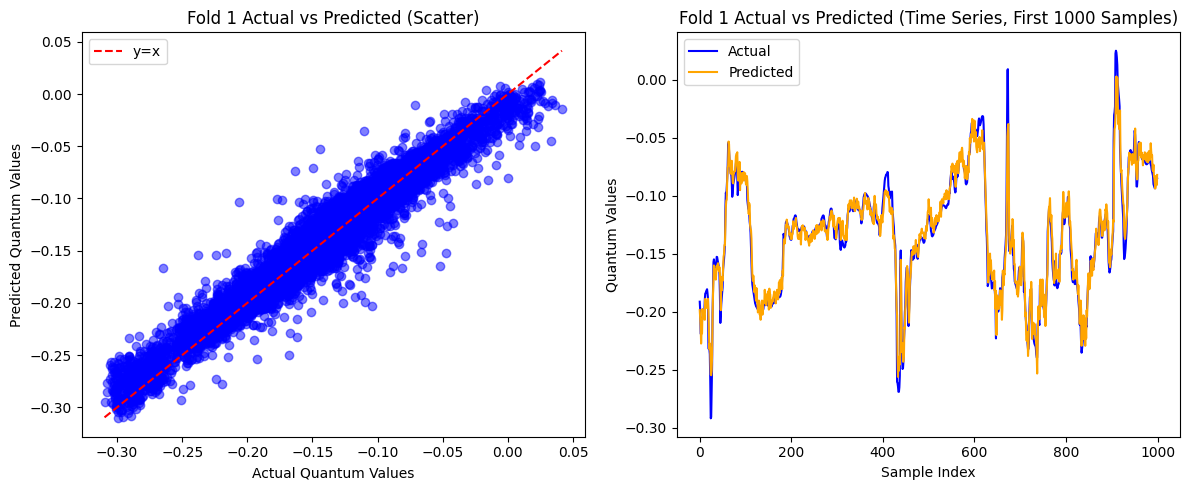

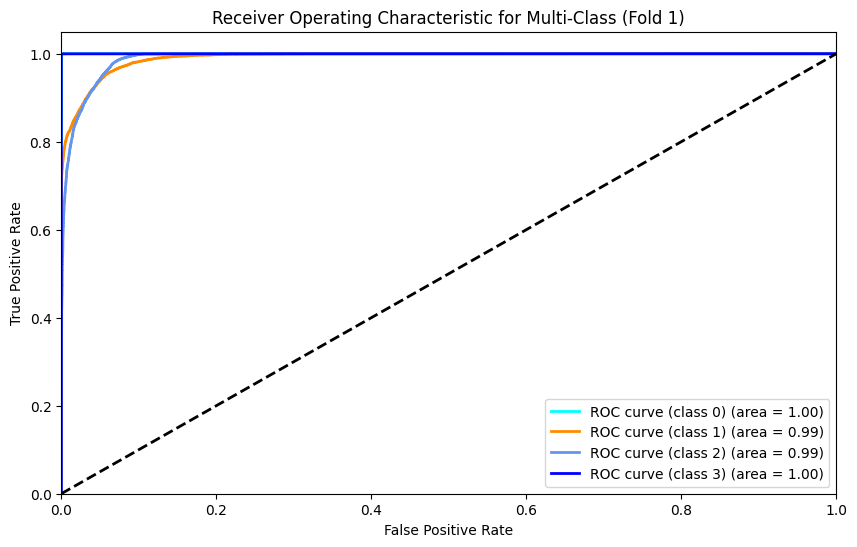


=== FOLD 1 TEST RESULTS ===
Test Loss: 0.070076
Quantum Test MSE: 0.000080
Quantum Test RMSE: 0.008931
Quantum Test MAE: 0.006423
Quantum Confidence Interval: 0.000079
Quantum Correlation Coefficient: 0.9673
ROC AUC: 0.9954
Test loss goal achieved!

=== Fold 2/2 ===
Train data shape: (46758, 32), Train labels shape: (46758,)
Val data shape: (46758, 32), Val labels shape: (46758,)
Fold 2 - Train samples: 46502, Val samples: 46502
Train class distribution: {0: 12257, 1: 12403, 2: 12152, 3: 9946}
Val class distribution: {0: 12167, 1: 12299, 2: 12159, 3: 10133}
Using lightning.gpu device for quantum circuit
Model initialized on cuda:0


Fold 2 Epoch 1: 100%|██████████| 727/727 [11:41<00:00,  1.04it/s]


Sample pred_probs (first 5 samples):
[[0.01675235 0.20654127 0.77397734 0.00272903]
 [0.01300566 0.17727055 0.80690217 0.00282167]
 [0.01966932 0.20026769 0.7771963  0.00286661]
 [0.01950534 0.20325257 0.77408963 0.00315245]
 [0.02044789 0.20317815 0.7733663  0.00300774]]

=== Per-Class Metrics ===
Class 0: Precision=0.8810, Recall=0.9799, F1=0.9278
Class 1: Precision=0.9060, Recall=0.6849, F1=0.7801
Class 2: Precision=0.8263, Recall=0.9317, F1=0.8758
Class 3: Precision=0.9888, Recall=1.0000, F1=0.9944
Classifier weight norm: 24.0699
Fold 2 Epoch 1: Train Loss=0.595286, Val Loss=0.280436, Quantum MSE=0.003190, Quantum RMSE=0.056481, Quantum MAE=0.048573, Quantum Correlation=0.6528, ROC AUC=0.9830
Saved best model at fold 2 epoch 1 with Val Loss=0.280436


Fold 2 Epoch 2: 100%|██████████| 727/727 [11:38<00:00,  1.04it/s]


Sample pred_probs (first 5 samples):
[[4.1314357e-05 6.0306717e-02 9.3964130e-01 1.0639809e-05]
 [2.8851620e-05 4.6265069e-02 9.5369619e-01 9.8677801e-06]
 [7.0149690e-05 6.9263436e-02 9.3065232e-01 1.4067104e-05]
 [7.4393240e-05 7.1641505e-02 9.2826766e-01 1.6466194e-05]
 [7.9009442e-05 7.2196350e-02 9.2770886e-01 1.5734278e-05]]

=== Per-Class Metrics ===
Class 0: Precision=0.9975, Recall=0.9971, F1=0.9973
Class 1: Precision=0.9684, Recall=0.7883, F1=0.8691
Class 2: Precision=0.8190, Recall=0.9738, F1=0.8897
Class 3: Precision=0.9959, Recall=1.0000, F1=0.9979
Classifier weight norm: 24.1446
Fold 2 Epoch 2: Train Loss=0.293802, Val Loss=0.131833, Quantum MSE=0.001034, Quantum RMSE=0.032157, Quantum MAE=0.026714, Quantum Correlation=0.7690, ROC AUC=0.9936
Saved best model at fold 2 epoch 2 with Val Loss=0.131833


Fold 2 Epoch 3: 100%|██████████| 727/727 [11:33<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[1.3098270e-06 1.9880075e-03 9.9801046e-01 2.5439832e-07]
 [9.2813792e-07 2.1968731e-03 9.9780196e-01 2.1288092e-07]
 [5.8630649e-06 2.1907890e-03 9.9780291e-01 4.7453949e-07]
 [7.3029455e-06 2.1198001e-03 9.9787223e-01 6.8078106e-07]
 [8.2821898e-06 2.1835039e-03 9.9780756e-01 6.8432871e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9973, Recall=0.9988, F1=0.9980
Class 1: Precision=0.8975, Recall=0.8973, F1=0.8974
Class 2: Precision=0.8967, Recall=0.8939, F1=0.8953
Class 3: Precision=0.9978, Recall=1.0000, F1=0.9989
Classifier weight norm: 24.2717
Fold 2 Epoch 3: Train Loss=0.105060, Val Loss=0.077756, Quantum MSE=0.000142, Quantum RMSE=0.011905, Quantum MAE=0.009072, Quantum Correlation=0.9478, ROC AUC=0.9950
Saved best model at fold 2 epoch 3 with Val Loss=0.077756


Fold 2 Epoch 4: 100%|██████████| 727/727 [11:32<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[5.7396232e-07 3.3782080e-02 9.6621692e-01 4.2939158e-07]
 [4.4340939e-07 2.7890375e-02 9.7210884e-01 3.8586214e-07]
 [1.6616578e-06 2.1310415e-02 9.7868747e-01 4.8216447e-07]
 [1.7630605e-06 1.6572447e-02 9.8342526e-01 5.5846249e-07]
 [2.0247444e-06 1.4943897e-02 9.8505360e-01 5.5057069e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9961, Recall=0.9980, F1=0.9971
Class 1: Precision=0.8940, Recall=0.8977, F1=0.8958
Class 2: Precision=0.8969, Recall=0.8898, F1=0.8933
Class 3: Precision=0.9980, Recall=1.0000, F1=0.9990
Classifier weight norm: 24.3412
Fold 2 Epoch 4: Train Loss=0.068887, Val Loss=0.076092, Quantum MSE=0.000106, Quantum RMSE=0.010310, Quantum MAE=0.007662, Quantum Correlation=0.9596, ROC AUC=0.9949
Saved best model at fold 2 epoch 4 with Val Loss=0.076092


Fold 2 Epoch 5: 100%|██████████| 727/727 [11:32<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[1.5597624e-07 6.9250851e-03 9.9307448e-01 3.2286093e-07]
 [1.4565106e-07 4.9217404e-03 9.9507785e-01 2.6907315e-07]
 [5.5889541e-07 5.1139602e-03 9.9488521e-01 2.8594843e-07]
 [5.9793229e-07 3.8522794e-03 9.9614680e-01 3.4360340e-07]
 [7.0632126e-07 3.5242874e-03 9.9647468e-01 3.2668979e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9994, Recall=0.9987, F1=0.9991
Class 1: Precision=0.9255, Recall=0.8856, F1=0.9051
Class 2: Precision=0.8869, Recall=0.9263, F1=0.9062
Class 3: Precision=0.9984, Recall=0.9996, F1=0.9990
Classifier weight norm: 24.4399
Fold 2 Epoch 5: Train Loss=0.062600, Val Loss=0.072341, Quantum MSE=0.000089, Quantum RMSE=0.009457, Quantum MAE=0.006818, Quantum Correlation=0.9626, ROC AUC=0.9955
Saved best model at fold 2 epoch 5 with Val Loss=0.072341


Fold 2 Epoch 6: 100%|██████████| 727/727 [11:32<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[1.12516425e-07 1.68609293e-03 9.98313665e-01 1.83196676e-07]
 [9.04833897e-08 1.23497588e-03 9.98764813e-01 1.41916331e-07]
 [3.03633016e-07 1.22310512e-03 9.98776436e-01 1.56985536e-07]
 [3.05796306e-07 8.10228696e-04 9.99189258e-01 1.91935243e-07]
 [3.55880417e-07 7.23201549e-04 9.99276280e-01 1.88715774e-07]]

=== Per-Class Metrics ===
Class 0: Precision=0.9994, Recall=0.9989, F1=0.9992
Class 1: Precision=0.9294, Recall=0.8838, F1=0.9060
Class 2: Precision=0.8865, Recall=0.9305, F1=0.9080
Class 3: Precision=0.9980, Recall=1.0000, F1=0.9990
Classifier weight norm: 24.5275
Fold 2 Epoch 6: Train Loss=0.056106, Val Loss=0.069188, Quantum MSE=0.000087, Quantum RMSE=0.009341, Quantum MAE=0.006661, Quantum Correlation=0.9631, ROC AUC=0.9958
Saved best model at fold 2 epoch 6 with Val Loss=0.069188


Fold 2 Epoch 7: 100%|██████████| 727/727 [11:32<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[9.4589559e-08 1.3182000e-03 9.9868166e-01 4.6971753e-08]
 [8.0434027e-08 1.2538657e-03 9.9874598e-01 4.7025519e-08]
 [2.8904719e-07 9.4048551e-04 9.9905914e-01 3.4757434e-08]
 [2.9646668e-07 6.5456540e-04 9.9934512e-01 3.7998937e-08]
 [3.4883831e-07 5.8512465e-04 9.9941444e-01 3.5856267e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9990, Recall=0.9995, F1=0.9993
Class 1: Precision=0.9161, Recall=0.9153, F1=0.9157
Class 2: Precision=0.9137, Recall=0.9129, F1=0.9133
Class 3: Precision=0.9986, Recall=1.0000, F1=0.9993
Classifier weight norm: 24.5758
Fold 2 Epoch 7: Train Loss=0.050443, Val Loss=0.075704, Quantum MSE=0.000093, Quantum RMSE=0.009624, Quantum MAE=0.007103, Quantum Correlation=0.9661, ROC AUC=0.9962


Fold 2 Epoch 8: 100%|██████████| 727/727 [11:32<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[1.45795880e-07 3.39485961e-03 9.96605039e-01 1.77288264e-08]
 [1.07113408e-07 3.10813356e-03 9.96891797e-01 1.73897288e-08]
 [4.10519732e-07 2.76033045e-03 9.97239232e-01 1.16981980e-08]
 [3.83687023e-07 2.27652071e-03 9.97723103e-01 1.20836896e-08]
 [4.76157112e-07 2.12585623e-03 9.97873664e-01 1.18935395e-08]]

=== Per-Class Metrics ===
Class 0: Precision=0.9987, Recall=0.9999, F1=0.9993
Class 1: Precision=0.9187, Recall=0.9094, F1=0.9140
Class 2: Precision=0.9087, Recall=0.9164, F1=0.9126
Class 3: Precision=0.9992, Recall=1.0000, F1=0.9996
Classifier weight norm: 24.6442
Fold 2 Epoch 8: Train Loss=0.049476, Val Loss=0.065178, Quantum MSE=0.000071, Quantum RMSE=0.008451, Quantum MAE=0.005897, Quantum Correlation=0.9703, ROC AUC=0.9959
Saved best model at fold 2 epoch 8 with Val Loss=0.065178


Fold 2 Epoch 9: 100%|██████████| 727/727 [11:31<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[8.0957525e-09 7.3909322e-03 9.9260908e-01 8.5955909e-09]
 [6.7653914e-09 7.1237115e-03 9.9287629e-01 9.1266914e-09]
 [1.8759717e-08 5.1920372e-03 9.9480790e-01 7.0888251e-09]
 [1.9681854e-08 3.9141825e-03 9.9608582e-01 7.2787385e-09]
 [2.3147299e-08 3.5805746e-03 9.9641943e-01 7.3533024e-09]]

=== Per-Class Metrics ===
Class 0: Precision=0.9985, Recall=0.9995, F1=0.9990
Class 1: Precision=0.8999, Recall=0.9308, F1=0.9151
Class 2: Precision=0.9279, Recall=0.8925, F1=0.9099
Class 3: Precision=0.9980, Recall=1.0000, F1=0.9990
Classifier weight norm: 24.7159
Fold 2 Epoch 9: Train Loss=0.047622, Val Loss=0.071399, Quantum MSE=0.000074, Quantum RMSE=0.008604, Quantum MAE=0.005977, Quantum Correlation=0.9694, ROC AUC=0.9958


Fold 2 Epoch 10: 100%|██████████| 727/727 [11:30<00:00,  1.05it/s]


Sample pred_probs (first 5 samples):
[[1.9535058e-08 1.5535628e-03 9.9844640e-01 1.1693720e-08]
 [9.2145287e-09 1.4342566e-03 9.9856573e-01 1.1280018e-08]
 [5.0050399e-08 1.0039607e-03 9.9899596e-01 8.1271398e-09]
 [4.8445287e-08 7.3610077e-04 9.9926382e-01 8.6686978e-09]
 [5.8679934e-08 6.5118872e-04 9.9934870e-01 8.2825515e-09]]

=== Per-Class Metrics ===
Class 0: Precision=0.9940, Recall=0.9997, F1=0.9968
Class 1: Precision=0.9436, Recall=0.8742, F1=0.9076
Class 2: Precision=0.8845, Recall=0.9457, F1=0.9141
Class 3: Precision=0.9989, Recall=1.0000, F1=0.9995
Classifier weight norm: 24.8281
Fold 2 Epoch 10: Train Loss=0.048105, Val Loss=0.073175, Quantum MSE=0.000106, Quantum RMSE=0.010299, Quantum MAE=0.007781, Quantum Correlation=0.9687, ROC AUC=0.9960
Early stopping at fold 2 epoch 10

Loading best model from fold 2 epoch 8 for testing...
Fold 2 Batch 0: quantum pred min: -1.890625, max: 0.08251953125
Fold 2 Batch 1: quantum pred min: -0.97705078125, max: 1.076171875
Fold 2 Batch 

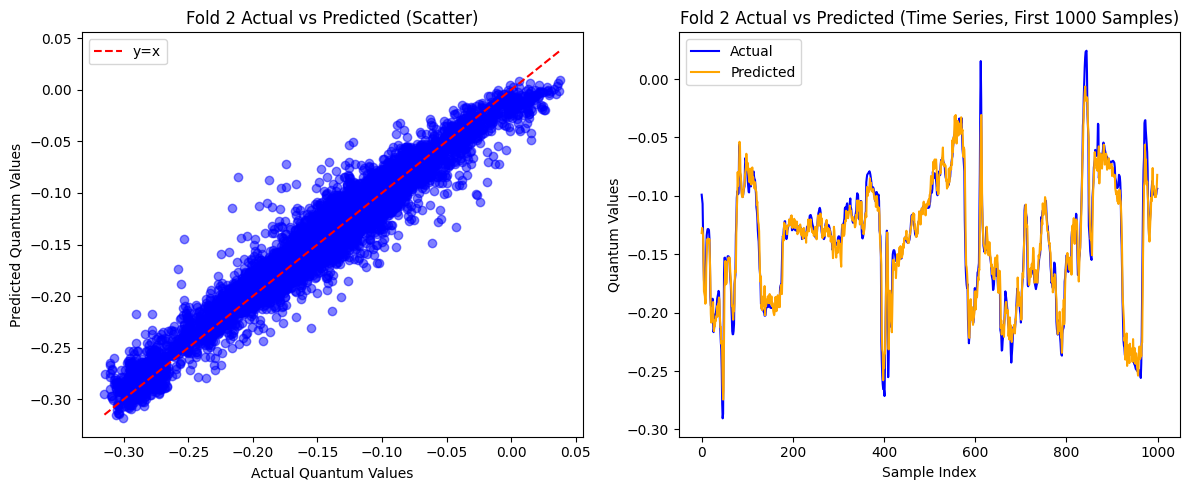

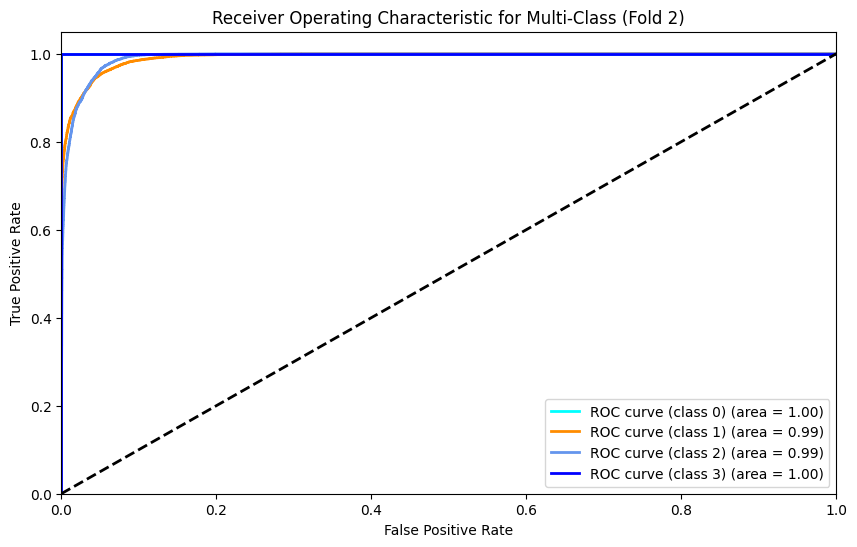


=== FOLD 2 TEST RESULTS ===
Test Loss: 0.065178
Quantum Test MSE: 0.000071
Quantum Test RMSE: 0.008451
Quantum Test MAE: 0.005897
Quantum Confidence Interval: 0.000076
Quantum Correlation Coefficient: 0.9703
ROC AUC: 0.9959
Test loss goal achieved!

=== CROSS-VALIDATION SUMMARY ===
Average Test Loss: 0.067627
Average Quantum MSE: 0.000076
Average Quantum Correlation: 0.9688
Average ROC AUC: 0.9957
Fold 1: Test Loss=0.070076, Quantum MSE=0.000080, Quantum Correlation=0.9673, ROC AUC=0.9954
Fold 2: Test Loss=0.065178, Quantum MSE=0.000071, Quantum Correlation=0.9703, ROC AUC=0.9959

=== BEST FOLD SELECTED ===
Best Fold: 2
Test Loss: 0.065178
Quantum Test MSE: 0.000071
Quantum Test RMSE: 0.008451
Quantum Test MAE: 0.005897
Quantum Confidence Interval: 0.000076
Quantum Correlation Coefficient: 0.9703
ROC AUC: 0.9959
Best model weights saved at: best_model_fold2.pth


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from torch.amp import GradScaler, autocast
from tqdm import tqdm
import gc
import warnings
from scipy.signal import butter, filtfilt, find_peaks
from scipy.interpolate import interp1d
import pywt
import pennylane as qml
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_fscore_support
from sklearn.preprocessing import PowerTransformer, label_binarize
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from itertools import cycle
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau, LambdaLR

warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.transformer")

# Optimize CUDA settings
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.set_float32_matmul_precision('high')
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

DATASET_PATH = "/kaggle/input/fourtype/Dataset_Fourtype.csv"

def bandpass_filter(data, lowcut=0.3, highcut=50.0, fs=360.0, order=5):
    nyquist = fs / 2
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data, axis=0)
    return filtered

def mad(data):
    return np.median(np.abs(data - np.median(data)))

def wavelet_denoise(data, wavelet='db8', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    sigma = mad(coeffs[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(data)))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=uthresh, mode='soft')
    return pywt.waverec(coeffs, wavelet)

def align_r_peaks(data, fs=360.0, window=250):
    aligned_data = []
    for i in range(0, len(data) - window, window):
        segment = data[i:i+window]
        peaks, _ = find_peaks(segment[:, 0], height=0.5, distance=int(fs/3))
        if len(peaks) > 0:
            r_peak = peaks[0]
            start = max(0, r_peak - window//2)
            end = start + window
            if end <= len(segment):
                aligned_data.append(segment[start:end])
            else:
                aligned_data.append(segment[-window:])
        else:
            aligned_data.append(segment)
    return np.array(aligned_data).reshape(-1, data.shape[1])

def add_baseline_wander(data, amplitude=0.1, frequency=0.5, fs=360.0):
    t = np.arange(len(data)) / fs
    wander = amplitude * np.sin(2 * np.pi * frequency * t)
    return data + wander[:, np.newaxis]

def add_muscle_artifact(data, amplitude=0.05, fs=360.0):
    t = np.arange(len(data)) / fs
    noise = amplitude * np.random.randn(len(data))
    return data + noise[:, np.newaxis]

class MoE(nn.Module):
    def __init__(self, d_model, num_experts, d_ffn, dropout=0.2):
        super().__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_ffn),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_ffn, d_model)
            ) for _ in range(num_experts)
        ])
        self.router = nn.Linear(d_model, num_experts)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()
        # Router scores
        router_logits = self.router(x)  # [batch_size, seq_len, num_experts]
        router_weights = F.softmax(router_logits, dim=-1)  # [batch_size, seq_len, num_experts]

        # Compute expert outputs
        expert_outputs = torch.zeros_like(x)
        for i, expert in enumerate(self.experts):
            expert_output = expert(x)  # [batch_size, seq_len, d_model]
            expert_outputs += router_weights[:, :, i:i+1] * expert_output

        return self.dropout(expert_outputs)

class MoETransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1, activation="gelu"):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.moe = MoE(d_model, num_experts=8, d_ffn=dim_feedforward, dropout=0.2)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = getattr(nn.functional, activation) if isinstance(activation, str) else activation

    def forward(self, src, src_mask=None, is_causal=False, src_key_padding_mask=None):
        # Self attention
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, is_causal=is_causal, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout(src2)
        src = self.norm1(src)
        
        # MoE feedforward
        src2 = self.moe(src)
        src = src + self.dropout(src2)
        src = self.norm2(src)
        return src

class iTransformer(nn.Module):
    def __init__(self, num_variates, seq_len, pred_len, n_classes, hidden_size=512, num_heads=8, num_layers=4, dropout=0.3, ffn_multiplier=5, activation='gelu', device='cuda:0'):
        super().__init__()
        self.num_variates = num_variates
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        self.device = torch.device(device)
        
        self.proj_in = nn.Linear(num_variates, hidden_size)
        self.pos_enc = PositionalEncoding(hidden_size)
        self.encoder = nn.TransformerEncoder(
            MoETransformerEncoderLayer(
                d_model=hidden_size,
                nhead=num_heads,
                dim_feedforward=ffn_multiplier * hidden_size,
                dropout=dropout,
                activation=activation
            ),
            num_layers=num_layers
        )
        
        self.quantum_head = nn.Linear(hidden_size * seq_len, hidden_size)
        self.classifier_head = nn.Linear(hidden_size * seq_len, hidden_size)
        self.quantum_output = nn.Linear(hidden_size, 1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(hidden_size // 2, n_classes)
        )
        
        self.num_qubits = 16
        self.quantum_proj = nn.Linear(self.num_qubits, self.num_qubits)
        self.num_layers = 5
        try:
            self.dev = qml.device("lightning.gpu", wires=self.num_qubits)
            print("Using lightning.gpu device for quantum circuit")
        except Exception as e:
            print(f"Failed to initialize lightning.gpu: {e}")
            self.dev = qml.device("default.qubit", wires=self.num_qubits)
            print("Falling back to default.qubit device for quantum circuit")
        self.fallback_layer = nn.Linear(self.num_qubits, self.num_qubits)
        
        @qml.qnode(self.dev, interface='torch', diff_method='parameter-shift')
        def quantum_circuit(inputs, weights):
            inputs = inputs / (torch.max(torch.abs(inputs), dim=-1, keepdim=True)[0] + 1e-8)
            if torch.any(torch.isnan(inputs)) or torch.any(torch.isinf(inputs)):
                inputs = torch.clamp(inputs, -1.0, 1.0)
            for layer in range(self.num_layers):
                for i in range(self.num_qubits):
                    qml.RX(inputs[:, i], wires=i)
                    qml.RY(weights[layer, i, 0], wires=i)
                    qml.RZ(weights[layer, i, 1], wires=i)
                for i in range(self.num_qubits - 1):
                    qml.CNOT(wires=[i, i+1])
            measurements = [qml.expval(qml.PauliZ(i)) for i in range(self.num_qubits)]
            return torch.stack(measurements).T

        self.quantum_circuit = quantum_circuit
        weight_shapes = (self.num_layers, self.num_qubits, 2)
        self.weights = nn.Parameter(torch.randn(weight_shapes) * 0.1, requires_grad=True).to(self.device)
        self.quantum_dropout = nn.Dropout(dropout)
        self.quantum_post = nn.Linear(self.num_qubits, 1).to(self.device)
        self.quantum_scale = nn.Parameter(torch.tensor(5.0)).to(self.device)

    def forward(self, x):
        if x.shape[-1] != self.num_variates:
            raise ValueError(f"Input variates {x.shape[-1]} do not match expected {self.num_variates}")
        
        with autocast('cuda', dtype=torch.float16):
            x_trans = self.proj_in(x)
            x_trans = self.pos_enc(x_trans)
            x_trans = self.encoder(x_trans)
            x_trans = x_trans.reshape(x_trans.size(0), -1)
        
        quantum_branch = self.quantum_head(x_trans)
        with autocast('cuda', dtype=torch.float16):
            quantum_out = self.quantum_output(quantum_branch)
            inputs_quantum = x[:, :, :min(x.shape[-1], self.num_qubits)]
            inputs_quantum = self.quantum_proj(inputs_quantum[:, -1, :]).to(device=self.device, dtype=torch.float32)
            try:
                quantum_outputs = self.quantum_circuit(inputs_quantum, self.weights)
            except Exception as e:
                quantum_outputs = self.fallback_layer(inputs_quantum)
            quantum_outputs = self.quantum_dropout(quantum_outputs)
            pred_quantum = quantum_out + self.quantum_post(quantum_outputs) * self.quantum_scale
        
        class_branch = self.classifier_head(x_trans.float())
        class_logits = self.classifier(class_branch)
        class_logits = torch.clamp(class_logits, min=-10.0, max=10.0)
        pred_probs = F.softmax(class_logits, dim=1)
        pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
        
        return pred_quantum.flatten(), pred_probs

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        position = torch.arange(max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[..., 0::2] = torch.sin(position * div_term)
        pe[..., 1::2] = torch.cos(position * div_term)
        self.pe = nn.Parameter(pe, requires_grad=False)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class ECG_loss(nn.Module):
    def __init__(self, class_weights, quantum_weight=0.4, class_weight=0.6):
        super().__init__()
        self.huber = nn.HuberLoss()
        self.class_weights = class_weights  # Assume class_weights is already on the correct device
        self.cross_entropy = nn.CrossEntropyLoss(weight=self.class_weights)
        self.quantum_weight = quantum_weight
        self.class_weight = class_weight

    def forward(self, pred_quantum, target_quantum, pred_probs, target_class):
        quantum_loss = self.huber(pred_quantum, target_quantum)
        class_loss = self.cross_entropy(pred_probs.log(), target_class)
        return self.quantum_weight * quantum_loss + self.class_weight * class_loss

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len, labels=None):
        self.features = data.values.astype(np.float32)
        self.labels = labels.astype(np.int64) if labels is not None else None
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_samples = len(data) - seq_len - pred_len + 1
        if self.num_samples <= 0:
            raise ValueError(f"Insufficient data: num_samples = {self.num_samples}")
        rng = np.random.default_rng()
        noise1 = rng.normal(0, 0.1, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        scale = rng.uniform(0.8, 1.2, (self.num_samples, 1, 1)).astype(np.float32)
        noise2 = rng.normal(0, 0.05, (self.num_samples, seq_len, self.features.shape[1])).astype(np.float32)
        warp_factor = rng.uniform(0.9, 1.1, self.num_samples).astype(np.float32)
        self.augmented = []
        time_orig = np.linspace(0, 1, seq_len)
        for idx in range(self.num_samples):
            x = self.features[idx:idx + seq_len]
            x = add_baseline_wander(x)
            x = add_muscle_artifact(x)
            time_warped = np.linspace(0, 1, seq_len) * warp_factor[idx]
            time_warped = time_warped / time_warped[-1] * time_orig[-1]
            x_warped = np.zeros_like(x)
            for v in range(x.shape[1]):
                interp = interp1d(time_orig, x[:, v], kind='linear', fill_value="extrapolate")
                x_warped[:, v] = interp(time_warped)
            t = np.linspace(0, 1, seq_len)
            wander = 0.05 * np.sin(2 * np.pi * 0.5 * t)
            x = x_warped + wander[:, None] + noise1[idx]
            x = x * scale[idx] + noise2[idx]
            if rng.random() > 0.5:
                crop_start = rng.integers(0, seq_len // 10)
                x = x[crop_start:crop_start + seq_len] if crop_start + seq_len <= len(x) else x
            x = np.clip(x, -5, 5)
            if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                print(f"Warning: NaN or Inf in augmented data at index {idx}")
                x = np.nan_to_num(x, nan=0.0, posinf=5.0, neginf=-5.0)
            self.augmented.append(x)
        all_data = self.features[self.seq_len:self.seq_len + self.num_samples, :]
        self.quantum_targets = np.mean(all_data, axis=1).astype(np.float32)
        if self.labels is not None:
            self.labels = self.labels[self.seq_len:self.seq_len + self.num_samples]

    def __len__(self):
        return max(0, self.num_samples)
    
    def __getitem__(self, idx):
        idx = idx % self.num_samples
        x = self.augmented[idx]
        y_quantum = self.quantum_targets[idx]
        y_label = self.labels[idx] if self.labels is not None else -1
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_quantum, dtype=torch.float32), torch.tensor(y_label, dtype=torch.int64)

def calculate_metrics(true_quantum, pred_quantum):
    mse = torch.mean((true_quantum - pred_quantum)**2)
    rmse = torch.sqrt(mse)
    mae = torch.mean(torch.abs(true_quantum - pred_quantum))
    std_error = torch.std(true_quantum - pred_quantum)
    z_score = 1.96
    conf_interval = z_score * std_error / np.sqrt(true_quantum.size(0))
    true_range = torch.clamp(torch.max(true_quantum) - torch.min(true_quantum), min=1e-6)
    threshold = 0.3 * true_range
    abs_error = torch.abs(true_quantum - pred_quantum)
  
    corr_coef, _ = pearsonr(true_quantum.cpu().numpy(), pred_quantum.cpu().numpy())
    return {
        'Quantum_MSE': mse.item(),
        'Quantum_RMSE': rmse.item(),
        'Quantum_MAE': mae.item(),
        'Quantum_Conf_Interval': conf_interval.item(),
        'Quantum_Correlation': corr_coef
    }

def get_optimizer(model, optimizer_type, lr, weight_decay):
    if optimizer_type.lower() == 'adamw':
        return optim.AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            amsgrad=False,
            betas=(0.9, 0.999),
            eps=1e-8,
            maximize=False,
            foreach=False,
            fused=False,
            capturable=False,
            differentiable=False
        )
    elif optimizer_type.lower() == 'adam':
        return optim.Adam(
            model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            amsgrad=False,
            betas=(0.9, 0.999),
            eps=1e-8,
            maximize=False,
            foreach=False,
            fused=False,
            capturable=False,
            differentiable=False
        )
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_type}")

def get_scheduler(optimizer, scheduler_type, warmup_epochs, total_epochs):
    if scheduler_type.lower() == 'cosine':
        def lr_lambda(epoch):
            if epoch < warmup_epochs:
                return (epoch + 1) / warmup_epochs
            return 0.5 * (1 + np.cos(np.pi * (epoch - warmup_epochs) / (total_epochs - warmup_epochs)))
        return LambdaLR(optimizer, lr_lambda)
    elif scheduler_type.lower() == 'reduce_on_plateau':
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    else:
        raise ValueError(f"Unsupported scheduler: {scheduler_type}")

def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Device: {device}")

    try:
        raw_data = pd.read_csv(DATASET_PATH)
        raw_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        raw_data.dropna(inplace=True)
        print(f"Raw data shape after dropping NaN: {raw_data.shape}")
    except Exception as e:
        raise ValueError(f"Error loading dataset: {e}")

    original_n_rows = raw_data.shape[0]
    lead0_columns = [col for col in raw_data.columns if col.startswith('0_') or col == 'type']
    raw_data = raw_data[lead0_columns]
    print(f"Data shape after selecting Lead 0: {raw_data.shape}")

    if 'type' in raw_data.columns:
        labels = raw_data['type'].values
        filtered_data = raw_data.drop(columns=['type']).values
        unique_labels, counts = np.unique(labels, return_counts=True)
        n_classes = len(unique_labels)
        print("\n=== Class Label Distribution ===")
        for label, count in zip(unique_labels, counts):
            print(f"Label {int(label)}: {count} samples")
        class_weights_dict = {}
        n_samples = len(labels)
        for label, count in zip(unique_labels, counts):
            weight = n_samples / (n_classes * count)
            class_weights_dict[int(label)] = weight
        print(f"Class weights: {class_weights_dict}")
        # Convert class_weights_dict to a tensor and move to device
        class_weights_tensor = torch.tensor([class_weights_dict[i] for i in range(n_classes)], dtype=torch.float32).to(device)
    else:
        filtered_data = raw_data.values
        labels = None
        n_classes = 0
        class_weights_tensor = None
        print("No 'type' column found, proceeding without labels.")

    print(f"Initial filtered_data shape: {filtered_data.shape}, labels shape: {labels.shape if labels is not None else 'None'}")

    filtered_data = np.apply_along_axis(wavelet_denoise, 0, filtered_data)
    filtered_data = bandpass_filter(filtered_data)
    filtered_data = np.clip(filtered_data, np.percentile(filtered_data, 2), np.percentile(filtered_data, 98))
    filtered_df = pd.DataFrame(filtered_data, columns=[f"lead0_{i}" for i in range(filtered_data.shape[1])])
    filtered_df = filtered_df.rolling(window=3).mean().bfill()
    filtered_df = filtered_df.iloc[:original_n_rows]
    print(f"filtered_df shape after rolling: {filtered_df.shape}")

    data_ma = filtered_df.rolling(window=5).mean().bfill()
    data_ma.columns = [f"{col}_ma" for col in filtered_df.columns]
    data_ma = data_ma.iloc[:original_n_rows]
    enhanced_data = pd.concat([filtered_df, data_ma], axis=1)
    print(f"Enhanced data shape: {enhanced_data.shape}, num_variates: {enhanced_data.shape[1]}")

    scaler_yeo = PowerTransformer(method='yeo-johnson', standardize=True)
    norm_data = scaler_yeo.fit_transform(enhanced_data)
    norm_data = np.nan_to_num(norm_data, nan=0.0, posinf=5.0, neginf=-5.0)
    norm_data = np.clip(norm_data, -10.0, 10.0)
    norm_data = pd.DataFrame(norm_data, columns=enhanced_data.columns)
    print(f"norm_data shape: {norm_data.shape}, labels shape: {labels.shape if labels is not None else 'None'}")

    all_data = enhanced_data.values
    quantum_targets = np.mean(all_data, axis=1)
    quantum_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
    quantum_targets = quantum_scaler.fit_transform(quantum_targets.reshape(-1, 1)).flatten()
    quantum_targets = np.nan_to_num(quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
    quantum_targets = np.clip(quantum_targets, -10.0, 10.0)
    quantum_targets_min = quantum_targets.min()
    quantum_targets_max = quantum_targets.max()
    quantum_targets_range = quantum_targets_max - quantum_targets_min if quantum_targets_max != quantum_targets_min else 1
    quantum_targets = 2 * (quantum_targets - quantum_targets_min) / quantum_targets_range - 1
    print(f"Quantum targets range: [{quantum_targets.min():.4f}, {quantum_targets.max():.4f}]")

    print(f"Number of Target Values: {len(quantum_targets)}")
    print(f"Target Value Name: Quantum Target (Mean of Lead 0 Attributes)")

    if labels is not None and norm_data.shape[0] != labels.shape[0]:
        raise ValueError(f"Shape mismatch: norm_data has {norm_data.shape[0]} rows, but labels has {labels.shape[0]} rows.")

    config = {
        'num_variates': norm_data.shape[1],
        'seq_len': 256,
        'pred_len': 1,
        'hidden_size': 512,
        'num_heads': 8,
        'num_layers': 4,
        'dropout': 0.3,
        'lr': 2e-4,
        'batch_size': 64,
        'epochs': 80,
        'patience': 2,
        'grad_clip': 1.0,
        'warmup_epochs': 10,
        'grad_accum_steps': 1,
        'n_splits': 2,
        'min_samples': 299,
        'num_workers': 4,
        'optimizer': 'adamw',
        'weight_decay': 5e-3,
        'scheduler_type': 'cosine',
        'activation': 'gelu',
        'ffn_multiplier': 5,
        'quantum_weight': 0.4,
        'class_weight': 0.6
    }

    kf = KFold(n_splits=config['n_splits'], shuffle=True)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(enhanced_data)):
        print(f"\n=== Fold {fold+1}/{config['n_splits']} ===")
        train_data = enhanced_data.iloc[train_idx]
        val_data = enhanced_data.iloc[val_idx]
        train_labels = labels[train_idx] if labels is not None else None
        val_labels = labels[val_idx] if labels is not None else None
        print(f"Train data shape: {train_data.shape}, Train labels shape: {train_labels.shape if train_labels is not None else 'None'}")
        print(f"Val data shape: {val_data.shape}, Val labels shape: {val_labels.shape if val_labels is not None else 'None'}")

        scaler_yeo_train = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_train = scaler_yeo_train.fit_transform(train_data)
        norm_train = np.nan_to_num(norm_train, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_train = np.clip(norm_train, -10.0, 10.0)
        norm_train = pd.DataFrame(norm_train, columns=enhanced_data.columns)

        scaler_yeo_val = PowerTransformer(method='yeo-johnson', standardize=True)
        norm_val = scaler_yeo_val.fit_transform(val_data)
        norm_val = np.nan_to_num(norm_val, nan=0.0, posinf=5.0, neginf=-5.0)
        norm_val = np.clip(norm_val, -10.0, 10.0)
        norm_val = pd.DataFrame(norm_val, columns=enhanced_data.columns)

        quantum_scaler = PowerTransformer(method='yeo-johnson', standardize=True)
        train_quantum_targets = quantum_scaler.fit_transform(quantum_targets[train_idx].reshape(-1, 1)).flatten()
        train_quantum_targets = np.nan_to_num(train_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        train_quantum_targets = np.clip(train_quantum_targets, -10.0, 10.0)
        train_quantum_targets_min = train_quantum_targets.min()
        train_quantum_targets_max = train_quantum_targets.max()
        train_quantum_targets_range = train_quantum_targets_max - train_quantum_targets_min if train_quantum_targets_max != train_quantum_targets_min else 1
        train_quantum_targets = 2 * (train_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1

        val_quantum_targets = quantum_scaler.transform(quantum_targets[val_idx].reshape(-1, 1)).flatten()
        val_quantum_targets = np.nan_to_num(val_quantum_targets, nan=0.0, posinf=5.0, neginf=-5.0)
        val_quantum_targets = np.clip(val_quantum_targets, -10.0, 10.0)
        val_quantum_targets = 2 * (val_quantum_targets - train_quantum_targets_min) / train_quantum_targets_range - 1

        try:
            train_dataset = TimeSeriesDataset(norm_train, config['seq_len'], config['pred_len'], train_labels)
            val_dataset = TimeSeriesDataset(norm_val, config['seq_len'], config['pred_len'], val_labels)
            print(f"Fold {fold+1} - Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")
        except Exception as e:
            print(f"Error creating datasets for fold {fold+1}: {e}. Skipping fold.")
            continue

        if train_labels is not None:
            train_class_dist = {}
            unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
            for label, count in zip(unique_train_labels, train_counts):
                train_class_dist[int(label)] = count
            print(f"Train class distribution: {train_class_dist}")
        if val_labels is not None:
            val_class_dist = {}
            unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
            for label, count in zip(unique_val_labels, val_counts):
                val_class_dist[int(label)] = count
            print(f"Val class distribution: {val_class_dist}")

        train_loader = DataLoader(
            train_dataset,
            batch_size=config['batch_size'],
            shuffle=True,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config['batch_size'],
            shuffle=False,
            pin_memory=True,
            num_workers=config['num_workers'],
            persistent_workers=True if config['num_workers'] > 0 else False
        )

        if len(train_loader) == 0:
            print(f"Train loader empty for fold {fold+1}. Skipping fold.")
            continue

        try:
            model = iTransformer(
                num_variates=config['num_variates'],
                seq_len=config['seq_len'],
                pred_len=config['pred_len'],
                n_classes=n_classes,
                hidden_size=config['hidden_size'],
                num_heads=config['num_heads'],
                num_layers=config['num_layers'],
                dropout=config['dropout'],
                ffn_multiplier=config['ffn_multiplier'],
                activation=config['activation'],
                device=device
            ).to(device)
            print(f"Model initialized on {device}")
        except Exception as e:
            print(f"Error initializing model for fold {fold+1}: {e}. Skipping fold.")
            continue

        param_groups = [
            {
                'params': [p for n, p in model.named_parameters() if 'weights' in n],
                'lr': 5e-6,
                'weight_decay': 1e-2,
                'amsgrad': False,
                'betas': (0.9, 0.999),
                'eps': 1e-8,
                'maximize': False,
                'foreach': False,
                'fused': False,
                'capturable': False,
                'differentiable': False
            },
            {
                'params': [p for n, p in model.named_parameters() if 'classifier' in n and 'weights' not in n],
                'lr': 1e-4,
                'weight_decay': 1e-3,
                'amsgrad': False,
                'betas': (0.9, 0.999),
                'eps': 1e-8,
                'maximize': False,
                'foreach': False,
                'fused': False,
                'capturable': False,
                'differentiable': False
            },
            {
                'params': [p for n, p in model.named_parameters() if 'classifier' not in n and 'weights' not in n],
                'lr': config['lr'],
                'weight_decay': config['weight_decay'],
                'amsgrad': False,
                'betas': (0.9, 0.999),
                'eps': 1e-8,
                'maximize': False,
                'foreach': False,
                'fused': False,
                'capturable': False,
                'differentiable': False
            }
        ]
        optimizer = get_optimizer(model, config['optimizer'], config['lr'], config['weight_decay'])
        optimizer.param_groups = param_groups
        scheduler = get_scheduler(optimizer, config['scheduler_type'], config['warmup_epochs'], config['epochs'])
        criterion = ECG_loss(class_weights=class_weights_tensor,quantum_weight=config['quantum_weight'],class_weight=config['class_weight']).to(device)
        grad_scaler = GradScaler('cuda')

        best_val_loss = float('inf')

        patience_counter = 0
        best_epoch = 0
        train_losses, val_losses, quantum_mses, quantum_rmses, quantum_maes = [], [], [], [], []

        for epoch in range(config['epochs']):
            model.train()
            train_loss = 0
            for batch_idx, (x, y_quantum, y_label) in enumerate(tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}")):
                x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                optimizer.zero_grad(set_to_none=True)
                with autocast('cuda', dtype=torch.float16):
                    pred_quantum, pred_probs = model(x)
                    loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                grad_scaler.scale(loss).backward()
                if (batch_idx + 1) % config['grad_accum_steps'] == 0 or (batch_idx + 1) == len(train_loader):
                    torch.nn.utils.clip_grad_norm_([p for n, p in model.named_parameters() if 'weights' not in n], config['grad_clip'])
                    torch.nn.utils.clip_grad_norm_([p for n, p in model.named_parameters() if 'weights' in n], 0.3)
                    grad_scaler.step(optimizer)
                    grad_scaler.update()
                    optimizer.zero_grad(set_to_none=True)
                train_loss += loss.item()
                del x, y_quantum, y_label, pred_quantum, pred_probs, loss
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            model.eval()
            val_loss = 0
            pred_quantums, true_quantums, pred_probs_list, true_labels_list = [], [], [], []
            with torch.no_grad():
                for x, y_quantum, y_label in val_loader:
                    x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                    pred_quantum, pred_probs = model(x)
                    with autocast('cuda', dtype=torch.float16):
                        loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                    val_loss += loss.item()
                    pred_quantums.append(pred_quantum.cpu())
                    true_quantums.append(y_quantum.cpu())
                    prob_sums = pred_probs.sum(dim=1)
                    if not torch.allclose(prob_sums, torch.ones_like(prob_sums), rtol=1e-6, atol=1e-6):
                        max_deviation = (prob_sums - 1.0).abs().max().item()
                        print(f"Warning: Probabilities do not sum to 1 in batch, max deviation: {max_deviation}")
                        pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
                    if len(pred_probs_list) == 0:
                        print(f"Sample pred_probs (first 5 samples):\n{pred_probs[:5].cpu().numpy()}")
                    pred_probs_list.append(pred_probs.cpu())
                    true_labels_list.append(y_label.cpu())
                    del x, y_quantum, y_label, pred_quantum, pred_probs, loss
            val_loss /= len(val_loader)
            val_losses.append(val_loss)
            pred_quantums = torch.cat(pred_quantums)
            true_quantums = torch.cat(true_quantums)
            pred_probs = torch.cat(pred_probs_list)
            true_labels = torch.cat(true_labels_list)
            pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
            true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
            quantum_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
            quantum_mse = quantum_metrics['Quantum_MSE']
            quantum_rmse = quantum_metrics['Quantum_RMSE']
            quantum_mae = quantum_metrics['Quantum_MAE']
            quantum_conf_interval = quantum_metrics['Quantum_Conf_Interval']
            quantum_corr = quantum_metrics['Quantum_Correlation']
            pred_probs_np = pred_probs.cpu().numpy()
            true_labels_np = true_labels.cpu().numpy()
            prob_sums_np = pred_probs_np.sum(axis=1)
            if not np.allclose(prob_sums_np, 1.0, rtol=1e-6, atol=1e-6):
                print(f"Warning: Final probabilities do not sum to 1, max deviation: {np.abs(prob_sums_np - 1.0).max()}")
                pred_probs_np = pred_probs_np / (pred_probs_np.sum(axis=1, keepdims=True) + 1e-10)
            try:
                roc_auc = roc_auc_score(true_labels_np, pred_probs_np, multi_class='ovr')
            except ValueError as e:
                print(f"Error computing ROC AUC: {e}. Skipping ROC AUC for this fold.")
                roc_auc = float('nan')
            pred_labels = np.argmax(pred_probs_np, axis=1)
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels_np, pred_labels, average=None, labels=range(n_classes))
            print("\n=== Per-Class Metrics ===")
            for i in range(n_classes):
                print(f"Class {i}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1={f1[i]:.4f}")
            classifier_weight_norm = sum(p.norm().item() for n, p in model.named_parameters() if 'classifier' in n)
            print(f"Classifier weight norm: {classifier_weight_norm:.4f}")
            quantum_mses.append(quantum_mse)
            quantum_rmses.append(quantum_rmse)
            quantum_maes.append(quantum_mae)
       

            if config['scheduler_type'] == 'reduce_on_plateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()

            print(f"Fold {fold+1} Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}, "
                  f"Quantum MSE={quantum_mse:.6f}, Quantum RMSE={quantum_rmse:.6f}, Quantum MAE={quantum_mae:.6f}, "
                
                  f"Quantum Correlation={quantum_corr:.4f}, ROC AUC={roc_auc:.4f}")

            if val_loss < best_val_loss or (val_loss <= best_val_loss ):
                best_val_loss = val_loss
             
                best_epoch = epoch + 1
                torch.save(model.state_dict(), f"best_model_fold{fold+1}.pth")
                print(f"Saved best model at fold {fold+1} epoch {epoch+1} with Val Loss={best_val_loss:.6f}")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= config['patience']:
                    print(f"Early stopping at fold {fold+1} epoch {epoch+1}")
                    break

        print(f"\nLoading best model from fold {fold+1} epoch {best_epoch} for testing...")
        state_dict = torch.load(f"best_model_fold{fold+1}.pth", weights_only=True)
        model.load_state_dict(state_dict)
        model.eval()
        val_loss = 0
        pred_quantums, true_quantums, pred_probs_list, true_labels_list = [], [], [], []
        with torch.no_grad():
            for batch_idx, (x, y_quantum, y_label) in enumerate(val_loader):
                x, y_quantum, y_label = x.to(device, non_blocking=True), y_quantum.to(device, non_blocking=True), y_label.to(device, non_blocking=True)
                pred_quantum, pred_probs = model(x)
                with autocast('cuda', dtype=torch.float16):
                    loss = criterion(pred_quantum, y_quantum, pred_probs, y_label)
                val_loss += loss.item()
                pred_quantums.append(pred_quantum.cpu())
                true_quantums.append(y_quantum.cpu())
                prob_sums = pred_probs.sum(dim=1)
                if not torch.allclose(prob_sums, torch.ones_like(prob_sums), rtol=1e-6, atol=1e-6):
                    max_deviation = (prob_sums - 1.0).abs().max().item()
                    print(f"Warning: Probabilities do not sum to 1 in test batch {batch_idx}, max deviation: {max_deviation}")
                    pred_probs = pred_probs / (pred_probs.sum(dim=1, keepdim=True) + 1e-10)
                pred_probs_list.append(pred_probs.cpu())
                true_labels_list.append(y_label.cpu())
                print(f"Fold {fold+1} Batch {batch_idx}: quantum pred min: {pred_quantum.min().item()}, max: {pred_quantum.max().item()}")
                del x, y_quantum, y_label, pred_quantum, pred_probs, loss
        val_loss /= len(val_loader)
        pred_quantums = torch.cat(pred_quantums)
        true_quantums = torch.cat(true_quantums)
        pred_probs = torch.cat(pred_probs_list)
        true_labels = torch.cat(true_labels_list)
        pred_quantums_denorm = quantum_scaler.inverse_transform(pred_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        pred_quantums_denorm = 2 * (pred_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        true_quantums_denorm = quantum_scaler.inverse_transform(true_quantums.cpu().numpy().reshape(-1, 1)).flatten()
        true_quantums_denorm = 2 * (true_quantums_denorm - quantum_targets_min) / quantum_targets_range - 1
        test_metrics = calculate_metrics(torch.tensor(true_quantums_denorm), torch.tensor(pred_quantums_denorm))
        quantum_test_mse = test_metrics['Quantum_MSE']
        quantum_test_rmse = test_metrics['Quantum_RMSE']
        quantum_test_mae = test_metrics['Quantum_MAE']
      
        quantum_conf_interval = test_metrics['Quantum_Conf_Interval']
        quantum_corr = test_metrics['Quantum_Correlation']
        pred_probs_np = pred_probs.cpu().numpy()
        true_labels_np = true_labels.cpu().numpy()
        prob_sums_np = pred_probs_np.sum(axis=1)
        if not np.allclose(prob_sums_np, 1.0, rtol=1e-6, atol=1e-6):
            print(f"Warning: Final test probabilities do not sum to 1, max deviation: {np.abs(prob_sums_np - 1.0).max()}")
            pred_probs_np = pred_probs_np / (pred_probs_np.sum(axis=1, keepdims=True) + 1e-10)
        try:
            roc_auc = roc_auc_score(true_labels_np, pred_probs_np, multi_class='ovr')
        except ValueError as e:
            print(f"Error computing ROC AUC in test: {e}. Setting ROC AUC to NaN.")
            roc_auc = float('nan')

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.scatter(true_quantums_denorm, pred_quantums_denorm, alpha=0.5, color='blue')
        plt.plot([min(true_quantums_denorm), max(true_quantums_denorm)], 
                 [min(true_quantums_denorm), max(true_quantums_denorm)], 'r--', label='y=x')
        plt.xlabel('Actual Quantum Values')
        plt.ylabel('Predicted Quantum Values')
        plt.title(f'Fold {fold+1} Actual vs Predicted (Scatter)')
        plt.legend()

        time_series_length = min(1000, len(true_quantums_denorm))
        plt.subplot(1, 2, 2)
        plt.plot(np.arange(time_series_length), true_quantums_denorm[:time_series_length], label='Actual', color='blue')
        plt.plot(np.arange(time_series_length), pred_quantums_denorm[:time_series_length], label='Predicted', color='orange')
        plt.xlabel('Sample Index')
        plt.ylabel('Quantum Values')
        plt.title(f'Fold {fold+1} Actual vs Predicted (Time Series, First {time_series_length} Samples)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        true_labels_bin = label_binarize(true_labels_np, classes=range(n_classes))
        fpr = dict()
        tpr = dict()
        roc_auc_dict = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(true_labels_bin[:, i], pred_probs_np[:, i])
            roc_auc_dict[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(10, 6))
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue', 'red'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                     label=f'ROC curve (class {i}) (area = {roc_auc_dict[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for Multi-Class (Fold {fold+1})')
        plt.legend(loc="lower right")
        plt.show()

        print(f"\n=== FOLD {fold+1} TEST RESULTS ===")
        print(f"Test Loss: {val_loss:.6f}")
        print(f"Quantum Test MSE: {quantum_test_mse:.6f}")
        print(f"Quantum Test RMSE: {quantum_test_rmse:.6f}")
        print(f"Quantum Test MAE: {quantum_test_mae:.6f}")

        print(f"Quantum Confidence Interval: {quantum_conf_interval:.6f}")
        print(f"Quantum Correlation Coefficient: {quantum_corr:.4f}")
        print(f"ROC AUC: {roc_auc:.4f}")

        if val_loss < 0.5:
            print("Test loss goal achieved!")
        else:
            print("Test loss still high, consider further tuning.")

        fold_results.append({
            'fold': fold+1,
            'test_loss': val_loss,
            'quantum_mse': quantum_test_mse,
            'quantum_rmse': quantum_test_rmse,
            'quantum_mae': quantum_test_mae,
            'quantum_conf_interval': quantum_conf_interval,
            'quantum_correlation': quantum_corr,
            'roc_auc': roc_auc
        })

        del train_dataset, val_dataset, train_loader, val_loader, model
        torch.cuda.empty_cache()
        gc.collect()

    if fold_results:
        print("\n=== CROSS-VALIDATION SUMMARY ===")
        avg_test_loss = np.mean([r['test_loss'] for r in fold_results])
        avg_quantum_mse = np.mean([r['quantum_mse'] for r in fold_results])

        avg_quantum_correlation = np.mean([r['quantum_correlation'] for r in fold_results])
        avg_roc_auc = np.nanmean([r['roc_auc'] for r in fold_results])
        print(f"Average Test Loss: {avg_test_loss:.6f}")
        print(f"Average Quantum MSE: {avg_quantum_mse:.6f}")

        print(f"Average Quantum Correlation: {avg_quantum_correlation:.4f}")
        print(f"Average ROC AUC: {avg_roc_auc:.4f}")
        for r in fold_results:
            print(f"Fold {r['fold']}: Test Loss={r['test_loss']:.6f}, Quantum MSE={r['quantum_mse']:.6f}, Quantum Correlation={r['quantum_correlation']:.4f}, ROC AUC={r['roc_auc']:.4f}")

        best_fold = min(fold_results, key=lambda x: x['test_loss'])
        print(f"\n=== BEST FOLD SELECTED ===")
        print(f"Best Fold: {best_fold['fold']}")
        print(f"Test Loss: {best_fold['test_loss']:.6f}")
        print(f"Quantum Test MSE: {best_fold['quantum_mse']:.6f}")
        print(f"Quantum Test RMSE: {best_fold['quantum_rmse']:.6f}")
        print(f"Quantum Test MAE: {best_fold['quantum_mae']:.6f}")

        print(f"Quantum Confidence Interval: {best_fold['quantum_conf_interval']:.6f}")
        print(f"Quantum Correlation Coefficient: {best_fold['quantum_correlation']:.4f}")
        print(f"ROC AUC: {best_fold['roc_auc']:.4f}")
        print(f"Best model weights saved at: best_model_fold{best_fold['fold']}.pth")
    else:
        print("No valid folds processed. Check dataset size or split configuration.")

if __name__ == "__main__":
    main()

# Package

In [1]:
!pip uninstall jax jaxlib -y
!pip install jax==0.4.28 jaxlib==0.4.28
!pip install --upgrade scikit-learn imbalanced-learn
!pip install pennylane==0.40.0 pennylane-lightning[gpu]==0.40.0

Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 MB 21.6 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
orbax-checkpoint 0.11.16 requires jax>=0.5.0, but you have jax 0.4.28 which is incompatible.
flax 0.10.6 requires jax>=0.5.1, but you have jax 0.4.28 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 91.6 MB/s eta 0:00:00:00:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-lea